In [ ]:
import os
import re
import cv2
import glob
import shutil
import random
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

#### FMNIST Dataset

In [ ]:
print("Current working directory:", os.getcwd())

Current working directory: /content


In [ ]:
base_dir = '/content'

In [ ]:
train_dir = os.path.join(base_dir,  'fmnist_train_data')
test_dir  = os.path.join(base_dir,  'fmnist_test_data')

In [ ]:
fmnist_train = torchvision.datasets.FashionMNIST( root = train_dir, train = True,  download = True)
fmnist_test  = torchvision.datasets.FashionMNIST( root = test_dir , train = False, download = True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.99MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.55MB/s]


In [ ]:
fmnist = '/content/fmnist'
os.makedirs(fmnist, exist_ok = True)

In [ ]:
train_pth = '/content/fmnist/train'
os.makedirs(train_pth, exist_ok = True)

In [ ]:
for idx,(img, label) in enumerate(fmnist_train):
  label_dir = os.path.join(train_pth, str(label))
  os.makedirs(label_dir, exist_ok = True)

  img_pth = os.path.join(label_dir, f"{idx}.png")
  img.save(img_pth)

In [ ]:
test_pth = '/content/fmnist/test'
os.makedirs(test_pth, exist_ok = True)

In [ ]:
for idx, (img,label) in enumerate(fmnist_test):
  label_dir = os.path.join(test_pth, str(label))
  os.makedirs(label_dir, exist_ok = True)

  img_pth = os.path.join(label_dir, f"{idx}.png")
  img.save(img_pth)

In [ ]:
garbage_dir = os.path.join(train_pth, "garbage")
os.makedirs(garbage_dir, exist_ok = True)

In [ ]:
!ls '/content/fmnist/train'

0  1  2  3  4  5  6  7	8  9  garbage


In [ ]:
!ls '/content/fmnist/test'

0  1  2  3  4  5  6  7	8  9


In [ ]:
for i in range(10):
  dir_pth = os.path.join(train_pth, f"{i}")
  dir_size = len([f for f in os.listdir(dir_pth) if os.path.isfile(os.path.join(dir_pth,f))])
  print(f"size of class{i}:{dir_size}")

size of class0:6000
size of class1:6000
size of class2:6000
size of class3:6000
size of class4:6000
size of class5:6000
size of class6:6000
size of class7:6000
size of class8:6000
size of class9:6000


In [ ]:
for i in range(10):
  dir_pth = os.path.join(test_pth, f"{i}")
  dir_size = len([f for f in os.listdir(dir_pth) if os.path.isfile(os.path.join(dir_pth,f))])
  print(f"size of class{i}:{dir_size}")

size of class0:1000
size of class1:1000
size of class2:1000
size of class3:1000
size of class4:1000
size of class5:1000
size of class6:1000
size of class7:1000
size of class8:1000
size of class9:1000


#### Guassian noise samples in garbage class

In [ ]:
# folder_path = garbage_dir
# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

In [ ]:
# garbage_dir = os.path.join(train_pth, "garbage")
# os.makedirs(garbage_dir, exist_ok = True)

In [ ]:
noise_samples = 6000
print("Generating Gaussian noise samples for garbage class...")

for i in range(noise_samples):
    # Generate Gaussian noise (mean=0.5, std=0.15 to keep most values in reasonable range)
    random_noise = torch.randn(28, 28) * 0.15 + 0.5
    random_noise = torch.clamp(random_noise, 0, 1)  # Ensure values are in [0, 1]

    # Convert to PIL Image (simulating the raw input format)
    random_noise_pil = transforms.ToPILImage()(random_noise.unsqueeze(0))

    ood_image_pth = os.path.join(garbage_dir, f"noise_{i+1}.png")
    random_noise_pil.save(ood_image_pth)

print(f"Generated {noise_samples} Gaussian noise samples")

Generating Gaussian noise samples for garbage class...
Generated 6000 Gaussian noise samples


#### Transformations

In [ ]:
# def calculate_mean_std(dataset_loader):
#     """
#     Calculate mean and standard deviation of a dataset.
#     """
#     channel_sum = 0.0
#     channel_squared_sum = 0.0
#     num_batches = 0

#     for data, _ in dataset_loader:
#         data = data.float()
#         channel_sum += torch.mean(data, dim=[0, 2, 3])
#         channel_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channel_sum / num_batches
#     std = (channel_squared_sum / num_batches - mean ** 2) ** 0.5

#     return mean, std


# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# print("Calculating for FMNIST...")
# fmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# fmnist_loader = DataLoader(fmnist_train, batch_size=64, shuffle=False)

# fmnist_mean, fmnist_std = calculate_mean_std(fmnist_loader)
# print(f"FMNIST - Mean: {fmnist_mean.tolist()}, Std: {fmnist_std.tolist()}")

Calculating for FMNIST...


100%|██████████| 26.4M/26.4M [00:02<00:00, 8.89MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 141kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.63MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.2MB/s]


FMNIST - Mean: [0.28606128692626953], Std: [0.35303011536598206]


In [ ]:
fmnist_mean  = 0.2860
fmnist_std   = 0.3530

fmnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((fmnist_mean,), (fmnist_std,))
])

In [ ]:
train_dataset = ImageFolder(root=train_pth, transform  = fmnist_transform)
test_dataset  = ImageFolder(root=test_pth,  transform  = fmnist_transform)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, shuffle=False)

#### Checking Datasets and DataLoaders

In [ ]:
img, label = train_dataset[0]
print(type(img), img.shape)
print(type(label), label)

<class 'torch.Tensor'> torch.Size([1, 28, 28])
<class 'int'> 0


In [ ]:
img, label = train_dataset[61000]
print(type(img), img.shape)
print(type(label), label)

<class 'torch.Tensor'> torch.Size([1, 28, 28])
<class 'int'> 10


In [ ]:
len(train_dataset)

66000

In [ ]:
len(test_dataset)

10000

In [ ]:
train_dataset.samples[:5]

[('/content/fmnist/train/0/1.png', 0),
 ('/content/fmnist/train/0/10.png', 0),
 ('/content/fmnist/train/0/10007.png', 0),
 ('/content/fmnist/train/0/10027.png', 0),
 ('/content/fmnist/train/0/1005.png', 0)]

In [ ]:
train_dataset.samples[-5:-1]

[('/content/fmnist/train/garbage/noise_995.png', 10),
 ('/content/fmnist/train/garbage/noise_996.png', 10),
 ('/content/fmnist/train/garbage/noise_997.png', 10),
 ('/content/fmnist/train/garbage/noise_998.png', 10)]

In [ ]:
len(train_loader)

2063

In [ ]:
len(test_loader)

313

In [ ]:
for imgs, labels in train_loader:
    print(type(imgs), imgs.shape)      # torch.Tensor [batch, 1, 28, 28]
    print(type(labels), labels.shape)  # torch.Tensor [batch]
    break

<class 'torch.Tensor'> torch.Size([32, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([32])


In [ ]:
for imgs, labels in test_loader:
    print(type(imgs), imgs.shape)      # torch.Tensor [batch, 1, 28, 28]
    print(type(labels), labels.shape)  # torch.Tensor [batch]
    break

<class 'torch.Tensor'> torch.Size([32, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([32])


In [ ]:
mean_sum = torch.zeros(1)
std_sum = torch.zeros(1)
total_samples = 0
# Calculate mean and std per batch
with torch.no_grad():
    for images, _ in train_loader:
        # Reshape from [B, C, H, W] to [B, C, H*W]
        b, c, h, w = images.shape
        images_flat = images.view(b, c, h * w)

        # Calculate mean and std for each channel in this batch
        batch_mean = images_flat.mean(dim=2)   # Shape: [B, C]
        batch_std = images_flat.std(dim=2)     # Shape: [B, C]

        mean_sum += batch_mean.sum(dim=0)
        std_sum += batch_std.sum(dim=0)
        total_samples += b

# Compute the final average mean and std
final_mean = mean_sum / total_samples
final_std = std_sum / total_samples

print(f'FMNIST Normalized Mean : {final_mean.tolist()}')
print(f'FMNIST Normalized Std  : {final_std.tolist()}')

FMNIST Normalized Mean : [0.05471913516521454]
FMNIST Normalized Std  : [0.8638641834259033]


In [ ]:
loader = train_loader

all_means, all_stds = [], []
for imgs, labels in loader:
    mask = (labels == 10)       # Only garbage class
    if mask.any():
        garbage_imgs = imgs[mask]
        all_means.append(garbage_imgs.mean().item())
        all_stds.append(garbage_imgs.std().item())

print("Garbage (after transform): mean =", sum(all_means)/len(all_means),
      "std =", sum(all_stds)/len(all_stds))

Garbage (after transform): mean = 0.600473353655442 std = 0.42433903735616935


In [ ]:
print("Training Dataset:")
print(f"Size:{len(train_dataset)}")
print(f"Shape:{next(iter(train_loader))[0].shape}")
print(f"Batch size: {train_loader.batch_size}")

print("\nTesting Dataset:")
print(f"Size:{len(test_dataset)}")
print(f"Shape:{next(iter(test_loader))[0].shape}")
print(f"Batch size: {test_loader.batch_size}")

Training Dataset:
Size:66000
Shape:torch.Size([32, 1, 28, 28])
Batch size: 32

Testing Dataset:
Size:10000
Shape:torch.Size([32, 1, 28, 28])
Batch size: 32


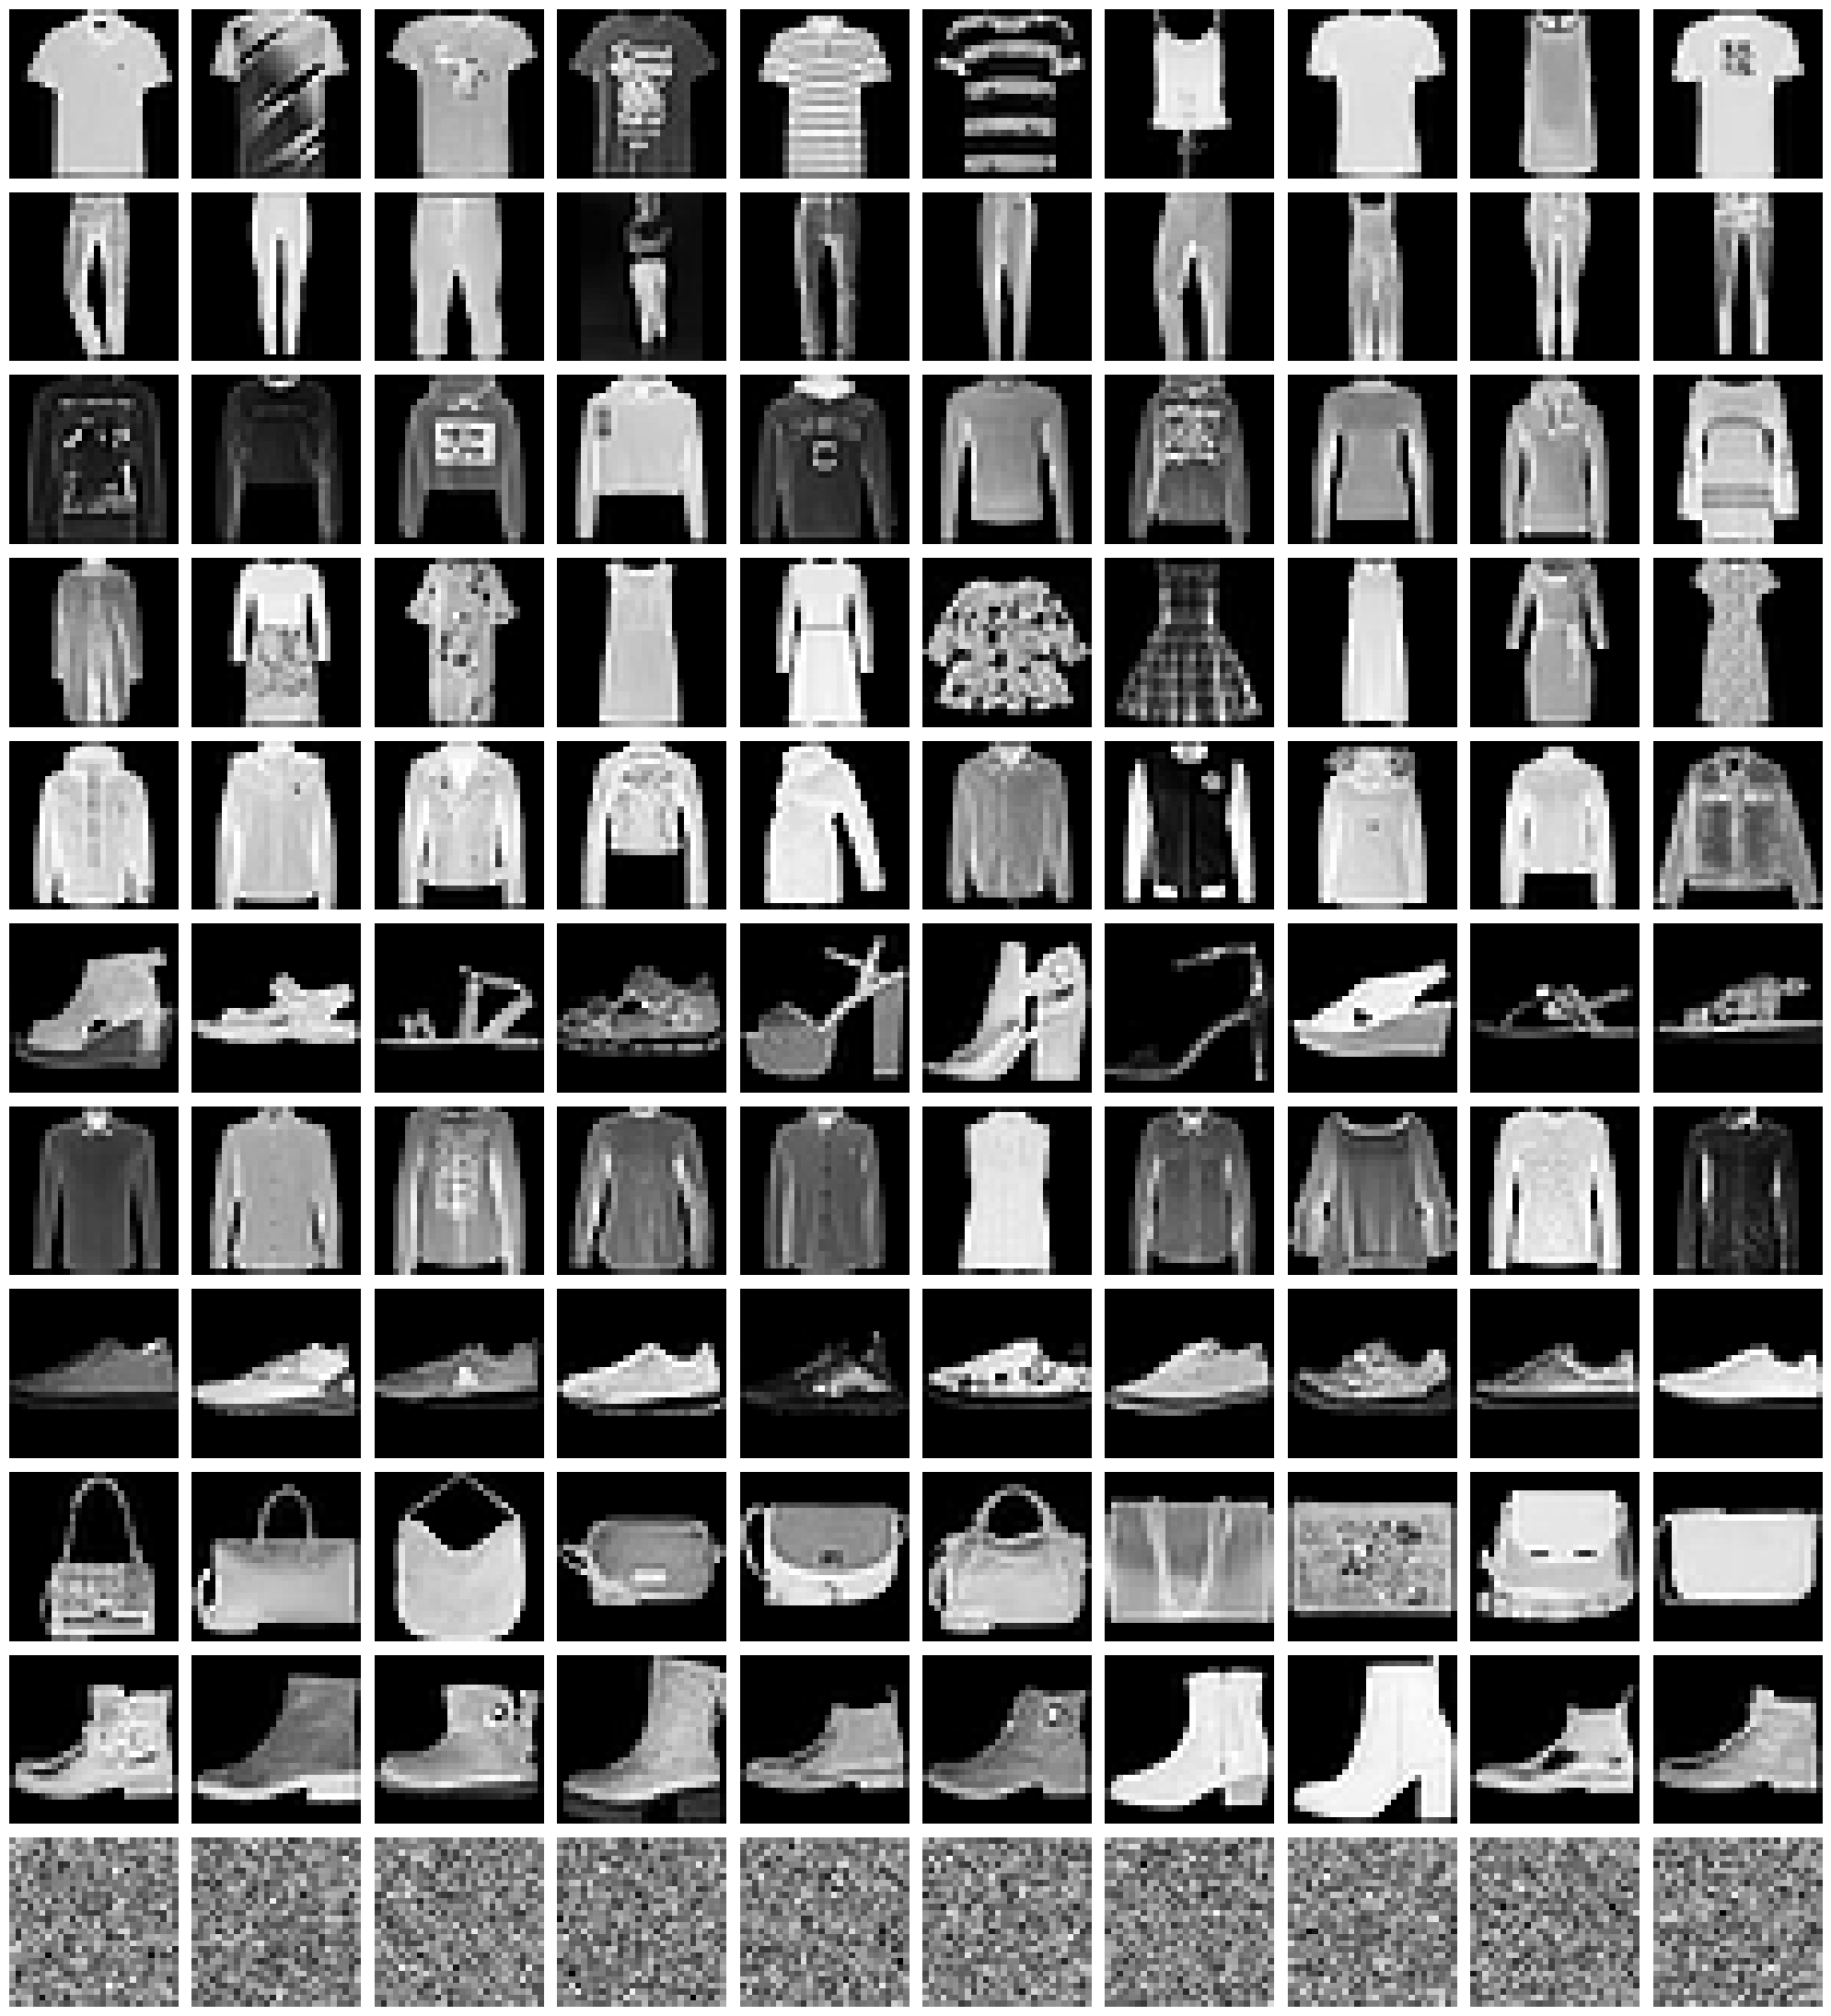

In [ ]:
class_images = {}

for class_name in sorted(os.listdir(train_pth)):
    class_pth = os.path.join(train_pth, class_name)

    if os.path.isdir(class_pth):
        class_images[class_name] = []

        for image_file in os.listdir(class_pth)[:10]:
            image_pth = os.path.join(class_pth, image_file)
            image = cv2.imread(image_pth, cv2.IMREAD_COLOR)     # read in color (BGR)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
                class_images[class_name].append(image)

# Create subplot grid
fig, axs = plt.subplots(len(class_images), 10, figsize=(20, 2*len(class_images)))

for i, (class_name, images) in enumerate(class_images.items()):
    for j in range(10):
        axs[i, j].imshow(images[j])  # already RGB
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()

#### Classifier

##### 3 conv2d + 2 Linear

In [ ]:
class Classifier(nn.Module):
    def __init__(self, nc, ncf, n_classes=11):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(nc, ncf, 4, 2, 1, bias=False),     # [B,nc,28,28] -> [B,ncf,14,14]
            nn.BatchNorm2d(ncf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ncf, ncf*2, 4, 2, 1, bias=False),   # [B,ncf,14,14] -> [B,ncf*2,7,7]
            nn.BatchNorm2d(ncf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ncf*2, ncf*4, 3, 1, 0, bias=False), # [B,ncf*2,7,7] --> [B,ncf*4,5,5]
            nn.BatchNorm2d(ncf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1),                      # [B,ncf*4,5,5] -> [B,ncf*4,1,1]
            nn.Flatten(),                                 # [B, ncf*4]
        )

        self.penultimate = nn.Sequential(
            nn.Linear(ncf*4, ncf*2),                      # [B, ncf*4] --> [B,ncf*2]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(ncf*2, n_classes)     # [B,ncf*2] --> [B, n_classes]

    def forward(self, x):
        features = self.feature_extractor(x)
        penultimate_features = self.penultimate(features)
        logits = self.classifier(penultimate_features)
        return logits, penultimate_features

#### Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, n_classes, nz, ngf, nc):
    super().__init__()

    self.embed = nn.Linear(n_classes, nz)   # [B,n_classes] --> [B,nz]

    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz*2, ngf*4, 4,1,0,bias=False),    # [B,nz*2,1,1] --> [B,ngf*4,4,4]
        nn.BatchNorm2d(ngf*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(ngf*4, ngf*2, 4,2,1,bias=False),   # [B,ngf*4,4,4] --> [B,ngf*2,8,8]
        nn.BatchNorm2d(ngf*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(ngf*2, ngf, 4,2,2,bias=False),     # [B,ngf*2,8,8] --> [B,ngf,14,14]
        nn.BatchNorm2d(ngf),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(ngf, nc, 4,2,1, bias=False),       # [B,ngf,14,14] --> [B,nc,28,28]
        nn.Tanh()
    )

  def forward(self, latent_vec, cond_vec):
      embed_vec = self.embed(cond_vec).unsqueeze(-1).unsqueeze(-1)    #  [B,n_classes] --> [B,nz] --> [B,nz,1,1]
      input = torch.cat([latent_vec, embed_vec],1)   # [B,nz,1,1]+[B,nz,1,1]  dim=1 -->  [B,nz*2,1,1]
      return self.main(input)

#### Checking Classifier and Generator

In [ ]:
nz = 100
nc = 1
ncf = 64
ngf = 64
n_classes = 11
batch_size = 5

gen = Generator(n_classes, nz, ngf, nc).to(device)
csf = Classifier(nc, ncf).to(device)

latent_vec = torch.randn((batch_size, nz, 1, 1), device=device)
print("Latent_vector:", latent_vec.shape)

random_vec = torch.randn((batch_size, n_classes), device=device)
print("Random_vector:", random_vec.shape)

cond_vec = F.softmax(random_vec, dim=1)
print("cond_vector:", cond_vec.shape)

gen_image = gen(latent_vec, cond_vec)
print("Generated image shape:", gen_image.shape)

classifier_op, features = csf(gen_image)
print("Penultimate_Layer_features:", features.shape)
print("Classifier output:", classifier_op.shape)

Latent_vector: torch.Size([5, 100, 1, 1])
Random_vector: torch.Size([5, 11])
cond_vector: torch.Size([5, 11])
Generated image shape: torch.Size([5, 1, 28, 28])
Penultimate_Layer_features: torch.Size([5, 128])
Classifier output: torch.Size([5, 11])


#### Weights_initialization

In [ ]:
def weights_initialization_gen_xavier(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.xavier_normal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.xavier_normal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_ortho(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.orthogonal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.orthogonal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_normal(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.normal_(m.weight,mean=0.0,std=0.02)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.normal_(m.weight,mean=0.0,std=0.02)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_uniform(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.uniform_(m.weight, -0.08, 0.08)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.uniform_(m.weight,-0.08, 0.08)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_zero(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.constant_(m.weight,0)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,0)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.constant_(m.weight,0)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_small(m,scale=1):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.constant_(m.weight,scale)
    if m.bias is not None:
      nn.init.constant_(m.bias,scale)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,scale)
    nn.init.constant_(m.bias,scale)
  elif isinstance(m,nn.Linear):
    nn.init.constant_(m.weight,scale)
    if m.bias is not None:
      nn.init.constant_(m.bias,scale)

def weights_initialization_gen_custom(m):
  if isinstance(m,nn.ConvTranspose2d):
    nn.init.normal_(m.weight, mean=0.0,std=0.02)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.orthogonal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

In [ ]:
def gen_ordered_batch(n_classes, samples_per_class, nz, device=None):
    batch_size = n_classes * samples_per_class
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    labels = torch.arange(n_classes, device=device).repeat_interleave(samples_per_class)
    one_hot_labels = F.one_hot(labels, num_classes=n_classes).float().to(device)
    return noise, one_hot_labels

In [ ]:
noise, one_hot_labels = gen_ordered_batch(11,10,100)
noise.shape, one_hot_labels

(torch.Size([110, 100, 1, 1]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]))

#### Train

In [ ]:
def train(model, train_loader, optimizer, criterion, n_csf_epochs, device):

    for epoch in tqdm(range(n_csf_epochs), desc="Training", unit="epoch"):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, features = model(images)
            loss  = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = correct / total

    return avg_loss, accuracy

#### Test

In [ ]:
def test(model, test_loader, criterion, device):

  model.eval()
  correct = 0
  total = 0
  running_loss = 0

  with torch.no_grad():

    pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing")

    for i, (images, labels) in pbar:
      images, labels = images.to(device), labels.to(device)
      logits, features = model(images)
      loss = criterion(logits, labels)
      running_loss += loss.item()

      _,predicted = torch.max(logits.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      pbar.set_postfix({"Batch Loss": loss.item()})

  avg_loss = running_loss / len(test_loader)
  accuracy = correct / total

  return avg_loss, accuracy

#### Class weights

In [ ]:
def cal_class_weights(dataset):

  targets = [target for _,target in dataset.samples]
  targets_tensor = torch.tensor(targets)

  class_counts = torch.bincount(targets_tensor)
  total_samples = len(dataset)

  class_weights = total_samples/(class_counts*len(class_counts))

  return class_weights

In [ ]:
train_label_tensor = torch.tensor([label for _,label in train_dataset.samples])
train_label_tensor

tensor([ 0,  0,  0,  ..., 10, 10, 10])

In [ ]:
torch.bincount(train_label_tensor)

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
cal_class_weights(train_dataset)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Inversion Loss functions

In [ ]:
def kl_divergence(p, q, eps=1e-8):
    p = p.clamp(min=eps, max=1.0)
    q = q.clamp(min=eps, max=1.0)
    kl_div = F.kl_div(p.log(), q, reduction='batchmean')
    return kl_div

def cross_entropy(logits, set_labels):
  ce_loss = F.cross_entropy(logits, set_labels)
  return ce_loss

In [ ]:
def cosine_similarity(features, eps=1e-8):
    normalized_features = F.normalize(features, p=2, dim=1, eps=eps)
    similarity_matrix = torch.mm(normalized_features, normalized_features.t())
    mask = torch.eye(similarity_matrix.size(0), device=similarity_matrix.device).bool()
    similarity_matrix = similarity_matrix.masked_fill(mask, 0)
    cos_loss = similarity_matrix.sum() / (features.size(0) * (features.size(0) - 1))
    return cos_loss

# def feature_orthogonality(features):
#     features = F.normalize(features, p=2, dim=1, eps=1e-8)
#     gram_matrix = torch.mm(features, features.t())
#     identity_matrix = torch.eye(gram_matrix.size(0), device=gram_matrix.device)
#     ortho_loss = torch.mean((gram_matrix - identity_matrix) ** 2)
#     return ortho_loss

In [ ]:
def compute_inversion_loss(gen_imgs, set_labels, input_pdf, logits, features, alpha, beta, gamma, delta):

    # logits, features = csf(gen_imgs)
    # logits = logits[:,:10]
    kl_loss    = kl_divergence(logits, input_pdf)
    ce_loss    = cross_entropy(logits, set_labels)
    cos_loss   = cosine_similarity(features)
    # ortho_loss = feature_orthogonality(features)

    inversion_loss = (alpha * kl_loss) + (beta * ce_loss) + (gamma * cos_loss)
    # + (delta * ortho_loss)
    return inversion_loss, kl_loss, ce_loss, cos_loss
    # , delta * ortho_loss

#### Metrics

In [ ]:
def compute_metrics(logits):

  # Confidence
    p = F.softmax(logits, dim=1)
    confidence, _ = torch.max(p, dim=1)

  # Margin
    top2_conf, _ = torch.topk(p, 2, dim=1)
    margin = top2_conf[:, 0] - top2_conf[:, 1]

  # Uncertainty_estimate
    k = logits.size(1)
    u = torch.full_like(p, 1.0 / k)    # [B,k]
    a = ((p - u)**2).sum(dim=1)        # shape: [B]
    delta = F.one_hot(p.argmax(dim=1), num_classes= k).float()
    b = ((delta - u) ** 2).sum(dim=1)  # shape: [B]
    ue = 1 - (a/b)

  # Entropy
    log_softmax = torch.log(p + 1e-10)
    entropy = -torch.sum(p * log_softmax, dim=1)

    return confidence, margin, ue, entropy

#### Inversion

In [ ]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

In [ ]:
def inversion(epoch, nz, n_gen_classes, samples_per_class,
              gen, csf, num_steps, gen_imgs_per_step,
              gen_optimizer,alpha, beta, gamma, delta,
              visualization_dir, ood_save_dir, metrics_storage,
              device):

  gen.train()
  csf.eval()
  freeze(csf)

  ibar = tqdm(range(num_steps), desc = f"Inversion")

  for step in ibar:

    gen_optimizer.zero_grad()

    noise = torch.randn(gen_imgs_per_step, nz, 1, 1, device=device)
    input_pdf = F.softmax(torch.randn(gen_imgs_per_step, n_gen_classes, device=device), dim = 1)
    set_labels = torch.argmax(input_pdf, dim=1)

    gen_imgs = gen(noise, input_pdf)

    logits, features = csf(gen_imgs)
    # logits = logits[:, :10]

    inversion_loss, kl_loss, ce_loss, cos_loss= compute_inversion_loss(
                                                              gen_imgs, set_labels, input_pdf, logits, features,
                                                              alpha, beta, gamma, delta)
    inversion_loss.backward()
    gen_optimizer.step()


    ibar.set_postfix({"Inversion Loss": inversion_loss.item()})

  with torch.no_grad():

    _ , predicted = torch.max(logits, 1)
    inversion_accuracy = (predicted == set_labels).float().mean().item()

    fixed_noise , fixed_pdf = gen_ordered_batch(
        n_gen_classes, samples_per_class, nz, device)

    class_imgs = gen(fixed_noise, fixed_pdf)

    conf_mean = []
    ue_mean   = []
    entropy_mean  = []
    margin_mean =  []

    for class_idx in range(n_gen_classes):

      start_idx = class_idx * samples_per_class
      end_idx   = start_idx + samples_per_class
      class_samples = class_imgs[start_idx:end_idx]
      logits, features = csf(class_samples)
      # logits = logits[:, :10]

      conf,  margin, ue, entropy = compute_metrics(logits)

      conf_val     = round(conf.mean().item(), 4)
      margin_val   = round(margin.mean().item(), 4)
      ue_val       = round(ue.mean().item(), 4)
      entropy_val  = round(entropy.mean().item(), 4)

      conf_mean.append(conf_val)
      margin_mean.append(margin_val)
      ue_mean.append(ue_val)
      entropy_mean.append(entropy_val)


      vutils.save_image(
          class_samples[0].detach().cpu(),
          os.path.join(
              visualization_dir,
              f"class_{class_idx}_epoch_{epoch+1:03d}_ue_{ue_val:.4f}.png"
          ),
          normalize=True,
      )


    metrics_storage[epoch] = {
        "conf_mean"   : conf_mean,
        "margin_mean" : margin_mean,
        "ue_mean"     : ue_mean,
        "entropy_mean": entropy_mean}

    print(f"\n Confidence : {conf_mean}")
    print(f"   Margin   : {margin_mean}")
    print(f"     UE     : {ue_mean}")
    print(f"   Entropy  : {entropy_mean}\n")

    avg_conf = sum(conf_mean) / len(conf_mean)
    avg_margin = sum(margin_mean) / len(margin_mean)
    avg_ue = sum(ue_mean) / len(ue_mean)
    avg_entropy = sum(entropy_mean) / len(entropy_mean)

    print(f"Avg_Confidence : {avg_conf:.4f}")
    print(f"Avg_Margin     : {avg_margin:.4f}")
    print(f"Avg_UE         : {avg_ue:.4f}")
    print(f"Avg_Entropy    : {avg_entropy:.4f}\n")


    for i, image in enumerate(gen_imgs):
      vutils.save_image(
          image.detach().cpu(),
          os.path.join(ood_save_dir, f"epoch_{epoch+1:03d}_sample_{i:04d}.png"),
          normalize=True
      )

  unfreeze(csf)
  return inversion_loss.item(), kl_loss.item(), ce_loss.item(), cos_loss.item(), inversion_accuracy

#### Main_pipeline

In [ ]:
def main_pipeline(train_pth, train_loader, test_loader, csf, csf_optimizer, n_csf_epochs,
                  gen, gen_optimizer, nz, n_gen_classes, visualization_dir, ood_save_dir,
                  gen_imgs_per_step, alpha, beta, gamma, delta,
                  samples_per_class, num_steps, num_epochs,
                  batch_size, saved_model_dir, device, resume_epoch=None):

    os.makedirs(saved_model_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)

    metrics_storage = {}
    best_test_accuracy = 0
    best_epoch = 0
    start_epoch = 1

    if resume_epoch is not None:
        checkpoint_path = os.path.join(saved_model_dir, f"checkpoint_epoch_{resume_epoch-1}.pt")
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)

        csf.load_state_dict(checkpoint['csf_state_dict'])
        gen.load_state_dict(checkpoint['gen_state_dict'])
        csf_optimizer.load_state_dict(checkpoint['csf_optimizer_state_dict'])
        gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
        best_test_accuracy = checkpoint['best_test_accuracy']
        best_epoch = checkpoint['best_epoch']
        metrics_storage = checkpoint['metrics_storage']
        start_epoch = resume_epoch

        print(f"Resumed from epoch {resume_epoch}. Best test acc: {best_test_accuracy:.4f} at epoch {best_epoch}")


    # Reload the dataset at start
    train_dataset = ImageFolder(root=train_pth, transform=fmnist_transform)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


    for epoch in range(start_epoch-1, num_epochs):
        print(f"\n------------------Epoch {epoch+1}----------------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train dataset size at epoch start: {len(train_dataset)}")

        inversion_loss, kl_loss, ce_loss, cos_loss, inversion_accuracy = inversion(epoch, nz, n_gen_classes,
                samples_per_class, gen, csf, num_steps, gen_imgs_per_step,
                gen_optimizer,  alpha, beta, gamma, delta,
                visualization_dir, ood_save_dir, metrics_storage,device)

        # inversion_loss, kl_loss, ce_loss, cos_loss, ortho_loss, inversion_accuracy = inversion(epoch, nz, n_gen_classes,
        #         samples_per_class, gen, csf, num_steps, gen_imgs_per_step,
        #         gen_optimizer,  alpha, beta, gamma, delta,
        #         visualization_dir, ood_save_dir, metrics_storage,device)

        print(f"Inversion Loss: {inversion_loss:.4f}, Inversion Accuracy: {inversion_accuracy:.4f}")
        print(f"Inversion Losses : kl_loss: {kl_loss:.4f}, ce_loss: {ce_loss:.4f}, cos_loss: {cos_loss:.4f}")
        # print(f"Inversion Losses : kl_loss: {kl_loss:.4f}, ce_loss: {ce_loss:.4f}, cos_loss: {cos_loss:.4f}, ortho_loss: {ortho_loss:.4f}")

        train_dataset = ImageFolder(root = train_pth, transform=fmnist_transform)

        # Count OOD files after inversion
        ood_files = glob.glob(os.path.join(ood_save_dir, "**", "*.*"), recursive=True)
        print(f"Garbage directory size after inversion: {len(ood_files)} files")
        print(f"Train dataset size after inversion: {len(train_dataset)}\n")


        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        class_weights = cal_class_weights(train_dataset).to(device)
        csf_criterion = nn.CrossEntropyLoss(weight=class_weights)

        train_loss, train_accuracy = train(csf, train_loader, csf_optimizer, csf_criterion, n_csf_epochs, device)
        test_loss, test_accuracy = test(csf, test_loader, csf_criterion, device)

        print(f"\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss   : {test_loss:.4f},  Test Accuracy : {test_accuracy:.4f}")


        np.save(os.path.join(saved_model_dir, "metrics_storage.npy"), metrics_storage)


        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch = epoch + 1
            torch.save(csf.state_dict(), f'{saved_model_dir}/csf_model.pth')
            print(f"\nNew best test accuracy: {best_test_accuracy:.4f} at epoch {best_epoch}. Model with best test accuracy is saved.")


        checkpoint = {
            'epoch': epoch+1,
            'csf_state_dict': csf.state_dict(),
            'gen_state_dict': gen.state_dict(),
            'csf_optimizer_state_dict': csf_optimizer.state_dict(),
            'gen_optimizer_state_dict': gen_optimizer.state_dict(),
            'best_test_accuracy': best_test_accuracy,
            'best_epoch': best_epoch,
            'metrics_storage': metrics_storage,
        }
        checkpoint_path = os.path.join(saved_model_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    print(f"\nBest Test Accuracy: {best_test_accuracy:.4f} at Epoch {best_epoch}")

#### Training

In [ ]:
# folder_path = "./drive/MyDrive/fmnist/EXP_1/model"
# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

Deleted folder: ./drive/MyDrive/fmnist/EXP_1/model


In [ ]:
# folder_path = "./drive/MyDrive/fmnist/EXP_1/visualization"

# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

Folder does not exist!


In [ ]:
garbage_dir    = os.path.join(train_pth, "garbage")
mydrive_fmnist  = "./drive/MyDrive/fmnist"
os.makedirs(mydrive_fmnist, exist_ok=True)

In [ ]:
experiment_no = 1

In [ ]:
saved_model_dir   = os.path.join(mydrive_fmnist,f"EXP_{experiment_no}/model")
visualization_dir = os.path.join(mydrive_fmnist,f"EXP_{experiment_no}/visualization")
ood_save_dir      = garbage_dir

os.makedirs(saved_model_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

In [ ]:
saved_model_dir

'./drive/MyDrive/fmnist/EXP_1/model'

In [ ]:
visualization_dir

'./drive/MyDrive/fmnist/EXP_1/visualization'

In [ ]:
nc = 1
n_gen_classes = 11
samples_per_class = 10
batch_size = 32

#-------------
## Hyperparameters to tweak
nz = 100
ncf = 64
ngf = 64
#------------

csf = Classifier(nc, ncf).to(device)

gen = Generator(n_gen_classes, nz, ngf, nc).to(device)
gen.apply(weights_initialization_gen_normal)

gen_optimizer = optim.Adam(gen.parameters(), lr=0.001)
csf_optimizer = optim.Adam(csf.parameters(), lr=0.0001)

# gen_optimizer = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
# csf_optimizer = optim.Adam(csf.parameters(), lr=0.00005, betas=(0.5, 0.999))

---

In [ ]:
n_csf_epochs = 1

In [ ]:
initial_class_weights = cal_class_weights(train_dataset).to(device)
csf_criterion = nn.CrossEntropyLoss(weight=initial_class_weights)
train_loss, train_accuracy = train(csf, train_loader, csf_optimizer, csf_criterion, n_csf_epochs, device)
print(f"\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Training: 100%|██████████| 1/1 [00:34<00:00, 34.66s/epoch]


Train Loss: 0.7464, Train Accuracy: 0.7469


In [ ]:
csf_criterion_test = nn.CrossEntropyLoss()
test_loss, test_accuracy   = test(csf,  test_loader, csf_criterion_test, device)
print(f"Test Loss:{test_loss:.4f},  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 313/313 [00:04<00:00, 64.00it/s, Batch Loss=0.231]

Test Loss:0.5393,  Test Accuracy: 0.7962


In [ ]:
# Directory to save the model
model_dir = saved_model_dir

# Saving model state_dict + other important info
checkpoint = {
    'model_state_dict': csf.state_dict(),
    'optimizer_state_dict': csf_optimizer.state_dict(),
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss,
}

# Save the intial model(before inversion) at "checkpoint_csf_initial.pt"
checkpoint_path = os.path.join(saved_model_dir, f"checkpoint_csf_initial.pt")
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved at {checkpoint_path}")

Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_csf_initial.pt


In [ ]:
# Hyperparameters for the inversion loss components
alpha = 0       # Weight for KL divergence loss
beta  = 1       # Weight for cross-entropy loss
gamma = 0       # Weight for cosine similarity loss
delta = 0       # Weight for feature orthogonality loss

num_steps         = 100
gen_imgs_per_step = 11000

In [ ]:
n_csf_epochs = 1
num_epochs   = 20

In [ ]:
main_pipeline(train_pth, train_loader, test_loader, csf, csf_optimizer, n_csf_epochs,
                  gen, gen_optimizer, nz, n_gen_classes, visualization_dir, ood_save_dir,
                  gen_imgs_per_step, alpha, beta, gamma, delta,
                  samples_per_class, num_steps, num_epochs,
                  batch_size, saved_model_dir, device, resume_epoch=None)


------------------Epoch 1----------------------
Epoch 1/20
Train dataset size at epoch start: 66000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=1.24]



 Confidence : [0.8906, 0.879, 0.5356, 0.2272, 0.467, 0.9464, 0.593, 0.4271, 0.9334, 0.8876, 0.9246]
   Margin   : [0.8613, 0.8284, 0.2917, 0.0451, 0.2963, 0.9225, 0.4148, 0.0919, 0.9004, 0.8227, 0.8834]
     UE     : [0.2249, 0.2458, 0.7041, 0.9423, 0.7852, 0.114, 0.656, 0.7602, 0.14, 0.2283, 0.1575]
   Entropy  : [0.5424, 0.552, 1.3629, 2.1129, 1.55, 0.2958, 1.2342, 1.4812, 0.3471, 0.5151, 0.3799]

Avg_Confidence : 0.7010
Avg_Margin     : 0.5780
Avg_UE         : 0.4508
Avg_Entropy    : 0.9430

Inversion Loss: 1.2367, Inversion Accuracy: 0.5685
Inversion Losses : kl_loss: 6.6697, ce_loss: 1.2367, cos_loss: 0.5923
Garbage directory size after inversion: 17000 files
Train dataset size after inversion: 77000



Testing: 100%|██████████| 313/313 [00:04<00:00, 66.15it/s, Batch Loss=0.214]



Train Loss: 0.4639, Train Accuracy: 0.8589
Test Loss   : 0.4160,  Test Accuracy : 0.8512

New best test accuracy: 0.8512 at epoch 1. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_1.pt

------------------Epoch 2----------------------
Epoch 2/20
Train dataset size at epoch start: 77000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.582]



 Confidence : [0.9703, 0.9654, 0.9865, 0.9759, 0.9319, 0.997, 0.9271, 0.9893, 0.9968, 0.9726, 0.9964]
   Margin   : [0.9601, 0.9445, 0.9813, 0.9618, 0.8771, 0.9962, 0.8885, 0.9862, 0.9953, 0.9534, 0.9948]
     UE     : [0.0642, 0.0744, 0.0294, 0.0521, 0.1414, 0.0065, 0.1524, 0.0235, 0.0071, 0.059, 0.0078]
   Entropy  : [0.1841, 0.1996, 0.0957, 0.1463, 0.3034, 0.0255, 0.3485, 0.0792, 0.0271, 0.1549, 0.0294]

Avg_Confidence : 0.9736
Avg_Margin     : 0.9581
Avg_UE         : 0.0562
Avg_Entropy    : 0.1449

Inversion Loss: 0.5818, Inversion Accuracy: 0.8018
Inversion Losses : kl_loss: 6.8135, ce_loss: 0.5818, cos_loss: 0.4708
Garbage directory size after inversion: 28000 files
Train dataset size after inversion: 88000



Testing: 100%|██████████| 313/313 [00:04<00:00, 63.67it/s, Batch Loss=0.194]



Train Loss: 0.3959, Train Accuracy: 0.8942
Test Loss   : 0.3841,  Test Accuracy : 0.8577

New best test accuracy: 0.8577 at epoch 2. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_2.pt

------------------Epoch 3----------------------
Epoch 3/20
Train dataset size at epoch start: 88000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.264]



 Confidence : [0.9928, 0.9977, 0.9985, 0.9979, 0.9923, 0.9999, 0.9911, 0.9974, 0.9999, 0.9983, 1.0]
   Margin   : [0.9893, 0.9968, 0.9978, 0.9969, 0.9893, 0.9999, 0.9842, 0.9954, 0.9999, 0.9968, 1.0]
     UE     : [0.0157, 0.0051, 0.0034, 0.0045, 0.0169, 0.0002, 0.0193, 0.0057, 0.0002, 0.0037, 0.0001]
   Entropy  : [0.0525, 0.0201, 0.014, 0.0171, 0.0567, 0.0009, 0.0577, 0.0202, 0.0013, 0.0132, 0.0003]

Avg_Confidence : 0.9969
Avg_Margin     : 0.9951
Avg_UE         : 0.0068
Avg_Entropy    : 0.0231

Inversion Loss: 0.2640, Inversion Accuracy: 0.9075
Inversion Losses : kl_loss: 7.4880, ce_loss: 0.2640, cos_loss: 0.4146
Garbage directory size after inversion: 39000 files
Train dataset size after inversion: 99000



Testing: 100%|██████████| 313/313 [00:05<00:00, 55.94it/s, Batch Loss=0.0881]



Train Loss: 0.3609, Train Accuracy: 0.9137
Test Loss   : 0.3518,  Test Accuracy : 0.8748

New best test accuracy: 0.8748 at epoch 3. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_3.pt

------------------Epoch 4----------------------
Epoch 4/20
Train dataset size at epoch start: 99000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.208]



 Confidence : [0.994, 0.9995, 0.9992, 0.9982, 0.9945, 1.0, 0.9944, 0.9995, 0.9998, 0.9986, 1.0]
   Margin   : [0.9901, 0.9991, 0.9988, 0.9971, 0.991, 1.0, 0.9912, 0.999, 0.9996, 0.9974, 1.0]
     UE     : [0.0132, 0.0012, 0.0018, 0.0039, 0.0121, 0.0, 0.0124, 0.0012, 0.0004, 0.0031, 0.0]
   Entropy  : [0.0443, 0.0053, 0.0075, 0.0148, 0.0403, 0.0001, 0.0413, 0.0051, 0.0021, 0.0113, 0.0001]

Avg_Confidence : 0.9980
Avg_Margin     : 0.9967
Avg_UE         : 0.0045
Avg_Entropy    : 0.0157

Inversion Loss: 0.2082, Inversion Accuracy: 0.9280
Inversion Losses : kl_loss: 7.4242, ce_loss: 0.2082, cos_loss: 0.3969
Garbage directory size after inversion: 50000 files
Train dataset size after inversion: 110000



Testing: 100%|██████████| 313/313 [00:05<00:00, 56.60it/s, Batch Loss=0.133]



Train Loss: 0.3308, Train Accuracy: 0.9283
Test Loss   : 0.3345,  Test Accuracy : 0.8795

New best test accuracy: 0.8795 at epoch 4. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_4.pt

------------------Epoch 5----------------------
Epoch 5/20
Train dataset size at epoch start: 110000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.16]



 Confidence : [0.992, 0.9996, 0.9994, 0.9986, 0.996, 1.0, 0.9972, 0.9985, 0.9999, 0.9995, 1.0]
   Margin   : [0.9856, 0.9994, 0.9991, 0.9979, 0.9938, 1.0, 0.9958, 0.9972, 0.9999, 0.9991, 1.0]
     UE     : [0.0174, 0.0009, 0.0013, 0.003, 0.0088, 0.0, 0.0062, 0.0033, 0.0001, 0.0011, 0.0]
   Entropy  : [0.0523, 0.0041, 0.006, 0.012, 0.031, 0.0001, 0.0228, 0.0119, 0.0008, 0.0046, 0.0001]

Avg_Confidence : 0.9982
Avg_Margin     : 0.9971
Avg_UE         : 0.0038
Avg_Entropy    : 0.0132

Inversion Loss: 0.1599, Inversion Accuracy: 0.9502
Inversion Losses : kl_loss: 7.8354, ce_loss: 0.1599, cos_loss: 0.3972
Garbage directory size after inversion: 61000 files
Train dataset size after inversion: 121000



Testing: 100%|██████████| 313/313 [00:04<00:00, 65.09it/s, Batch Loss=0.055]



Train Loss: 0.3097, Train Accuracy: 0.9371
Test Loss   : 0.3492,  Test Accuracy : 0.8739
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_5.pt

------------------Epoch 6----------------------
Epoch 6/20
Train dataset size at epoch start: 121000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.146]



 Confidence : [0.9963, 0.9997, 0.9993, 0.9994, 0.995, 1.0, 0.9976, 0.9982, 1.0, 0.999, 1.0]
   Margin   : [0.9931, 0.9994, 0.9991, 0.999, 0.9919, 1.0, 0.996, 0.9969, 0.9999, 0.9982, 1.0]
     UE     : [0.0082, 0.0007, 0.0015, 0.0014, 0.0109, 0.0, 0.0053, 0.0039, 0.0001, 0.0021, 0.0]
   Entropy  : [0.0266, 0.0033, 0.0065, 0.0058, 0.0368, 0.0001, 0.0194, 0.0142, 0.0004, 0.008, 0.0002]

Avg_Confidence : 0.9986
Avg_Margin     : 0.9976
Avg_UE         : 0.0031
Avg_Entropy    : 0.0110

Inversion Loss: 0.1463, Inversion Accuracy: 0.9517
Inversion Losses : kl_loss: 7.8132, ce_loss: 0.1463, cos_loss: 0.3736
Garbage directory size after inversion: 72000 files
Train dataset size after inversion: 132000



Testing: 100%|██████████| 313/313 [00:05<00:00, 57.90it/s, Batch Loss=0.0885]



Train Loss: 0.2946, Train Accuracy: 0.9448
Test Loss   : 0.3137,  Test Accuracy : 0.8868

New best test accuracy: 0.8868 at epoch 6. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_6.pt

------------------Epoch 7----------------------
Epoch 7/20
Train dataset size at epoch start: 132000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.143]



 Confidence : [0.9932, 0.9999, 0.9993, 0.9979, 0.9985, 1.0, 0.9994, 0.9982, 0.9999, 0.9979, 1.0]
   Margin   : [0.9869, 0.9998, 0.999, 0.9962, 0.9976, 1.0, 0.999, 0.9971, 0.9998, 0.9959, 1.0]
     UE     : [0.0149, 0.0003, 0.0015, 0.0046, 0.0033, 0.0, 0.0014, 0.004, 0.0002, 0.0047, 0.0]
   Entropy  : [0.0437, 0.0016, 0.0068, 0.0168, 0.0129, 0.0, 0.006, 0.0147, 0.001, 0.0159, 0.0002]

Avg_Confidence : 0.9986
Avg_Margin     : 0.9974
Avg_UE         : 0.0032
Avg_Entropy    : 0.0109

Inversion Loss: 0.1433, Inversion Accuracy: 0.9537
Inversion Losses : kl_loss: 8.1018, ce_loss: 0.1433, cos_loss: 0.3782
Garbage directory size after inversion: 83000 files
Train dataset size after inversion: 143000



Testing: 100%|██████████| 313/313 [00:04<00:00, 65.23it/s, Batch Loss=0.0843]



Train Loss: 0.2795, Train Accuracy: 0.9506
Test Loss   : 0.3093,  Test Accuracy : 0.8886

New best test accuracy: 0.8886 at epoch 7. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_7.pt

------------------Epoch 8----------------------
Epoch 8/20
Train dataset size at epoch start: 143000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.132]



 Confidence : [0.9937, 0.9999, 0.9998, 0.9968, 0.9993, 1.0, 0.9994, 0.9967, 0.9995, 0.9994, 1.0]
   Margin   : [0.9879, 0.9999, 0.9997, 0.9947, 0.9988, 1.0, 0.999, 0.9942, 0.9992, 0.9991, 1.0]
     UE     : [0.0137, 0.0002, 0.0005, 0.0069, 0.0016, 0.0, 0.0013, 0.0073, 0.0011, 0.0013, 0.0]
   Entropy  : [0.0399, 0.0011, 0.0022, 0.0245, 0.0069, 0.0, 0.0055, 0.0252, 0.0049, 0.0055, 0.0]

Avg_Confidence : 0.9986
Avg_Margin     : 0.9975
Avg_UE         : 0.0031
Avg_Entropy    : 0.0105

Inversion Loss: 0.1317, Inversion Accuracy: 0.9581
Inversion Losses : kl_loss: 8.2297, ce_loss: 0.1317, cos_loss: 0.3674
Garbage directory size after inversion: 94000 files
Train dataset size after inversion: 154000



Testing: 100%|██████████| 313/313 [00:04<00:00, 63.01it/s, Batch Loss=0.0316]



Train Loss: 0.2682, Train Accuracy: 0.9554
Test Loss   : 0.3055,  Test Accuracy : 0.8907

New best test accuracy: 0.8907 at epoch 8. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_8.pt

------------------Epoch 9----------------------
Epoch 9/20
Train dataset size at epoch start: 154000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.117]



 Confidence : [0.9925, 0.9999, 0.9994, 0.9979, 0.9987, 1.0, 0.999, 0.9975, 0.9993, 0.9993, 1.0]
   Margin   : [0.985, 0.9998, 0.9991, 0.9968, 0.9982, 1.0, 0.9984, 0.9957, 0.9988, 0.9986, 1.0]
     UE     : [0.0164, 0.0003, 0.0013, 0.0045, 0.0028, 0.0, 0.0023, 0.0056, 0.0015, 0.0016, 0.0]
   Entropy  : [0.0447, 0.0014, 0.0058, 0.0174, 0.0112, 0.0, 0.0094, 0.0197, 0.006, 0.0063, 0.0]

Avg_Confidence : 0.9985
Avg_Margin     : 0.9973
Avg_UE         : 0.0033
Avg_Entropy    : 0.0111

Inversion Loss: 0.1171, Inversion Accuracy: 0.9577
Inversion Losses : kl_loss: 8.1900, ce_loss: 0.1171, cos_loss: 0.3542
Garbage directory size after inversion: 105000 files
Train dataset size after inversion: 165000



Testing: 100%|██████████| 313/313 [00:04<00:00, 64.00it/s, Batch Loss=0.0745]



Train Loss: 0.2560, Train Accuracy: 0.9603
Test Loss   : 0.2969,  Test Accuracy : 0.8969

New best test accuracy: 0.8969 at epoch 9. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_9.pt

------------------Epoch 10----------------------
Epoch 10/20
Train dataset size at epoch start: 165000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.107]



 Confidence : [0.9919, 0.9994, 0.9988, 0.9998, 0.9993, 1.0, 0.9997, 0.9996, 0.9998, 0.9992, 1.0]
   Margin   : [0.9847, 0.9992, 0.998, 0.9996, 0.999, 1.0, 0.9995, 0.9994, 0.9996, 0.9987, 1.0]
     UE     : [0.0177, 0.0012, 0.0027, 0.0005, 0.0015, 0.0, 0.0006, 0.0009, 0.0005, 0.0017, 0.0]
   Entropy  : [0.0507, 0.0054, 0.0108, 0.0025, 0.0064, 0.0, 0.0029, 0.004, 0.0024, 0.0069, 0.0]

Avg_Confidence : 0.9989
Avg_Margin     : 0.9980
Avg_UE         : 0.0025
Avg_Entropy    : 0.0084

Inversion Loss: 0.1071, Inversion Accuracy: 0.9632
Inversion Losses : kl_loss: 8.3566, ce_loss: 0.1071, cos_loss: 0.3666
Garbage directory size after inversion: 116000 files
Train dataset size after inversion: 176000



Testing: 100%|██████████| 313/313 [00:04<00:00, 63.99it/s, Batch Loss=0.0819]



Train Loss: 0.2451, Train Accuracy: 0.9632
Test Loss   : 0.3051,  Test Accuracy : 0.8901
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_10.pt

------------------Epoch 11----------------------
Epoch 11/20
Train dataset size at epoch start: 176000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.0982]



 Confidence : [0.9952, 0.9999, 0.9997, 0.9995, 0.9993, 1.0, 0.9999, 0.9993, 0.9997, 0.9983, 1.0]
   Margin   : [0.9906, 0.9999, 0.9995, 0.9994, 0.9986, 1.0, 0.9998, 0.9991, 0.9995, 0.9971, 1.0]
     UE     : [0.0104, 0.0001, 0.0007, 0.001, 0.0016, 0.0, 0.0003, 0.0015, 0.0006, 0.0038, 0.0]
   Entropy  : [0.0309, 0.0008, 0.0031, 0.0047, 0.0063, 0.0, 0.0016, 0.0063, 0.0027, 0.0143, 0.0]

Avg_Confidence : 0.9992
Avg_Margin     : 0.9985
Avg_UE         : 0.0018
Avg_Entropy    : 0.0064

Inversion Loss: 0.0982, Inversion Accuracy: 0.9665
Inversion Losses : kl_loss: 8.3275, ce_loss: 0.0982, cos_loss: 0.3577
Garbage directory size after inversion: 127000 files
Train dataset size after inversion: 187000



Testing: 100%|██████████| 313/313 [00:04<00:00, 67.83it/s, Batch Loss=0.0448]



Train Loss: 0.2381, Train Accuracy: 0.9663
Test Loss   : 0.2892,  Test Accuracy : 0.8969
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_11.pt

------------------Epoch 12----------------------
Epoch 12/20
Train dataset size at epoch start: 187000


Inversion: 100%|██████████| 100/100 [01:58<00:00,  1.19s/it, Inversion Loss=0.0958]



 Confidence : [0.9938, 0.9999, 0.9988, 0.9996, 0.999, 1.0, 0.9997, 0.9997, 0.9981, 0.9997, 1.0]
   Margin   : [0.9877, 0.9998, 0.998, 0.9995, 0.9985, 1.0, 0.9996, 0.9996, 0.9964, 0.9995, 1.0]
     UE     : [0.0136, 0.0003, 0.0027, 0.0008, 0.0023, 0.0, 0.0006, 0.0007, 0.0041, 0.0006, 0.0]
   Entropy  : [0.0386, 0.0016, 0.0105, 0.004, 0.0093, 0.0, 0.0027, 0.0031, 0.0141, 0.0028, 0.0]

Avg_Confidence : 0.9989
Avg_Margin     : 0.9981
Avg_UE         : 0.0023
Avg_Entropy    : 0.0079

Inversion Loss: 0.0958, Inversion Accuracy: 0.9683
Inversion Losses : kl_loss: 8.7449, ce_loss: 0.0958, cos_loss: 0.3631
Garbage directory size after inversion: 138000 files
Train dataset size after inversion: 198000



Testing: 100%|██████████| 313/313 [00:04<00:00, 63.14it/s, Batch Loss=0.0463]



Train Loss: 0.2251, Train Accuracy: 0.9691
Test Loss   : 0.2829,  Test Accuracy : 0.8988

New best test accuracy: 0.8988 at epoch 12. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_12.pt

------------------Epoch 13----------------------
Epoch 13/20
Train dataset size at epoch start: 198000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it, Inversion Loss=0.0901]



 Confidence : [0.9976, 0.9999, 0.9994, 0.9995, 0.9996, 1.0, 0.9998, 0.9985, 1.0, 0.9997, 1.0]
   Margin   : [0.9955, 0.9998, 0.9993, 0.9993, 0.9993, 1.0, 0.9997, 0.9973, 0.9999, 0.9995, 1.0]
     UE     : [0.0052, 0.0003, 0.0013, 0.001, 0.0009, 0.0, 0.0005, 0.0033, 0.0001, 0.0006, 0.0]
   Entropy  : [0.018, 0.0013, 0.0057, 0.0047, 0.0041, 0.0003, 0.0023, 0.0123, 0.0006, 0.0029, 0.0]

Avg_Confidence : 0.9995
Avg_Margin     : 0.9991
Avg_UE         : 0.0012
Avg_Entropy    : 0.0047

Inversion Loss: 0.0901, Inversion Accuracy: 0.9708
Inversion Losses : kl_loss: 8.9414, ce_loss: 0.0901, cos_loss: 0.3592
Garbage directory size after inversion: 149000 files
Train dataset size after inversion: 209000



Testing: 100%|██████████| 313/313 [00:05<00:00, 58.13it/s, Batch Loss=0.00684]



Train Loss: 0.2173, Train Accuracy: 0.9724
Test Loss   : 0.2785,  Test Accuracy : 0.8997

New best test accuracy: 0.8997 at epoch 13. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_13.pt

------------------Epoch 14----------------------
Epoch 14/20
Train dataset size at epoch start: 209000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.0796]



 Confidence : [0.9991, 1.0, 0.9998, 0.9998, 0.9995, 1.0, 0.9998, 0.9986, 0.9999, 0.9998, 1.0]
   Margin   : [0.9983, 0.9999, 0.9998, 0.9997, 0.999, 1.0, 0.9998, 0.9978, 0.9998, 0.9997, 1.0]
     UE     : [0.002, 0.0001, 0.0003, 0.0004, 0.0012, 0.0, 0.0004, 0.0032, 0.0002, 0.0005, 0.0]
   Entropy  : [0.008, 0.0005, 0.0017, 0.0022, 0.0049, 0.0001, 0.0021, 0.012, 0.0012, 0.0021, 0.0]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9994
Avg_UE         : 0.0008
Avg_Entropy    : 0.0032

Inversion Loss: 0.0796, Inversion Accuracy: 0.9720
Inversion Losses : kl_loss: 8.7303, ce_loss: 0.0796, cos_loss: 0.3561
Garbage directory size after inversion: 160000 files
Train dataset size after inversion: 220000



Testing: 100%|██████████| 313/313 [00:04<00:00, 64.51it/s, Batch Loss=0.0428]



Train Loss: 0.2136, Train Accuracy: 0.9738
Test Loss   : 0.2904,  Test Accuracy : 0.8993
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_14.pt

------------------Epoch 15----------------------
Epoch 15/20
Train dataset size at epoch start: 220000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.0824]



 Confidence : [0.9989, 0.9999, 0.9995, 0.9985, 0.9997, 0.9999, 0.9997, 0.9998, 0.9994, 0.9996, 1.0]
   Margin   : [0.9978, 0.9999, 0.9991, 0.9977, 0.9994, 0.9999, 0.9994, 0.9997, 0.9988, 0.9994, 1.0]
     UE     : [0.0024, 0.0001, 0.0012, 0.0032, 0.0008, 0.0001, 0.0007, 0.0005, 0.0013, 0.0009, 0.0]
   Entropy  : [0.0088, 0.0007, 0.0051, 0.0128, 0.0033, 0.0006, 0.0029, 0.0023, 0.0053, 0.0039, 0.0]

Avg_Confidence : 0.9995
Avg_Margin     : 0.9992
Avg_UE         : 0.0010
Avg_Entropy    : 0.0042

Inversion Loss: 0.0824, Inversion Accuracy: 0.9712
Inversion Losses : kl_loss: 8.7569, ce_loss: 0.0824, cos_loss: 0.3377
Garbage directory size after inversion: 171000 files
Train dataset size after inversion: 231000



Testing: 100%|██████████| 313/313 [00:04<00:00, 65.22it/s, Batch Loss=0.0117]



Train Loss: 0.2024, Train Accuracy: 0.9756
Test Loss   : 0.2732,  Test Accuracy : 0.9018

New best test accuracy: 0.9018 at epoch 15. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_15.pt

------------------Epoch 16----------------------
Epoch 16/20
Train dataset size at epoch start: 231000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.0764]



 Confidence : [0.9983, 1.0, 0.9999, 0.9983, 0.9998, 1.0, 0.9995, 0.9998, 0.9995, 0.9999, 1.0]
   Margin   : [0.9967, 0.9999, 0.9999, 0.9967, 0.9997, 1.0, 0.9991, 0.9997, 0.999, 0.9998, 1.0]
     UE     : [0.0037, 0.0001, 0.0002, 0.0038, 0.0004, 0.0, 0.0012, 0.0005, 0.0011, 0.0003, 0.0]
   Entropy  : [0.0124, 0.0005, 0.0009, 0.0138, 0.0021, 0.0002, 0.0051, 0.0025, 0.0045, 0.0014, 0.0]

Avg_Confidence : 0.9995
Avg_Margin     : 0.9991
Avg_UE         : 0.0010
Avg_Entropy    : 0.0039

Inversion Loss: 0.0764, Inversion Accuracy: 0.9751
Inversion Losses : kl_loss: 8.8526, ce_loss: 0.0764, cos_loss: 0.3595
Garbage directory size after inversion: 182000 files
Train dataset size after inversion: 242000



Testing: 100%|██████████| 313/313 [00:05<00:00, 54.49it/s, Batch Loss=0.0247]



Train Loss: 0.1967, Train Accuracy: 0.9767
Test Loss   : 0.2961,  Test Accuracy : 0.8922
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_16.pt

------------------Epoch 17----------------------
Epoch 17/20
Train dataset size at epoch start: 242000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.0736]



 Confidence : [0.9992, 1.0, 0.9999, 0.9996, 0.9997, 0.9999, 0.9994, 0.9997, 1.0, 0.9997, 1.0]
   Margin   : [0.9984, 0.9999, 0.9998, 0.9993, 0.9996, 0.9998, 0.999, 0.9996, 0.9999, 0.9995, 1.0]
     UE     : [0.0018, 0.0001, 0.0002, 0.0008, 0.0006, 0.0003, 0.0012, 0.0006, 0.0001, 0.0007, 0.0]
   Entropy  : [0.0068, 0.0006, 0.0013, 0.0038, 0.0029, 0.0013, 0.0051, 0.0028, 0.0004, 0.0031, 0.0]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9995
Avg_UE         : 0.0006
Avg_Entropy    : 0.0026

Inversion Loss: 0.0736, Inversion Accuracy: 0.9752
Inversion Losses : kl_loss: 8.8775, ce_loss: 0.0736, cos_loss: 0.3271
Garbage directory size after inversion: 193000 files
Train dataset size after inversion: 253000



Testing: 100%|██████████| 313/313 [00:05<00:00, 58.29it/s, Batch Loss=0.023]



Train Loss: 0.1911, Train Accuracy: 0.9788
Test Loss   : 0.2767,  Test Accuracy : 0.9025

New best test accuracy: 0.9025 at epoch 17. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_17.pt

------------------Epoch 18----------------------
Epoch 18/20
Train dataset size at epoch start: 253000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.068]



 Confidence : [0.9996, 1.0, 0.9999, 0.9997, 0.9998, 1.0, 0.9995, 1.0, 1.0, 0.9999, 1.0]
   Margin   : [0.9992, 1.0, 0.9998, 0.9994, 0.9997, 1.0, 0.9991, 1.0, 0.9999, 0.9998, 1.0]
     UE     : [0.0009, 0.0, 0.0002, 0.0007, 0.0004, 0.0, 0.0012, 0.0001, 0.0001, 0.0002, 0.0]
   Entropy  : [0.0038, 0.0002, 0.001, 0.0033, 0.0018, 0.0002, 0.0052, 0.0004, 0.0004, 0.0011, 0.0]

Avg_Confidence : 0.9999
Avg_Margin     : 0.9997
Avg_UE         : 0.0003
Avg_Entropy    : 0.0016

Inversion Loss: 0.0680, Inversion Accuracy: 0.9776
Inversion Losses : kl_loss: 9.1400, ce_loss: 0.0680, cos_loss: 0.3755
Garbage directory size after inversion: 204000 files
Train dataset size after inversion: 264000



Testing: 100%|██████████| 313/313 [00:05<00:00, 54.21it/s, Batch Loss=0.0103]



Train Loss: 0.1815, Train Accuracy: 0.9801
Test Loss   : 0.2797,  Test Accuracy : 0.9012
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_18.pt

------------------Epoch 19----------------------
Epoch 19/20
Train dataset size at epoch start: 264000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.25s/it, Inversion Loss=0.0728]



 Confidence : [0.9994, 1.0, 0.9999, 0.9997, 0.9999, 1.0, 0.9991, 0.9999, 0.9998, 0.9996, 1.0]
   Margin   : [0.9989, 1.0, 0.9999, 0.9995, 0.9998, 0.9999, 0.9985, 0.9998, 0.9996, 0.9995, 1.0]
     UE     : [0.0013, 0.0001, 0.0002, 0.0007, 0.0003, 0.0001, 0.0019, 0.0003, 0.0005, 0.0008, 0.0]
   Entropy  : [0.0052, 0.0003, 0.001, 0.0033, 0.0012, 0.0005, 0.0079, 0.0013, 0.0026, 0.0037, 0.0]

Avg_Confidence : 0.9998
Avg_Margin     : 0.9996
Avg_UE         : 0.0006
Avg_Entropy    : 0.0025

Inversion Loss: 0.0728, Inversion Accuracy: 0.9745
Inversion Losses : kl_loss: 9.0232, ce_loss: 0.0728, cos_loss: 0.3562
Garbage directory size after inversion: 215000 files
Train dataset size after inversion: 275000



Testing: 100%|██████████| 313/313 [00:05<00:00, 54.05it/s, Batch Loss=0.00337]



Train Loss: 0.1764, Train Accuracy: 0.9815
Test Loss   : 0.2672,  Test Accuracy : 0.9043

New best test accuracy: 0.9043 at epoch 19. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_19.pt

------------------Epoch 20----------------------
Epoch 20/20
Train dataset size at epoch start: 275000


Inversion: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Inversion Loss=0.0702]



 Confidence : [0.9996, 1.0, 1.0, 0.9994, 0.9998, 1.0, 0.9997, 0.9991, 0.9998, 0.9999, 1.0]
   Margin   : [0.9992, 0.9999, 0.9999, 0.9992, 0.9997, 0.9999, 0.9996, 0.9983, 0.9997, 0.9998, 1.0]
     UE     : [0.0009, 0.0001, 0.0001, 0.0013, 0.0004, 0.0001, 0.0006, 0.002, 0.0004, 0.0003, 0.0]
   Entropy  : [0.004, 0.0005, 0.0004, 0.0059, 0.0021, 0.0005, 0.003, 0.0077, 0.0018, 0.0013, 0.0]

Avg_Confidence : 0.9998
Avg_Margin     : 0.9996
Avg_UE         : 0.0006
Avg_Entropy    : 0.0025

Inversion Loss: 0.0702, Inversion Accuracy: 0.9765
Inversion Losses : kl_loss: 8.9369, ce_loss: 0.0702, cos_loss: 0.3083
Garbage directory size after inversion: 226000 files
Train dataset size after inversion: 286000



Testing: 100%|██████████| 313/313 [00:04<00:00, 63.11it/s, Batch Loss=0.151]



Train Loss: 0.1682, Train Accuracy: 0.9828
Test Loss   : 0.2867,  Test Accuracy : 0.9029
Checkpoint saved at ./drive/MyDrive/fmnist/EXP_1/model/checkpoint_epoch_20.pt

Best Test Accuracy: 0.9043 at Epoch 19


#### Inference

##### Visualization

In [ ]:
def plot_epoch_class_grid(viz_dir, n_classes, start_epoch, end_epoch):
    """
    Show a grid of saved images with rows=classes, cols=epochs
    Each subplot has (epoch, UE) as title (top of image)
    """
    num_epochs = end_epoch - start_epoch + 1
    fig, axes = plt.subplots(n_classes, num_epochs, figsize=(num_epochs*2, n_classes*2))

    # Normalize axes to 2D
    if n_classes == 1:
        axes = [axes]
    if num_epochs == 1:
        axes = [[ax] for ax in axes]

    for class_idx in range(n_classes):
        for col, epoch in enumerate(range(start_epoch, end_epoch+1)):
            ax = axes[class_idx][col] if n_classes > 1 else axes[col]

            # Find file
            pattern = f"class_{class_idx}_epoch_{epoch:03d}_ue_"
            match_file = [f for f in os.listdir(viz_dir) if f.startswith(pattern)]
            if not match_file:
                ax.axis("off")
                continue

            img_path = os.path.join(viz_dir, match_file[0])
            img = Image.open(img_path).convert("RGB")

            # Extract UE value
            ue_val = re.findall(r"ue_([0-9.]+)", img_path)
            if ue_val:
                ue_str = ue_val[0].rstrip(".")
                ue_val = float(ue_str)
            else:
                ue_val = None

            # Plot image
            ax.imshow(img)
            ax.axis("off")

            # Set title above image
            title_text = f"(Epoch {epoch}, UE={ue_val:.2f})" if ue_val else f"(Epoch {epoch}, -)"
            ax.set_title(title_text, fontsize=8, color="black")

    plt.tight_layout()
    plt.show()

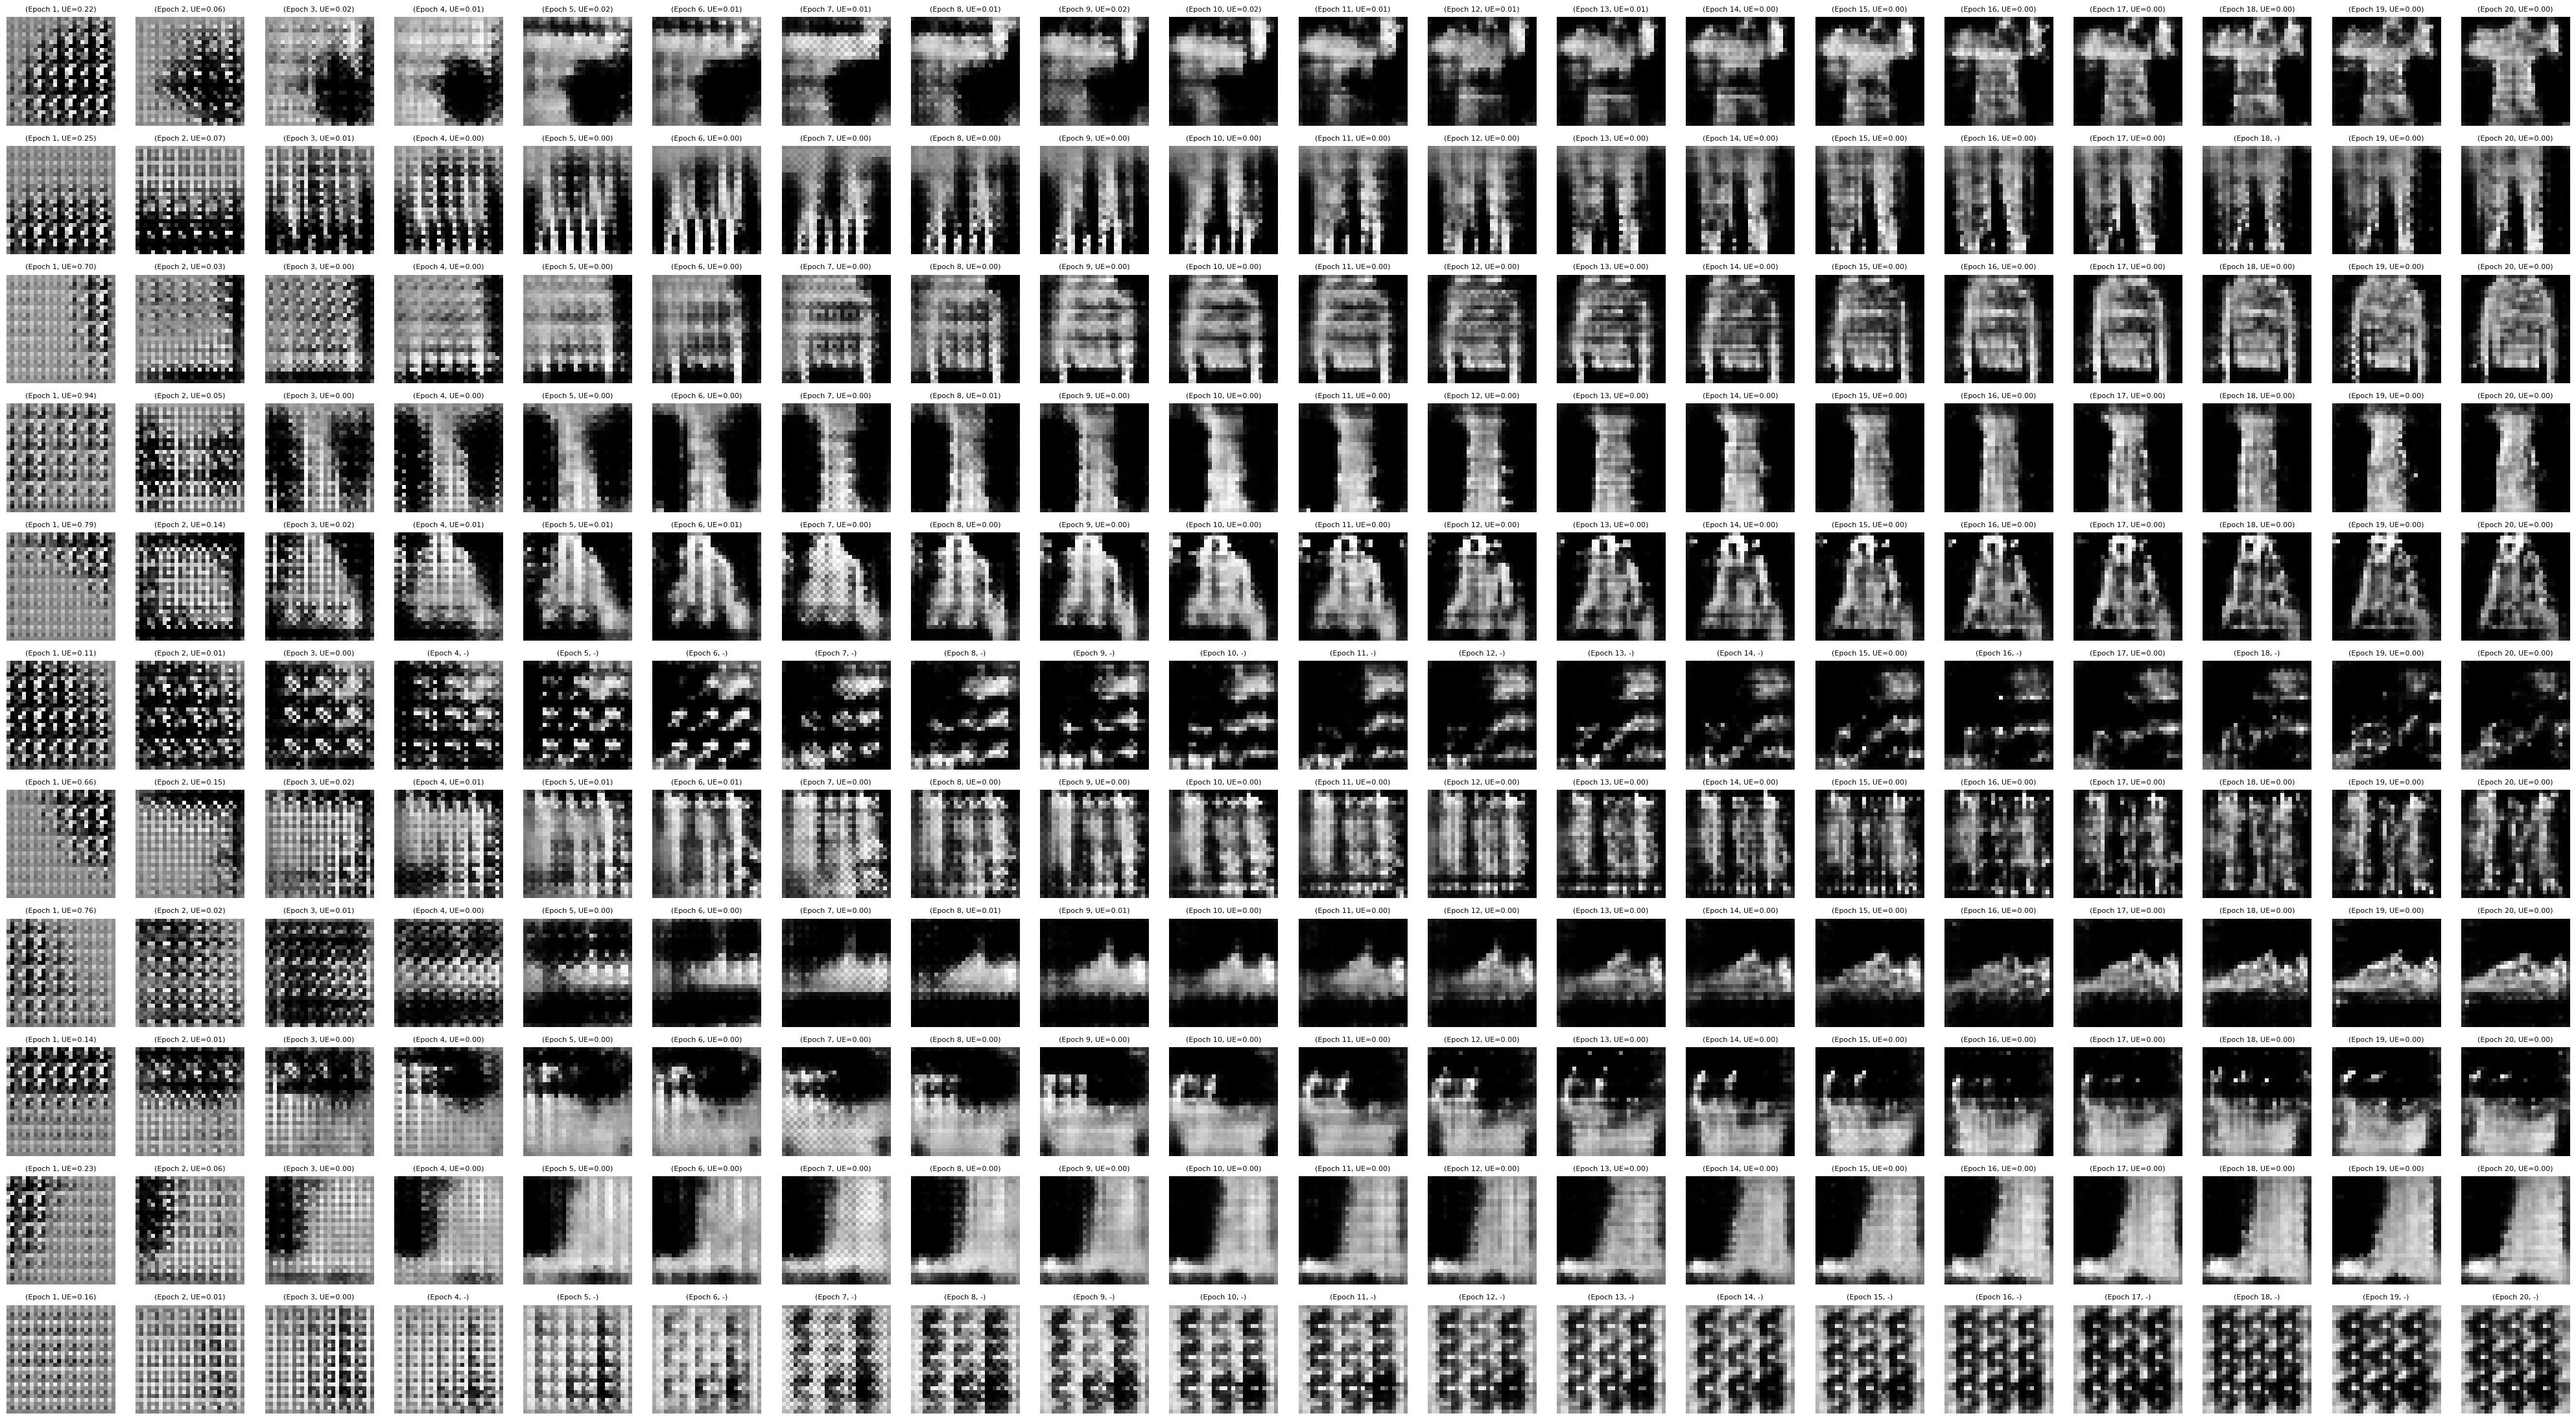

In [ ]:
visualization_dir = visualization_dir
start_epoch=1
end_epoch=20

plot_epoch_class_grid(
    viz_dir= visualization_dir,
    n_classes=11,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
)

##### Metrics

In [ ]:
def build_metric_df(metrics_storage, metric_name, n_classes):
    """
    Convert metrics_storage into a DataFrame for one metric
    Rows = epochs, Columns = classes
    """
    data = {}
    for epoch, metrics in metrics_storage.items():
        values = metrics[metric_name]
        data[epoch+1] = values
    df = pd.DataFrame.from_dict(data, orient="index", columns=[f"Class_{i}" for i in range(n_classes)])
    df.index.name = "Epoch"
    return df

In [ ]:
# Load saved metrics
metrics_storage = np.load(os.path.join(saved_model_dir, 'metrics_storage.npy'), allow_pickle=True).item()

# Build one dataframe per metric
n_classes = len(next(iter(metrics_storage.values()))["conf_mean"])  # infer class count

conf_df    = build_metric_df(metrics_storage, "conf_mean", n_classes)
ue_df      = build_metric_df(metrics_storage, "ue_mean", n_classes)
entropy_df = build_metric_df(metrics_storage, "entropy_mean", n_classes)
margin_df  = build_metric_df(metrics_storage, "margin_mean", n_classes)

# Save to CSV
conf_df.to_csv(os.path.join(saved_model_dir,'conf_mean.csv'))
ue_df.to_csv(os.path.join(saved_model_dir, 'ue_mean.csv'))
entropy_df.to_csv(os.path.join(saved_model_dir, 'entropy_mean.csv'))
margin_df.to_csv(os.path.join(saved_model_dir, 'margin_mean.csv'))

In [ ]:
conf_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.8906   0.8790   0.5356   0.2272   0.4670   0.9464   0.5930   0.4271   
2       0.9703   0.9654   0.9865   0.9759   0.9319   0.9970   0.9271   0.9893   
3       0.9928   0.9977   0.9985   0.9979   0.9923   0.9999   0.9911   0.9974   
4       0.9940   0.9995   0.9992   0.9982   0.9945   1.0000   0.9944   0.9995   
5       0.9920   0.9996   0.9994   0.9986   0.9960   1.0000   0.9972   0.9985   
6       0.9963   0.9997   0.9993   0.9994   0.9950   1.0000   0.9976   0.9982   
7       0.9932   0.9999   0.9993   0.9979   0.9985   1.0000   0.9994   0.9982   
8       0.9937   0.9999   0.9998   0.9968   0.9993   1.0000   0.9994   0.9967   
9       0.9925   0.9999   0.9994   0.9979   0.9987   1.0000   0.9990   0.9975   
10      0.9919   0.9994   0.9988   0.9998   0.9993   1.0000   0.9997   0.9996   
11      0.9952   0.9999   0.9997   0.9995   0.9993   1.0000   0.9999   0.9993   
12      0.9938   0.9999   0.9988   0.9996   0.9990   1.0000   0.9997   0.9997   
13      0.9976   0.9999   0.9994   0.9995   0.9996   1.0000   0.9998   0.9985   
14      0.9991   1.0000   0.9998   0.9998   0.9995   1.0000   0.9998   0.9986   
15      0.9989   0.9999   0.9995   0.9985   0.9997   0.9999   0.9997   0.9998   
16      0.9983   1.0000   0.9999   0.9983   0.9998   1.0000   0.9995   0.9998   
17      0.9992   1.0000   0.9999   0.9996   0.9997   0.9999   0.9994   0.9997   
18      0.9996   1.0000   0.9999   0.9997   0.9998   1.0000   0.9995   1.0000   
19      0.9994   1.0000   0.9999   0.9997   0.9999   1.0000   0.9991   0.9999   
20      0.9996   1.0000   1.0000   0.9994   0.9998   1.0000   0.9997   0.9991   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.9334   0.8876    0.9246  
2       0.9968   0.9726    0.9964  
3       0.9999   0.9983    1.0000  
4       0.9998   0.9986    1.0000  
5       0.9999   0.9995    1.0000  
6       1.0000   0.9990    1.0000  
7       0.9999   0.9979    1.0000  
8       0.9995   0.9994    1.0000  
9       0.9993   0.9993    1.0000  
10      0.9998   0.9992    1.0000  
11      0.9997   0.9983    1.0000  
12      0.9981   0.9997    1.0000  
13      1.0000   0.9997    1.0000  
14      0.9999   0.9998    1.0000  
15      0.9994   0.9996    1.0000  
16      0.9995   0.9999    1.0000  
17      1.0000   0.9997    1.0000  
18      1.0000   0.9999    1.0000  
19      0.9998   0.9996    1.0000  
20      0.9998   0.9999    1.0000

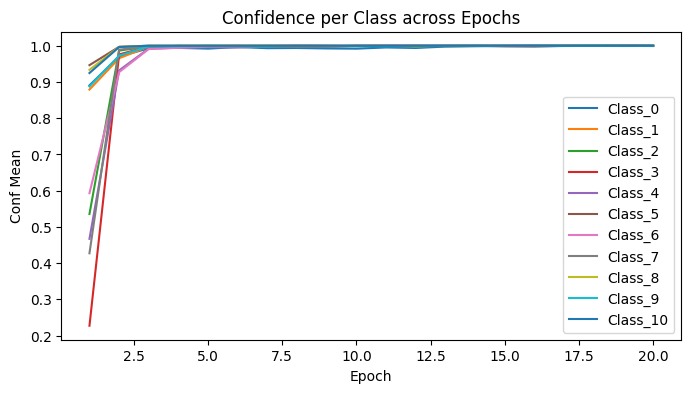

In [ ]:
# Plot conf per class across epochs
plt.figure(figsize=(8,4))
for c in conf_df.columns:
    plt.plot(conf_df.index, conf_df[c], label=c)
plt.xlabel("Epoch")
plt.ylabel("Conf Mean")
plt.title("Confidence per Class across Epochs")
plt.legend()
plt.show()

In [ ]:
margin_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.8613   0.8284   0.2917   0.0451   0.2963   0.9225   0.4148   0.0919   
2       0.9601   0.9445   0.9813   0.9618   0.8771   0.9962   0.8885   0.9862   
3       0.9893   0.9968   0.9978   0.9969   0.9893   0.9999   0.9842   0.9954   
4       0.9901   0.9991   0.9988   0.9971   0.9910   1.0000   0.9912   0.9990   
5       0.9856   0.9994   0.9991   0.9979   0.9938   1.0000   0.9958   0.9972   
6       0.9931   0.9994   0.9991   0.9990   0.9919   1.0000   0.9960   0.9969   
7       0.9869   0.9998   0.9990   0.9962   0.9976   1.0000   0.9990   0.9971   
8       0.9879   0.9999   0.9997   0.9947   0.9988   1.0000   0.9990   0.9942   
9       0.9850   0.9998   0.9991   0.9968   0.9982   1.0000   0.9984   0.9957   
10      0.9847   0.9992   0.9980   0.9996   0.9990   1.0000   0.9995   0.9994   
11      0.9906   0.9999   0.9995   0.9994   0.9986   1.0000   0.9998   0.9991   
12      0.9877   0.9998   0.9980   0.9995   0.9985   1.0000   0.9996   0.9996   
13      0.9955   0.9998   0.9993   0.9993   0.9993   1.0000   0.9997   0.9973   
14      0.9983   0.9999   0.9998   0.9997   0.9990   1.0000   0.9998   0.9978   
15      0.9978   0.9999   0.9991   0.9977   0.9994   0.9999   0.9994   0.9997   
16      0.9967   0.9999   0.9999   0.9967   0.9997   1.0000   0.9991   0.9997   
17      0.9984   0.9999   0.9998   0.9993   0.9996   0.9998   0.9990   0.9996   
18      0.9992   1.0000   0.9998   0.9994   0.9997   1.0000   0.9991   1.0000   
19      0.9989   1.0000   0.9999   0.9995   0.9998   0.9999   0.9985   0.9998   
20      0.9992   0.9999   0.9999   0.9992   0.9997   0.9999   0.9996   0.9983   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.9004   0.8227    0.8834  
2       0.9953   0.9534    0.9948  
3       0.9999   0.9968    1.0000  
4       0.9996   0.9974    1.0000  
5       0.9999   0.9991    1.0000  
6       0.9999   0.9982    1.0000  
7       0.9998   0.9959    1.0000  
8       0.9992   0.9991    1.0000  
9       0.9988   0.9986    1.0000  
10      0.9996   0.9987    1.0000  
11      0.9995   0.9971    1.0000  
12      0.9964   0.9995    1.0000  
13      0.9999   0.9995    1.0000  
14      0.9998   0.9997    1.0000  
15      0.9988   0.9994    1.0000  
16      0.9990   0.9998    1.0000  
17      0.9999   0.9995    1.0000  
18      0.9999   0.9998    1.0000  
19      0.9996   0.9995    1.0000  
20      0.9997   0.9998    1.0000

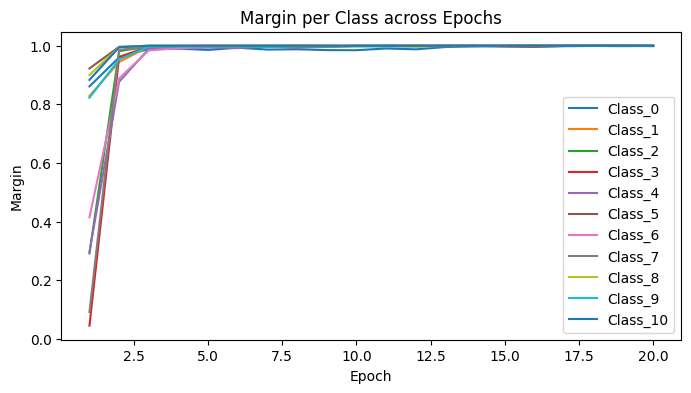

In [ ]:
# Plot margin per class across epochs
plt.figure(figsize=(8,4))
for c in margin_df.columns:
    plt.plot(margin_df.index, margin_df[c], label=c)
plt.xlabel("Epoch")
plt.ylabel("Margin")
plt.title("Margin per Class across Epochs")
plt.legend()
plt.show()

In [ ]:
ue_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.2249   0.2458   0.7041   0.9423   0.7852   0.1140   0.6560   0.7602   
2       0.0642   0.0744   0.0294   0.0521   0.1414   0.0065   0.1524   0.0235   
3       0.0157   0.0051   0.0034   0.0045   0.0169   0.0002   0.0193   0.0057   
4       0.0132   0.0012   0.0018   0.0039   0.0121   0.0000   0.0124   0.0012   
5       0.0174   0.0009   0.0013   0.0030   0.0088   0.0000   0.0062   0.0033   
6       0.0082   0.0007   0.0015   0.0014   0.0109   0.0000   0.0053   0.0039   
7       0.0149   0.0003   0.0015   0.0046   0.0033   0.0000   0.0014   0.0040   
8       0.0137   0.0002   0.0005   0.0069   0.0016   0.0000   0.0013   0.0073   
9       0.0164   0.0003   0.0013   0.0045   0.0028   0.0000   0.0023   0.0056   
10      0.0177   0.0012   0.0027   0.0005   0.0015   0.0000   0.0006   0.0009   
11      0.0104   0.0001   0.0007   0.0010   0.0016   0.0000   0.0003   0.0015   
12      0.0136   0.0003   0.0027   0.0008   0.0023   0.0000   0.0006   0.0007   
13      0.0052   0.0003   0.0013   0.0010   0.0009   0.0000   0.0005   0.0033   
14      0.0020   0.0001   0.0003   0.0004   0.0012   0.0000   0.0004   0.0032   
15      0.0024   0.0001   0.0012   0.0032   0.0008   0.0001   0.0007   0.0005   
16      0.0037   0.0001   0.0002   0.0038   0.0004   0.0000   0.0012   0.0005   
17      0.0018   0.0001   0.0002   0.0008   0.0006   0.0003   0.0012   0.0006   
18      0.0009   0.0000   0.0002   0.0007   0.0004   0.0000   0.0012   0.0001   
19      0.0013   0.0001   0.0002   0.0007   0.0003   0.0001   0.0019   0.0003   
20      0.0009   0.0001   0.0001   0.0013   0.0004   0.0001   0.0006   0.0020   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.1400   0.2283    0.1575  
2       0.0071   0.0590    0.0078  
3       0.0002   0.0037    0.0001  
4       0.0004   0.0031    0.0000  
5       0.0001   0.0011    0.0000  
6       0.0001   0.0021    0.0000  
7       0.0002   0.0047    0.0000  
8       0.0011   0.0013    0.0000  
9       0.0015   0.0016    0.0000  
10      0.0005   0.0017    0.0000  
11      0.0006   0.0038    0.0000  
12      0.0041   0.0006    0.0000  
13      0.0001   0.0006    0.0000  
14      0.0002   0.0005    0.0000  
15      0.0013   0.0009    0.0000  
16      0.0011   0.0003    0.0000  
17      0.0001   0.0007    0.0000  
18      0.0001   0.0002    0.0000  
19      0.0005   0.0008    0.0000  
20      0.0004   0.0003    0.0000

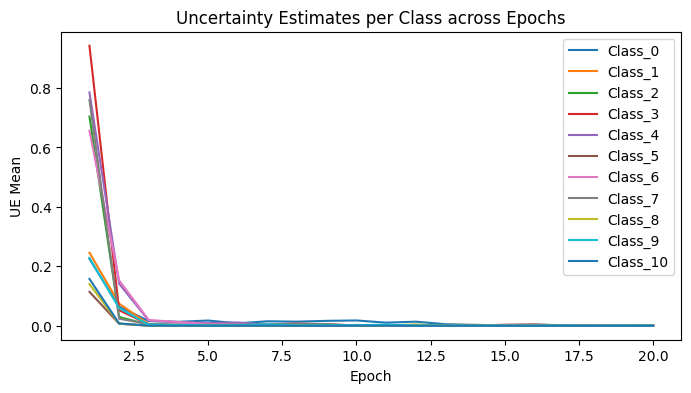

In [ ]:
# Plot UE per class across epochs
plt.figure(figsize=(8,4))
for c in ue_df.columns:
    plt.plot(ue_df.index, ue_df[c], label=c)
plt.xlabel("Epoch")
plt.ylabel("UE Mean")
plt.title("Uncertainty Estimates per Class across Epochs")
plt.legend()
plt.show()

In [ ]:
entropy_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.5424   0.5520   1.3629   2.1129   1.5500   0.2958   1.2342   1.4812   
2       0.1841   0.1996   0.0957   0.1463   0.3034   0.0255   0.3485   0.0792   
3       0.0525   0.0201   0.0140   0.0171   0.0567   0.0009   0.0577   0.0202   
4       0.0443   0.0053   0.0075   0.0148   0.0403   0.0001   0.0413   0.0051   
5       0.0523   0.0041   0.0060   0.0120   0.0310   0.0001   0.0228   0.0119   
6       0.0266   0.0033   0.0065   0.0058   0.0368   0.0001   0.0194   0.0142   
7       0.0437   0.0016   0.0068   0.0168   0.0129   0.0000   0.0060   0.0147   
8       0.0399   0.0011   0.0022   0.0245   0.0069   0.0000   0.0055   0.0252   
9       0.0447   0.0014   0.0058   0.0174   0.0112   0.0000   0.0094   0.0197   
10      0.0507   0.0054   0.0108   0.0025   0.0064   0.0000   0.0029   0.0040   
11      0.0309   0.0008   0.0031   0.0047   0.0063   0.0000   0.0016   0.0063   
12      0.0386   0.0016   0.0105   0.0040   0.0093   0.0000   0.0027   0.0031   
13      0.0180   0.0013   0.0057   0.0047   0.0041   0.0003   0.0023   0.0123   
14      0.0080   0.0005   0.0017   0.0022   0.0049   0.0001   0.0021   0.0120   
15      0.0088   0.0007   0.0051   0.0128   0.0033   0.0006   0.0029   0.0023   
16      0.0124   0.0005   0.0009   0.0138   0.0021   0.0002   0.0051   0.0025   
17      0.0068   0.0006   0.0013   0.0038   0.0029   0.0013   0.0051   0.0028   
18      0.0038   0.0002   0.0010   0.0033   0.0018   0.0002   0.0052   0.0004   
19      0.0052   0.0003   0.0010   0.0033   0.0012   0.0005   0.0079   0.0013   
20      0.0040   0.0005   0.0004   0.0059   0.0021   0.0005   0.0030   0.0077   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.3471   0.5151    0.3799  
2       0.0271   0.1549    0.0294  
3       0.0013   0.0132    0.0003  
4       0.0021   0.0113    0.0001  
5       0.0008   0.0046    0.0001  
6       0.0004   0.0080    0.0002  
7       0.0010   0.0159    0.0002  
8       0.0049   0.0055    0.0000  
9       0.0060   0.0063    0.0000  
10      0.0024   0.0069    0.0000  
11      0.0027   0.0143    0.0000  
12      0.0141   0.0028    0.0000  
13      0.0006   0.0029    0.0000  
14      0.0012   0.0021    0.0000  
15      0.0053   0.0039    0.0000  
16      0.0045   0.0014    0.0000  
17      0.0004   0.0031    0.0000  
18      0.0004   0.0011    0.0000  
19      0.0026   0.0037    0.0000  
20      0.0018   0.0013    0.0000

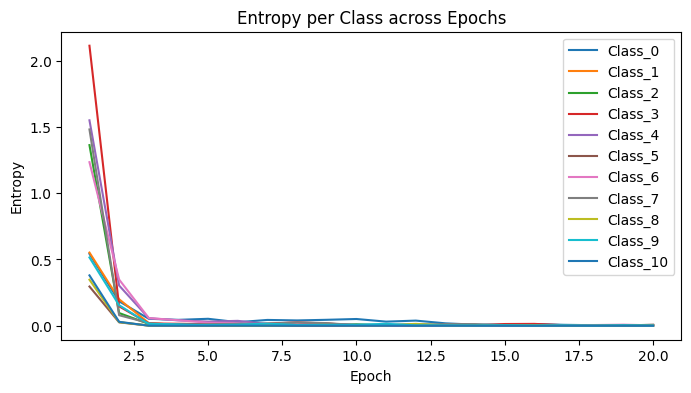

In [ ]:
# Plot entropy per class across epochs
plt.figure(figsize=(8,4))
for c in entropy_df.columns:
    plt.plot(entropy_df.index, entropy_df[c], label=c)
plt.xlabel("Epoch")
plt.ylabel("Entropy")
plt.title("Entropy per Class across Epochs")
plt.legend()
plt.show()

---

##### Evaluation

In [ ]:
def eval_ood_classification(model, data_loader, device, garbage_class_idx=10):
    model.eval()
    total = 0
    garbage_preds = 0

    id_confidences, id_ue, id_entropy, id_margin = [], [], [], []
    ood_confidences, ood_ue, ood_entropy, ood_margin = [], [], [], []
    all_preds = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            logits, features = model(images)
            probs = F.softmax(logits, dim=1)
            confidence, preds = torch.max(probs, dim=1)
            conf, margin, ue, entropy  = compute_metrics(logits)

            for p, c,  m, u, e in zip(preds.cpu().numpy(),
                                     confidence.cpu().numpy(),
                                     margin.cpu().numpy(),
                                     ue.cpu().numpy(),
                                     entropy.cpu().numpy()):

                if p == garbage_class_idx:
                    ood_confidences.append(c)
                    ood_margin.append(m)
                    ood_ue.append(u)
                    ood_entropy.append(e)

                else:
                    id_confidences.append(c)
                    id_margin.append(m)
                    id_ue.append(u)
                    id_entropy.append(e)

                all_preds.append(p)

            garbage_preds += (preds == garbage_class_idx).sum().item()
            total += images.size(0)

    garbage_rate = garbage_preds / total

    return {
        "garbage_rate": garbage_rate,
        "all_preds": all_preds,
        "id": {
            "confidence": id_confidences,
            "ue": id_ue,
            "entropy": id_entropy,
            "margin": id_margin,},
        "ood": {
            "confidence": ood_confidences,
            "ue": ood_ue,
            "entropy": ood_entropy,
            "margin": ood_margin,}
           }

In [ ]:
def garbage_rate_table(datasets_eval):
  garbage_table = pd.DataFrame({
    "Dataset": list(datasets_eval.keys()),
    "Garbage Rate (%)": [eval_dict['garbage_rate']*100 for eval_dict in datasets_eval.values()]})

  print("Garbage Rate Table")
  display(garbage_table)

In [ ]:
def metric_table(metric):
  table = {
        "Dataset": [],
        "ID Min": [], "ID Max": [], "ID Mean": [], "ID Std": [],
        "OOD Min": [], "OOD Max": [], "OOD Mean": [], "OOD Std": []
    }

  for name, eval_dict in datasets_eval.items():
      id_vals  = np.array(eval_dict['id'][metric])
      ood_vals = np.array(eval_dict['ood'][metric])

      table["Dataset"].append(name)
      table["ID Min"].append(np.min(id_vals) if len(id_vals) > 0 else np.nan)
      table["ID Max"].append(np.max(id_vals) if len(id_vals) > 0 else np.nan)
      table["ID Mean"].append(np.mean(id_vals) if len(id_vals) > 0 else np.nan)
      table["ID Std"].append(np.std(id_vals) if len(id_vals) > 0 else np.nan)

      table["OOD Min"].append(np.min(ood_vals) if len(ood_vals) > 0 else np.nan)
      table["OOD Max"].append(np.max(ood_vals) if len(ood_vals) > 0 else np.nan)
      table["OOD Mean"].append(np.mean(ood_vals) if len(ood_vals) > 0 else np.nan)
      table["OOD Std"].append(np.std(ood_vals) if len(ood_vals) > 0 else np.nan)

  df = pd.DataFrame(table)
  print(f"\n Metric: {metric.upper()}")
  display(df)
  # return df

In [ ]:
def garbage_rate_after_metric_threshold(model, data_loader, device, metric_name, threshold, garbage_class_idx=10):
    """Compute garbage rate given a metric and threshold"""
    model.eval()
    total = 0
    garbage_preds = 0

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            logits, _ = model(images)
            probs = F.softmax(logits, dim=1)
            confidence, preds = torch.max(probs, dim=1)

            # Compute metrics
            conf, margin, ue, entropy = compute_metrics(logits)

            metric_values = {
                "confidence": conf,
                "margin": margin,
                "ue": ue,
                "entropy": entropy
            }[metric_name]

            for p, m in zip(preds.cpu().numpy(), metric_values.cpu().numpy()):
                # Threshold rule
                if metric_name in ["confidence", "margin"]:
                    if p != garbage_class_idx:
                      if m < threshold:
                        garbage_preds += 1
                    else:
                        garbage_preds +=1
                else:  # entropy, ue → higher = OOD
                    if p != garbage_class_idx:
                      if m > threshold:
                        garbage_preds += 1
                    else:
                        garbage_preds +=1

            total += images.size(0)

    garbage_rate = garbage_preds / total
    return garbage_rate

In [ ]:
def garbage_rate_metric_threshold_table(model, datasets, device, metric_name, thresholds):
    results = []

    for t in thresholds:
        row = {"Threshold": t}
        for name, loader in datasets.items():
            rate = garbage_rate_after_metric_threshold(model, loader, device, metric_name, t)
            row[name] = rate * 100
        results.append(row)

    df = pd.DataFrame(results)

    # Format all numeric values to 2 decimal places
    df = df.round(2)

    print(f"\n Garbage Rate Table (in %): [{metric_name} Threshold]")
    display(df)

---

##### Tiny_Imagenet_200

In [ ]:
# folder_path = "/content/tiny-imagenet-200.zip"
# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

In [ ]:
! wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
! unzip tiny-imagenet-200.zip -d /content/ood_datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_9

In [ ]:
val_dir = "/content/ood_datasets/tiny-imagenet-200/val"
images_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")

with open(ann_file, "r") as f:
    for line in f.readlines():
        img, cls = line.strip().split("\t")[:2]
        cls_dir  = os.path.join(val_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)
        shutil.move(os.path.join(images_dir, img), os.path.join(cls_dir, img))

shutil.rmtree(images_dir)

#### Using fmnist Statistics for all ood datasets

In [ ]:
# MNIST normalization stats
fmnist_mean  = 0.2860
fmnist_std   = 0.3530

# Transform for ood datasets
ood_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(fmnist_mean, fmnist_std)
])

In [ ]:
# ------------------ Grayscale datasets ------------------
mnist_testset  = datasets.MNIST(root='/content/ood_datasets/MNIST', train=False, download=True, transform=ood_transform)

# ------------------ RGB datasets ------------------
cifar10_testset = datasets.CIFAR10(root='/content/ood_datasets/CIFAR10', train= False, download=True, transform=ood_transform)
svhn_testset    = datasets.SVHN(root='/content/ood_datasets/SVHN', split='test', download=True, transform=ood_transform)
cifar100_testset = datasets.CIFAR100(root='/content/ood_datasets/CIFAR100', train=False, download=True, transform=ood_transform)

# TinyImageNet (resize to 32×32) – validation split
tinyimagenet_val    = datasets.ImageFolder(root='/content/ood_datasets/tiny-imagenet-200/val', transform=ood_transform)

# # LSUN (classroom / resize) – one or more classes
# lsun_val            = datasets.ImageFolder(root=os.path.join(lsun_data_dir, "classroom_val"), transform=ood_transform)

# CelebA – center crop then resize
# celeba_val          = datasets.CelebA(root='/content/ood_datasets', split='test', download=True,
#                                       transform=transforms.Compose([
#                                           transforms.CenterCrop(148),
#                                           transforms.Resize((32, 32)),
#                                           transforms.ToTensor(),
#                                           transforms.Normalize(cifar_mean, cifar_std)
#                                       ]))


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.79MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.12MB/s]
100%|██████████| 170M/170M [00:01<00:00, 105MB/s]
100%|██████████| 64.3M/64.3M [00:05<00:00, 12.7MB/s]
100%|██████████| 169M/169M [00:03<00:00, 51.8MB/s]


In [ ]:
# ------------------ DataLoaders ------------------
batch_size = 32
mnist_loader       = DataLoader(mnist_testset,      batch_size=batch_size, shuffle=False)
cifar10_loader     = DataLoader(cifar10_testset,    batch_size=batch_size, shuffle=False)
svhn_loader        = DataLoader(svhn_testset,       batch_size=batch_size, shuffle=False)
cifar100_loader    = DataLoader(cifar100_testset,   batch_size=batch_size, shuffle=False)
tiny_loader        = DataLoader(tinyimagenet_val,   batch_size=batch_size, shuffle=False)
# lsun_loader      = DataLoader(lsun_val,           batch_size=batch_size, shuffle=False)
# celeba_loader      = DataLoader(celeba_val,       batch_size=batch_size, shuffle=False)

#### Before Inversion

In [ ]:
model_before_inv_pth = os.path.join(saved_model_dir, "checkpoint_csf_initial.pt")
checkpoint = torch.load(model_before_inv_pth,map_location='cpu')
nc = 1
ncf = 64

model_before_inv = Classifier(nc, ncf)
model_before_inv.load_state_dict(checkpoint['model_state_dict'])
model_before_inv.to(device)
model_before_inv.eval()

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (penultimate): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  

In [ ]:
csf_criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy   = test(model_before_inv,  test_loader, csf_criterion, device)
print(f"\nTest Loss:{test_loss:.4f},  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, Batch Loss=0.231]


Test Loss:0.5393,  Test Accuracy: 0.7962


In [ ]:
eval_fmnist     = eval_ood_classification(model_before_inv, test_loader, device)
eval_mnist      = eval_ood_classification(model_before_inv, mnist_loader,  device)
eval_cifar10    = eval_ood_classification(model_before_inv, cifar10_loader,  device)
eval_svhn       = eval_ood_classification(model_before_inv, svhn_loader,   device)
eval_cifar100   = eval_ood_classification(model_before_inv, cifar100_loader,   device)
eval_tiny_imagenet200  = eval_ood_classification(model_before_inv, tiny_loader, device)
# eval_celeba     = eval_ood_classification(model_before_inv, celeba_loader,   device)

In [ ]:
# List of datasets
datasets_eval = {
    "FMNIST": eval_fmnist,
    "MNIST": eval_mnist,
    "CIFAR-10": eval_cifar10,
    "SVHN": eval_svhn,
    "CIFAR-100": eval_cifar100,
    "TinyImageNet200": eval_tiny_imagenet200,
    # "CelebA": eval_celeba,
}

In [ ]:
garbage_rate_table(datasets_eval)

Garbage Rate Table


Dataset  Garbage Rate (%)
0           FMNIST           0.02000
1            MNIST           0.00000
2         CIFAR-10          81.08000
3             SVHN          70.36724
4        CIFAR-100          77.65000
5  TinyImageNet200          74.18000

In [ ]:
metric_table('confidence')


 Metric: CONFIDENCE


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0           FMNIST  0.200777  0.999969  0.786127  0.213182  0.447007   
1            MNIST  0.172354  0.999841  0.877730  0.174359       NaN   
2         CIFAR-10  0.163916  0.998709  0.560909  0.208586  0.210757   
3             SVHN  0.149558  0.981116  0.459990  0.177422  0.172949   
4        CIFAR-100  0.169026  0.998850  0.550418  0.199195  0.190667   
5  TinyImageNet200  0.156480  0.999435  0.560269  0.213076  0.180028   

    OOD Max  OOD Mean   OOD Std  
0  0.737762  0.592385  0.145378  
1       NaN       NaN       NaN  
2  0.999092  0.815977  0.172081  
3  0.997169  0.811075  0.183519  
4  0.998845  0.817797  0.175900  
5  0.999094  0.809841  0.181839

In [ ]:
metric_table('margin')


 Metric: MARGIN


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0           FMNIST  0.000114  0.999947  0.660294  0.331591  0.256215   
1            MNIST  0.000063  0.999788  0.820323  0.259002       NaN   
2         CIFAR-10  0.000063  0.998252  0.357277  0.291629  0.000373   
3             SVHN  0.000033  0.975178  0.228629  0.207936  0.000017   
4        CIFAR-100  0.000225  0.998553  0.338505  0.272881  0.000497   
5  TinyImageNet200  0.000166  0.999245  0.368778  0.290790  0.000015   

    OOD Max  OOD Mean   OOD Std  
0  0.579764  0.417989  0.161775  
1       NaN       NaN       NaN  
2  0.998877  0.720222  0.265560  
3  0.996259  0.712099  0.275990  
4  0.998477  0.723083  0.270481  
5  0.998793  0.714783  0.274039

In [ ]:
metric_table('ue')


 Metric: UE


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0           FMNIST  0.000069  0.950135  0.325669  0.281508  0.471150   
1            MNIST  0.000350  0.955766  0.202784  0.248953       NaN   
2         CIFAR-10  0.002838  0.974543  0.625199  0.240540  0.001996   
3             SVHN  0.041062  0.972568  0.734629  0.181066  0.006217   
4        CIFAR-100  0.002529  0.967382  0.639515  0.223125  0.002540   
5  TinyImageNet200  0.001244  0.973078  0.629928  0.245912  0.001993   

    OOD Max  OOD Mean   OOD Std  
0  0.799572  0.635361  0.164211  
1       NaN       NaN       NaN  
2  0.941411  0.308838  0.238972  
3  0.962332  0.311077  0.248781  
4  0.962390  0.303934  0.243883  
5  0.962748  0.315645  0.250961

In [ ]:
metric_table('entropy')


 Metric: ENTROPY


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0           FMNIST  0.000389  2.116177  0.599650  0.488413  0.935860   
1            MNIST  0.001828  2.082222  0.436177  0.480395       NaN   
2         CIFAR-10  0.012269  2.247957  1.237982  0.498991  0.008885   
3             SVHN  0.125577  2.246928  1.472129  0.456098  0.024795   
4        CIFAR-100  0.011210  2.229834  1.261269  0.483006  0.011074   
5  TinyImageNet200  0.005720  2.244395  1.267134  0.518630  0.008807   

    OOD Max  OOD Mean   OOD Std  
0  1.590418  1.263139  0.327279  
1       NaN       NaN       NaN  
2  2.088914  0.636139  0.443919  
3  2.183071  0.637864  0.473251  
4  2.197201  0.627522  0.457400  
5  2.208539  0.654906  0.476797

### After Inversion

##### Evaluating the model with best test accuracy

In [ ]:
model_after_inv_pth = os.path.join(saved_model_dir,'csf_model.pth')
nc = 1
ncf = 64

model_after_inv = Classifier(nc, ncf)
model_after_inv.load_state_dict(torch.load(model_after_inv_pth, map_location=device))
model_after_inv.to(device)
model_after_inv.eval()

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (penultimate): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  

In [ ]:
test_loss, test_accuracy   = test(model_after_inv,  test_loader, csf_criterion, device)
print(f"\nTest Loss:{test_loss:.4f},  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 313/313 [00:14<00:00, 20.88it/s, Batch Loss=0.00337]


Test Loss:0.2672,  Test Accuracy: 0.9043


In [ ]:
eval_fmnist      = eval_ood_classification(model_after_inv, test_loader, device)
eval_mnist       = eval_ood_classification(model_after_inv, mnist_loader,  device)
eval_cifar10     = eval_ood_classification(model_after_inv, cifar10_loader,  device)
eval_svhn        = eval_ood_classification(model_after_inv, svhn_loader,   device)
eval_cifar100    = eval_ood_classification(model_after_inv, cifar100_loader,   device)
eval_tiny_imagenet200  = eval_ood_classification(model_after_inv, tiny_loader, device)
# eval_celeba     = eval_ood_classification(model_before_inv, celeba_loader,   device)

In [ ]:
# List of datasets
datasets_eval = {
    "FMNIST": eval_fmnist,
    "MNIST": eval_mnist,
    "CIFAR-10": eval_cifar10,
    "SVHN": eval_svhn,
    "CIFAR-100": eval_cifar100,
    "TinyImageNet200": eval_tiny_imagenet200,
    # "CelebA": eval_celeba,
}

In [ ]:
garbage_rate_table(datasets_eval)

Garbage Rate Table


Dataset  Garbage Rate (%)
0           FMNIST          0.000000
1            MNIST          2.210000
2         CIFAR-10         98.000000
3             SVHN         84.365396
4        CIFAR-100         96.990000
5  TinyImageNet200         95.470000

In [ ]:
metric_table('confidence')


 Metric: CONFIDENCE


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  OOD Max  \
0           FMNIST  0.260806  1.000000  0.944863  0.121488       NaN      NaN   
1            MNIST  0.186863  1.000000  0.806739  0.208841       NaN      NaN   
2         CIFAR-10  0.176849  0.999983  0.701895  0.211249  0.221219      1.0   
3             SVHN  0.201300  0.999752  0.609129  0.185108  0.204451      1.0   
4        CIFAR-100  0.203659  0.999998  0.684596  0.217896  0.226958      1.0   
5  TinyImageNet200  0.204600  1.000000  0.717408  0.215385  0.271400      1.0   

   OOD Mean   OOD Std  
0       NaN       NaN  
1       NaN       NaN  
2  0.949325  0.115266  
3  0.928946  0.134310  
4  0.951175  0.114771  
5  0.941239  0.121765

In [ ]:
metric_table('margin')


 Metric: MARGIN


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  OOD Max  \
0           FMNIST  0.000288  1.000000  0.898073  0.222928       NaN      NaN   
1            MNIST  0.000037  1.000000  0.690208  0.328433       NaN      NaN   
2         CIFAR-10  0.000069  0.999977  0.517548  0.326235  0.000686      1.0   
3             SVHN  0.000136  0.999562  0.405059  0.274663  0.000828      1.0   
4        CIFAR-100  0.000141  0.999997  0.502471  0.326508  0.000248      1.0   
5  TinyImageNet200  0.000051  0.999999  0.545548  0.332448  0.001211      1.0   

   OOD Mean   OOD Std  
0       NaN       NaN  
1       NaN       NaN  
2  0.912038  0.195701  
3  0.882621  0.215027  
4  0.916109  0.192347  
5  0.897943  0.208548

In [ ]:
metric_table('ue')


 Metric: UE


Dataset        ID Min    ID Max   ID Mean    ID Std  OOD Min  \
0           FMNIST  0.000000e+00  0.872720  0.086689  0.172339      NaN   
1            MNIST  0.000000e+00  0.956502  0.295765  0.284484      NaN   
2         CIFAR-10  3.653765e-05  0.933515  0.440918  0.265456      0.0   
3             SVHN  5.443692e-04  0.941999  0.577224  0.211685      0.0   
4        CIFAR-100  5.066395e-06  0.932613  0.464612  0.272803      0.0   
5  TinyImageNet200  8.344650e-07  0.942570  0.419772  0.275248      0.0   

    OOD Max  OOD Mean   OOD Std  
0       NaN       NaN       NaN  
1       NaN       NaN       NaN  
2  0.909229  0.083767  0.168492  
3  0.938057  0.118850  0.197586  
4  0.926502  0.080704  0.169228  
5  0.904309  0.096981  0.178635

In [ ]:
metric_table('entropy')


 Metric: ENTROPY


Dataset        ID Min    ID Max   ID Mean    ID Std       OOD Min  \
0           FMNIST  9.654872e-12  1.694259  0.140860  0.261940           NaN   
1            MNIST  2.057672e-08  2.092652  0.539935  0.504870           NaN   
2         CIFAR-10  2.229640e-04  1.992545  0.793827  0.497619  1.520010e-06   
3             SVHN  2.545295e-03  2.039323  1.083457  0.401676  5.634873e-07   
4        CIFAR-100  3.586373e-05  2.043015  0.854711  0.518686  1.380140e-07   
5  TinyImageNet200  6.776539e-06  2.065665  0.760752  0.511840  2.517100e-07   

    OOD Max  OOD Mean   OOD Std  
0       NaN       NaN       NaN  
1       NaN       NaN       NaN  
2  1.903332  0.154929  0.293402  
3  2.030388  0.228744  0.357818  
4  2.009774  0.149992  0.298726  
5  1.855110  0.177690  0.308140

#### Applying Threshold

In [ ]:
datasets = {
    "FMNIST": test_loader,
    "MNIST": mnist_loader,
    "CIFAR-10": cifar10_loader,
    "SVHN": svhn_loader,
    "CIFAR-100": cifar100_loader,
    "TinyImageNet200": tiny_loader,
    # "CelebA": celeba_loader,
}

##### Conf_Threshold

In [ ]:
conf_thresholds = [0.8,0.9,0.95]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"confidence", conf_thresholds)


 Garbage Rate Table (in %): [confidence Threshold]


Threshold  FMNIST  MNIST  CIFAR-10   SVHN  CIFAR-100  TinyImageNet200
0       0.80   41.74  21.28     96.83  98.41      96.89            95.55
1       0.90   53.19  31.84     98.28  99.88      98.68            97.73
2       0.95   65.08  43.74     98.95  99.98      99.31            98.59

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"confidence", conf_thresholds)


 Garbage Rate Table (in %): [confidence Threshold]


Threshold  FMNIST  MNIST  CIFAR-10    SVHN  CIFAR-100  TinyImageNet200
0       0.80   15.66  46.88     99.74   99.93      99.56            98.89
1       0.90   22.70  58.86     99.91   99.99      99.74            99.34
2       0.95   29.23  67.56     99.93  100.00      99.81            99.61

##### Margin_Threshold

In [ ]:
margin_thresholds = [0.8, 0.9, 0.95]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"margin", margin_thresholds)


 Garbage Rate Table (in %): [margin Threshold]


Threshold  FMNIST  MNIST  CIFAR-10   SVHN  CIFAR-100  TinyImageNet200
0       0.80   49.95  26.68     97.78  99.74      98.12            97.01
1       0.90   61.83  38.07     98.61  99.95      99.05            98.26
2       0.95   72.80  50.84     99.25  99.99      99.45            98.87

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"margin", margin_thresholds)


 Garbage Rate Table (in %): [margin Threshold]


Threshold  FMNIST  MNIST  CIFAR-10    SVHN  CIFAR-100  TinyImageNet200
0       0.80   21.97  54.84     99.87   99.98      99.67            99.23
1       0.90   28.42  64.53     99.92  100.00      99.79            99.54
2       0.95   34.87  72.06     99.95  100.00      99.87            99.70

##### UE Threshold

In [ ]:
ue_thresholds = [0.05,0.1,0.3,0.5]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"ue", ue_thresholds)


 Garbage Rate Table (in %): [ue Threshold]


Threshold  FMNIST  MNIST  CIFAR-10    SVHN  CIFAR-100  TinyImageNet200
0       0.05   76.71  58.96     99.51  100.00      99.63            99.26
1       0.10   66.03  44.87     99.03   99.98      99.36            98.62
2       0.30   46.17  25.46     97.60   99.46      97.84            96.55
3       0.50   33.50  16.63     95.25   96.08      94.88            93.51

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"ue", ue_thresholds)


 Garbage Rate Table (in %): [ue Threshold]


Threshold  FMNIST  MNIST  CIFAR-10    SVHN  CIFAR-100  TinyImageNet200
0       0.05   36.52  75.47     99.98  100.00      99.91            99.77
1       0.10   29.81  68.34     99.93  100.00      99.83            99.61
2       0.30   18.08  52.05     99.85   99.98      99.66            99.10
3       0.50   10.01  37.75     99.59   99.66      99.29            98.51

##### Entropy_Threshold

In [ ]:
entropy_thresholds = [0.1, 0.3, 0.5]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"entropy", entropy_thresholds)


 Garbage Rate Table (in %): [entropy Threshold]


Threshold  FMNIST  MNIST  CIFAR-10    SVHN  CIFAR-100  TinyImageNet200
0        0.1   81.42  67.66     99.68  100.00      99.74            99.51
1        0.3   60.72  42.18     98.88   99.97      99.25            98.47
2        0.5   49.16  31.24     98.20   99.82      98.48            97.53

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"entropy", entropy_thresholds)


 Garbage Rate Table (in %): [entropy Threshold]


Threshold  FMNIST  MNIST  CIFAR-10    SVHN  CIFAR-100  TinyImageNet200
0        0.1   38.80  79.10     99.98  100.00      99.94            99.85
1        0.3   25.37  65.37     99.92  100.00      99.79            99.54
2        0.5   18.05  56.42     99.87   99.99      99.70            99.24

### AUROC, AUPR, FPR@95TPR
* AUROC (Area Under ROC Curve) → measures overall separability between ID vs OOD.

* AUPR (Area Under Precision-Recall Curve) → emphasizes precision when positives are rare.

* FPR@95TPR → false positive rate when true positive rate = 95%.

##### Helper Functions

In [ ]:
def compute_auroc_aupr_fpr95(id_scores, ood_scores):
    """
    Compute AUROC, AUPR, and FPR@95TPR
    Label convention: 0 = ID, 1 = OOD
    """
    y_true  = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
    y_score = np.concatenate([id_scores, ood_scores])

    # AUROC
    try:
        auroc = roc_auc_score(y_true, y_score)
    except:
        auroc = np.nan

    # AUPR
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        aupr = auc(recall, precision)
    except:
        aupr = np.nan

    # FPR@95TPR
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        idx = np.where(tpr >= 0.95)[0]
        fpr95 = fpr[idx[0]] if len(idx) > 0 else 1.0
    except:
        fpr95 = np.nan

    return round(auroc, 4), round(aupr, 4), round(fpr95, 4), fpr, tpr, precision, recall

In [ ]:
def compute_mahalanobis_stats(model, loader, device):
    model.eval()
    all_feats, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _,feats = model(x)
            all_feats.append(feats)
            all_labels.append(y)

    feats = torch.cat(all_feats)
    labels = torch.cat(all_labels)
    num_classes = len(torch.unique(labels))

    class_means = []
    for c in range(num_classes):
        class_feats = feats[labels == c]
        class_means.append(class_feats.mean(0))

    cov = torch.cov(feats.T)
    cov_inv = torch.inverse(cov + 1e-5 * torch.eye(cov.shape[0], device=device))

    return class_means, cov_inv

In [ ]:
# Mahalanobis (requires precomputed class means + covariance inverse)
def score_mahalanobis(features, class_means, cov_inv):
    dists = []
    for mu_c in class_means:
        diff = features - mu_c
        dist = torch.einsum('bi,ij,bj->b', diff, cov_inv, diff)
        dists.append(dist)
    return -torch.min(torch.stack(dists, dim=1), dim=1)[0]  # negative = higher confidence

In [ ]:
def get_metric_scores(exclude_garbage, model, data_loader, device, metric_name, temperature=1.0,
                               class_means=None, cov_inv=None):
    """
    Get metric scores for a dataset.
    Supports: confidence, margin, ue, entropy, energy, msp, odin, mahalanobis
    """
    model.eval()
    metric_scores = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            logits, feats = model(images)

            if exclude_garbage:
                logits = logits[:, :10]

            if metric_name in ["confidence", "margin", "ue", "entropy"]:
                confidence, margin, ue, entropy = compute_metrics(logits)
                metric_values = {
                    "confidence": confidence,
                    "margin": margin,
                    "ue": ue,
                    "entropy": entropy
                }[metric_name]

            elif metric_name == "energy":
                metric_values = -temperature * torch.logsumexp(logits / temperature, dim=1)

            elif metric_name == "msp":
                metric_values = torch.max(F.softmax(logits, dim=1), dim=1)[0]

            elif metric_name == "odin":
                metric_values = torch.max(F.softmax(logits / temperature, dim=1), dim=1)[0]

            elif metric_name == "mahalanobis":
                if class_means is None or cov_inv is None:
                    raise ValueError("class_means and cov_inv must be provided for Mahalanobis score")
                metric_values = score_mahalanobis(feats, class_means, cov_inv)

            else:
                raise ValueError(f"Unknown metric_name: {metric_name}")

            metric_scores.extend(metric_values.cpu().numpy())

    return np.array(metric_scores)

In [ ]:
def comprehensive_ood_analysis(exclude_garbage, model, datasets, device, metric_name, id_name,
                                        temperature=1.0, class_means=None, cov_inv=None):
    """
    Comprehensive OOD analysis supporting multiple metrics including Mahalanobis.
    """
    if exclude_garbage:
        print(f"COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - {metric_name.upper()}")
    else:
        print(f"COMPREHENSIVE OOD ANALYSIS (Garbage class included) - {metric_name.upper()}")

    # Get ID scores
    id_scores = get_metric_scores(exclude_garbage, model, datasets[id_name], device,
                                           metric_name, temperature, class_means, cov_inv)

    results = []

    for ood_name, ood_loader in datasets.items():
        if ood_name == id_name:
            continue

        ood_scores = get_metric_scores(exclude_garbage, model, ood_loader, device,
                                                metric_name, temperature, class_means, cov_inv)

        flip_sign = -1 if metric_name in ["msp", "odin", "mahalanobis"] else 1
        id_eval = id_scores * flip_sign
        ood_eval = ood_scores * flip_sign

        auroc, aupr, fpr_95tpr, fpr, tpr, precision, recall = compute_auroc_aupr_fpr95(id_eval, ood_eval)
        id_mean = np.mean(id_scores)
        ood_mean = np.mean(ood_scores)
        separation = abs(id_mean - ood_mean)

        results.append({
            'OOD Dataset': ood_name,
            'AUROC': auroc,
            'AUPR': aupr,
            'FPR@95TPR': fpr_95tpr,
            f'ID {metric_name} Mean': round(id_mean, 4),
            f'OOD {metric_name} Mean': round(ood_mean, 4),
            'Separation': round(separation, 4),
            'FPR_curve': fpr,
            'TPR_curve': tpr,
            'Precision_curve': precision,
            'Recall_curve': recall,
            'ID_scores': id_scores,
            'OOD_scores':ood_scores
        })

    df_summary = pd.DataFrame([{k: r[k] for k in ['OOD Dataset', 'AUROC', 'AUPR', 'FPR@95TPR',
                                                  f'ID {metric_name} Mean', f'OOD {metric_name} Mean',
                                                  'Separation']} for r in results])
    display(df_summary)
    print(f"\nAvg AUROC = {df_summary['AUROC'].mean():.4f} | "
          f"Avg AUPR = {df_summary['AUPR'].mean():.4f} | "
          f"Avg FPR@95TPR = {df_summary['FPR@95TPR'].mean():.4f}")

    return df_summary, results

In [ ]:
def plot_ood_metrics(df, metric_name):
    """
    Plots AUROC, AUPR, and FPR@95TPR results for OOD analysis
    """
    sns.set(style="whitegrid", font_scale=1.1)
    fig, axes = plt.subplots(1, 3, figsize=(25, 6))

    # --- AUROC ---
    sns.barplot(
        data=df,
        x="OOD Dataset",
        y="AUROC",
        ax=axes[0],
        palette="Blues_d",
        hue = "OOD Dataset",
        legend=False
    )
    axes[0].set_title(f"{metric_name.upper()} - AUROC", fontsize=14, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for i, val in enumerate(df["AUROC"]):
        axes[0].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

    # --- AUPR ---
    sns.barplot(
        data=df,
        x="OOD Dataset",
        y="AUPR",
        ax=axes[1],
        palette="Greens_d",
         hue = "OOD Dataset",
        legend=False
    )
    axes[1].set_title(f"{metric_name.upper()} - AUPR", fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 1)
    for i, val in enumerate(df["AUPR"]):
        axes[1].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

    # --- FPR@95TPR ---
    sns.barplot(
        data=df,
        x="OOD Dataset",
        y="FPR@95TPR",
        ax=axes[2],
        palette="Reds_d",
        hue = "OOD Dataset",
        legend=False
    )
    axes[2].set_title(f"{metric_name.upper()} - FPR@95TPR", fontsize=14, fontweight='bold')
    axes[2].set_ylim(0, 1)
    for i, val in enumerate(df["FPR@95TPR"]):
        axes[2].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_ood_curves(results, metric_name):
    """
    Plots ROC and PR curves for each OOD dataset.
    """
    sns.set(style="whitegrid", font_scale=1.1)
    fig, axes = plt.subplots(1, 2, figsize=(25, 6))

    # --- ROC Curves ---
    for res in results:
        axes[0].plot(
            res['FPR_curve'], res['TPR_curve'],
            label=f"{res['OOD Dataset']} (AUROC={res['AUROC']:.3f})"
        )
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[0].set_title(f"{metric_name.upper()} - ROC Curve", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()
    axes[0].grid(True)

    # --- Precision-Recall Curves ---
    for res in results:
        axes[1].plot(
            res['Recall_curve'], res['Precision_curve'],
            label=f"{res['OOD Dataset']} (AUPR={res['AUPR']:.3f})"
        )
    axes[1].set_title(f"{metric_name.upper()} - Precision-Recall Curve", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_metric_comparison(df, metric_label):
    df_melt = df.melt(id_vars="OOD Dataset", var_name="Method", value_name=metric_label)
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_melt, x="OOD Dataset", y=metric_label, hue="Method")
    plt.title(f"{metric_label} Comparison Across Methods", fontsize=14, fontweight='bold')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.show()

In [ ]:
def plot_separation_for_method(results, method_name, target_tpr=0.95, bins=50):
    """
    Plots score separation for a method across all OOD datasets (like Energy paper).

    Parameters:
        results: list of dicts returned by comprehensive_ood_analysis_with_scores
        method_name: str, name of the metric
        target_tpr: float, TPR to compute threshold
        bins: int, histogram bins
    """
    num_ood = len(results)
    fig, axes = plt.subplots(1, num_ood, figsize=(6*num_ood, 5), sharey=True)

    if num_ood == 1:
        axes = [axes]

    for ax, res in zip(axes, results):

        id_scores  = res['ID_scores']
        ood_scores = res['OOD_scores']

        flip_sign=-1 if method_name in ["msp","odin","mahalanobis"] else 1
        id_scores  = flip_sign*id_scores
        ood_scores = flip_sign*ood_scores

        # Compute threshold for target TPR
        y_true = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
        y_score = np.concatenate([id_scores, ood_scores])
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        idx = np.where(tpr >= target_tpr)[0]
        threshold = thresholds[idx[0]] if len(idx) > 0 else thresholds[-1]

        # Plot ID and OOD distributions
        sns.histplot(id_scores, color='blue', kde=True, stat='density', bins=bins, alpha=0.6, ax=ax, label='ID')
        sns.histplot(ood_scores, color='red', kde=True, stat='density', bins=bins, alpha=0.6, ax=ax, label='OOD')
        ax.axvline(threshold, color='black', linestyle='--', label=f'Threshold (TPR={target_tpr*100:.0f}%, Threshold={threshold:0.6f})')
        ax.set_title(res['OOD Dataset'], fontsize=14, fontweight='bold')
        ax.set_xlabel("Score")
        ax.set_ylabel("Density")
        ax.legend()

    plt.suptitle(f"Score Separation - {method_name}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
datasets = {
    "FMNIST": test_loader,
    "MNIST": mnist_loader,
    "CIFAR-10": cifar10_loader,
    "SVHN": svhn_loader,
    "CIFAR-100": cifar100_loader,
    "TinyImageNet200": tiny_loader,
    # "CelebA": celeba_loader,
}

In [ ]:
model_after_inv_pth = os.path.join(saved_model_dir,'csf_model.pth')
nc = 1
ncf = 64

model_after_inv = Classifier(nc, ncf)
model_after_inv.load_state_dict(torch.load(model_after_inv_pth, map_location=device))
model_after_inv.to(device)
model_after_inv.eval()

##### Excluding Garbage class

In [ ]:
id_name = "FMNIST"

In [ ]:
# Compute class statistics from ID dataset
class_means, cov_inv = compute_mahalanobis_stats(model_after_inv, datasets[id_name], device)

In [ ]:
exclude_garbage = True
temperature = 1000.0

###### UE

In [ ]:
metric = "ue"

In [ ]:
df_ue, results_ue = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - UE


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID ue Mean  OOD ue Mean  \
0            MNIST  0.7623  0.7575     0.6677      0.1247       0.3441   
1         CIFAR-10  0.9566  0.9533     0.1971      0.1247       0.6800   
2             SVHN  0.9747  0.9884     0.1322      0.1247       0.7291   
3        CIFAR-100  0.9562  0.9535     0.2053      0.1247       0.6813   
4  TinyImageNet200  0.9465  0.9444     0.2424      0.1247       0.6597   

   Separation  
0      0.2194  
1      0.5553  
2      0.6044  
3      0.5567  
4      0.5350


Avg AUROC = 0.9193 | Avg AUPR = 0.9194 | Avg FPR@95TPR = 0.2889


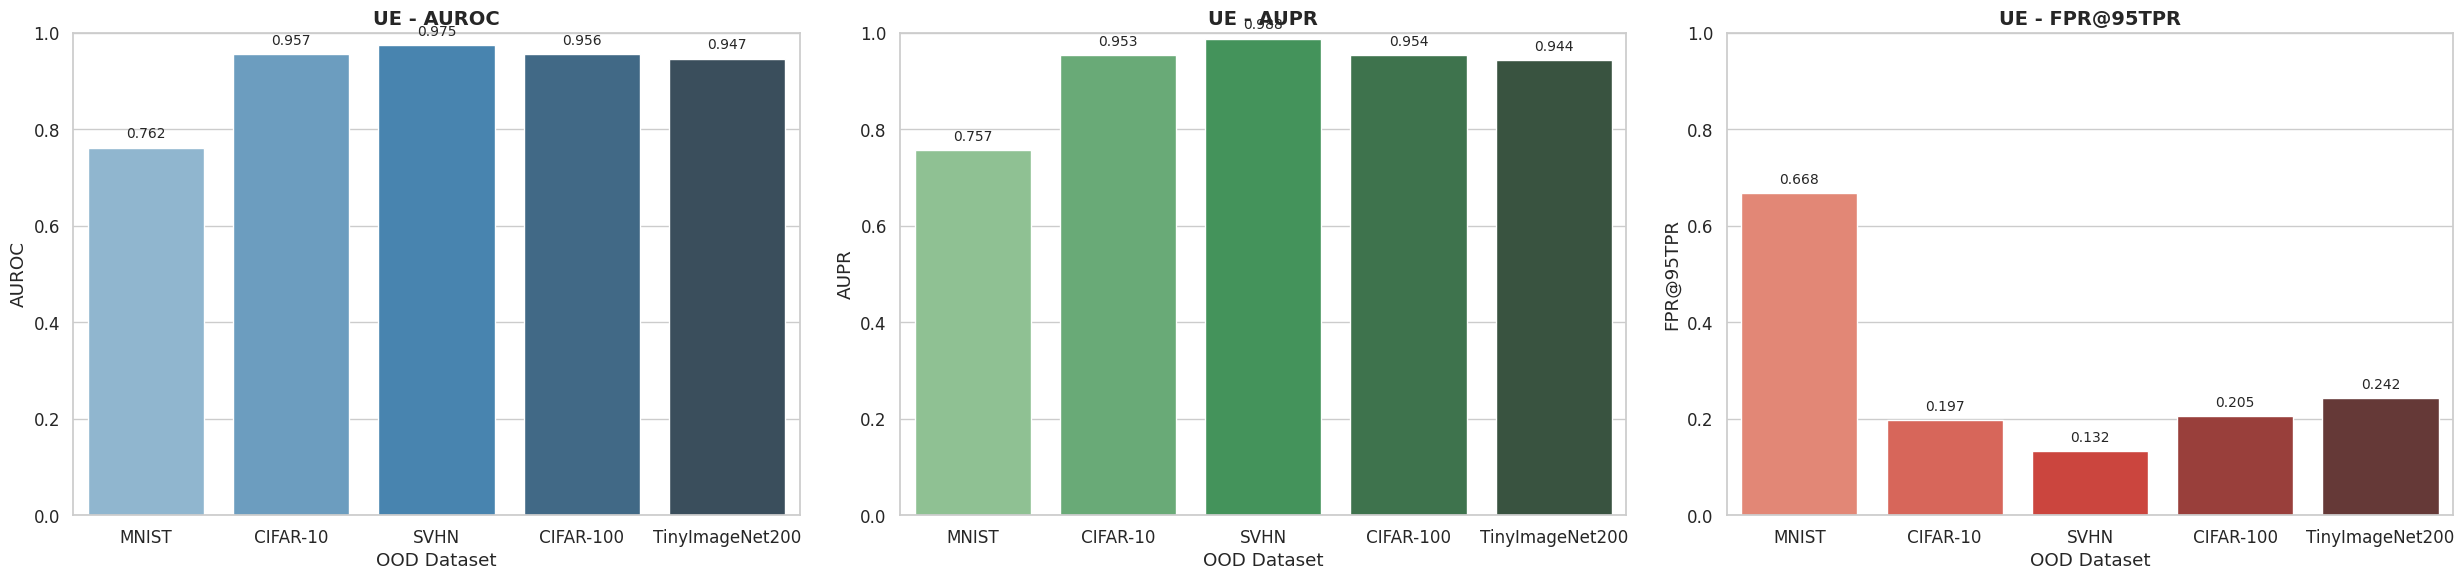

In [ ]:
plot_ood_metrics(df_ue, metric)

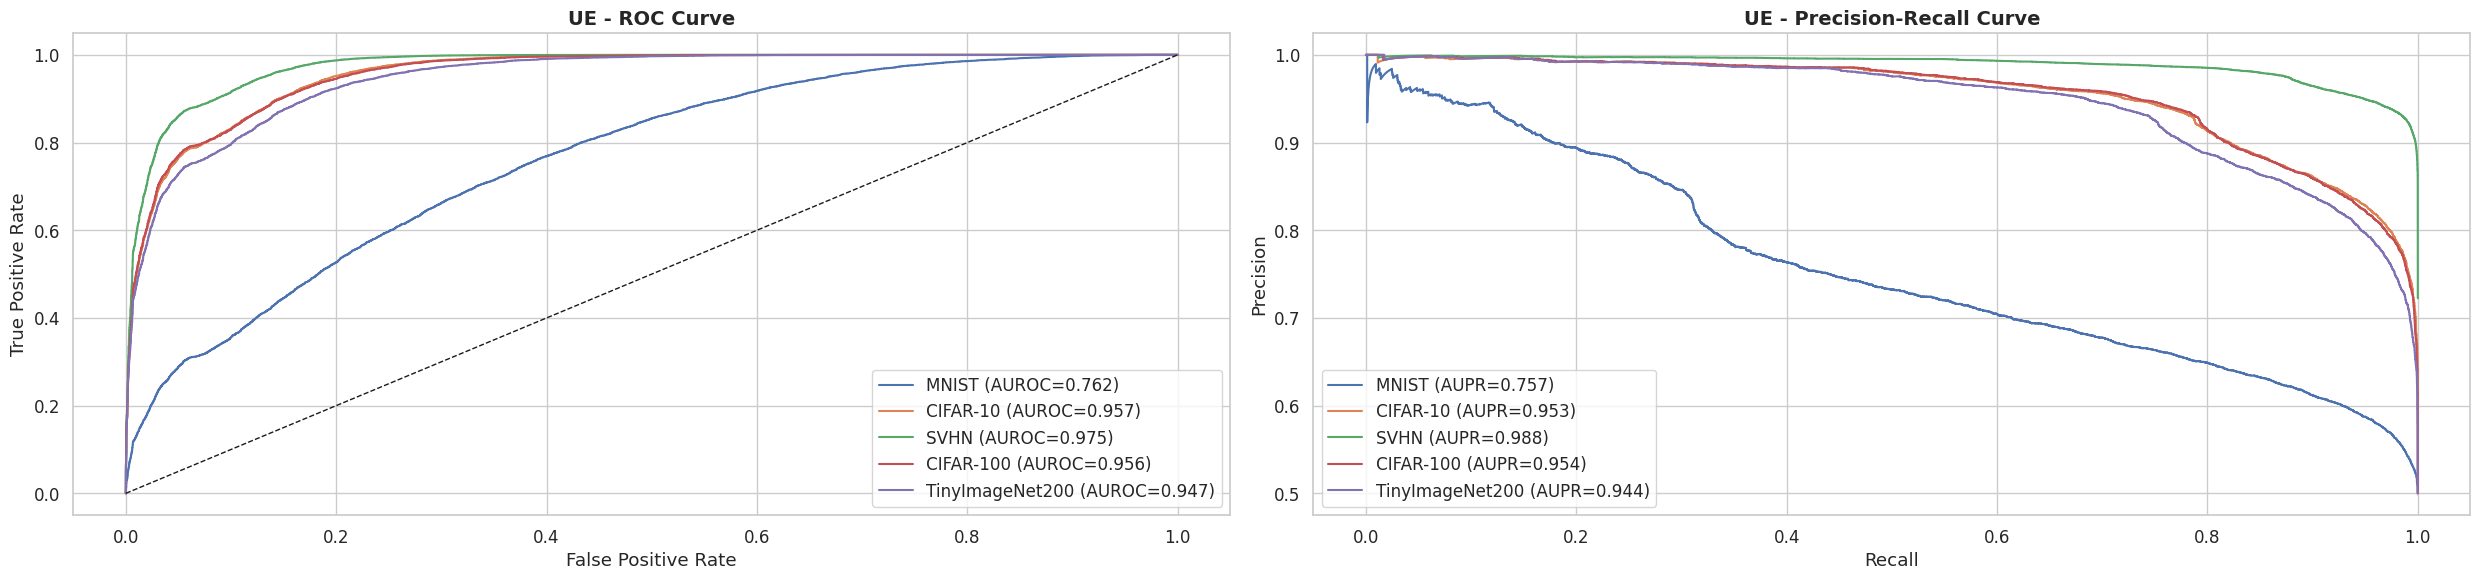

In [ ]:
plot_ood_curves(results_ue, metric)

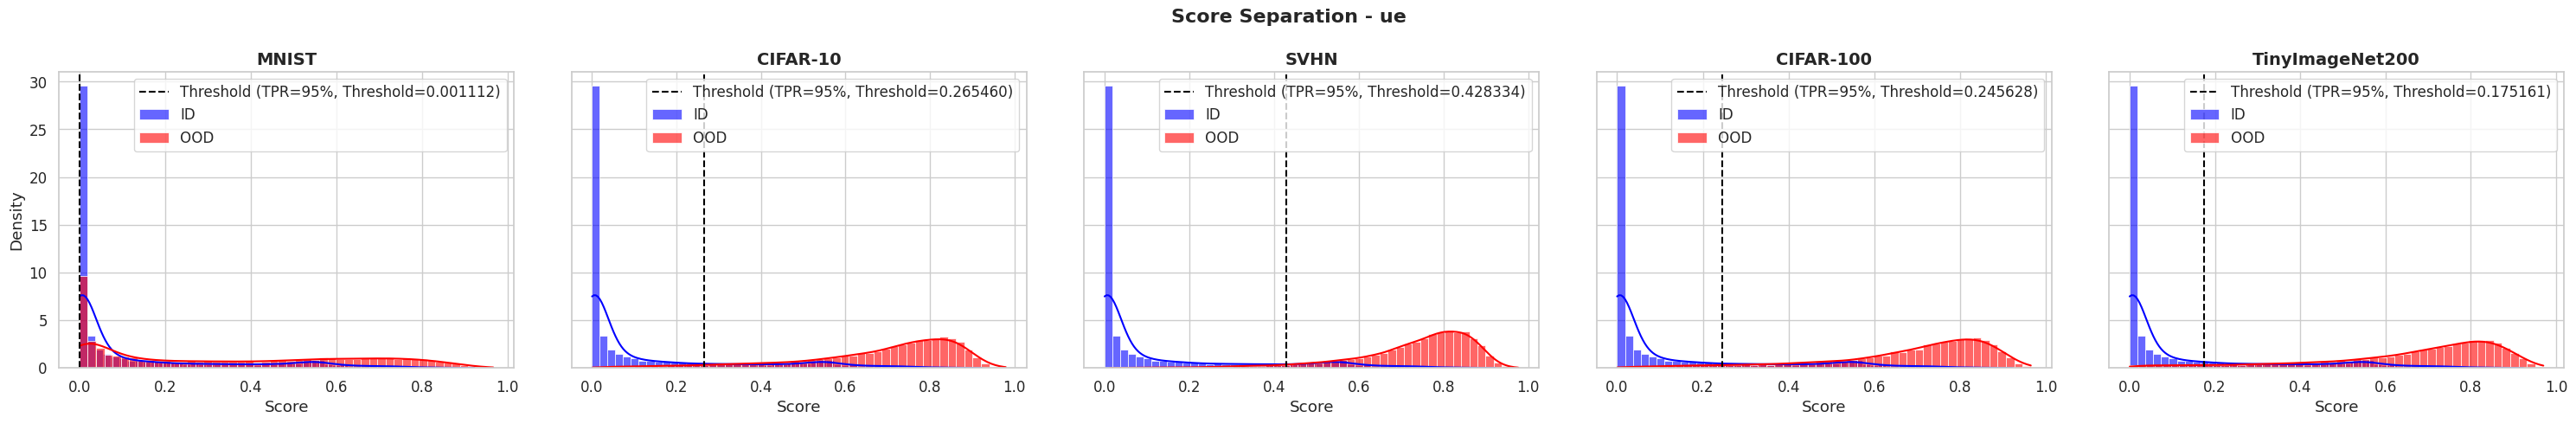

In [ ]:
plot_separation_for_method(results_ue, method_name="ue", target_tpr=0.95)

###### MSP(Max-Softmax Probability)

In [ ]:
metric = "msp"

In [ ]:
df_msp, results_msp = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name= id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - MSP


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID msp Mean  OOD msp Mean  \
0            MNIST  0.7553  0.7368     0.6677       0.9216        0.7796   
1         CIFAR-10  0.9454  0.9372     0.2010       0.9216        0.5239   
2             SVHN  0.9619  0.9814     0.1415       0.9216        0.4877   
3        CIFAR-100  0.9448  0.9371     0.2080       0.9216        0.5231   
4  TinyImageNet200  0.9353  0.9278     0.2441       0.9216        0.5408   

   Separation  
0      0.1420  
1      0.3977  
2      0.4339  
3      0.3985  
4      0.3808


Avg AUROC = 0.9085 | Avg AUPR = 0.9041 | Avg FPR@95TPR = 0.2925


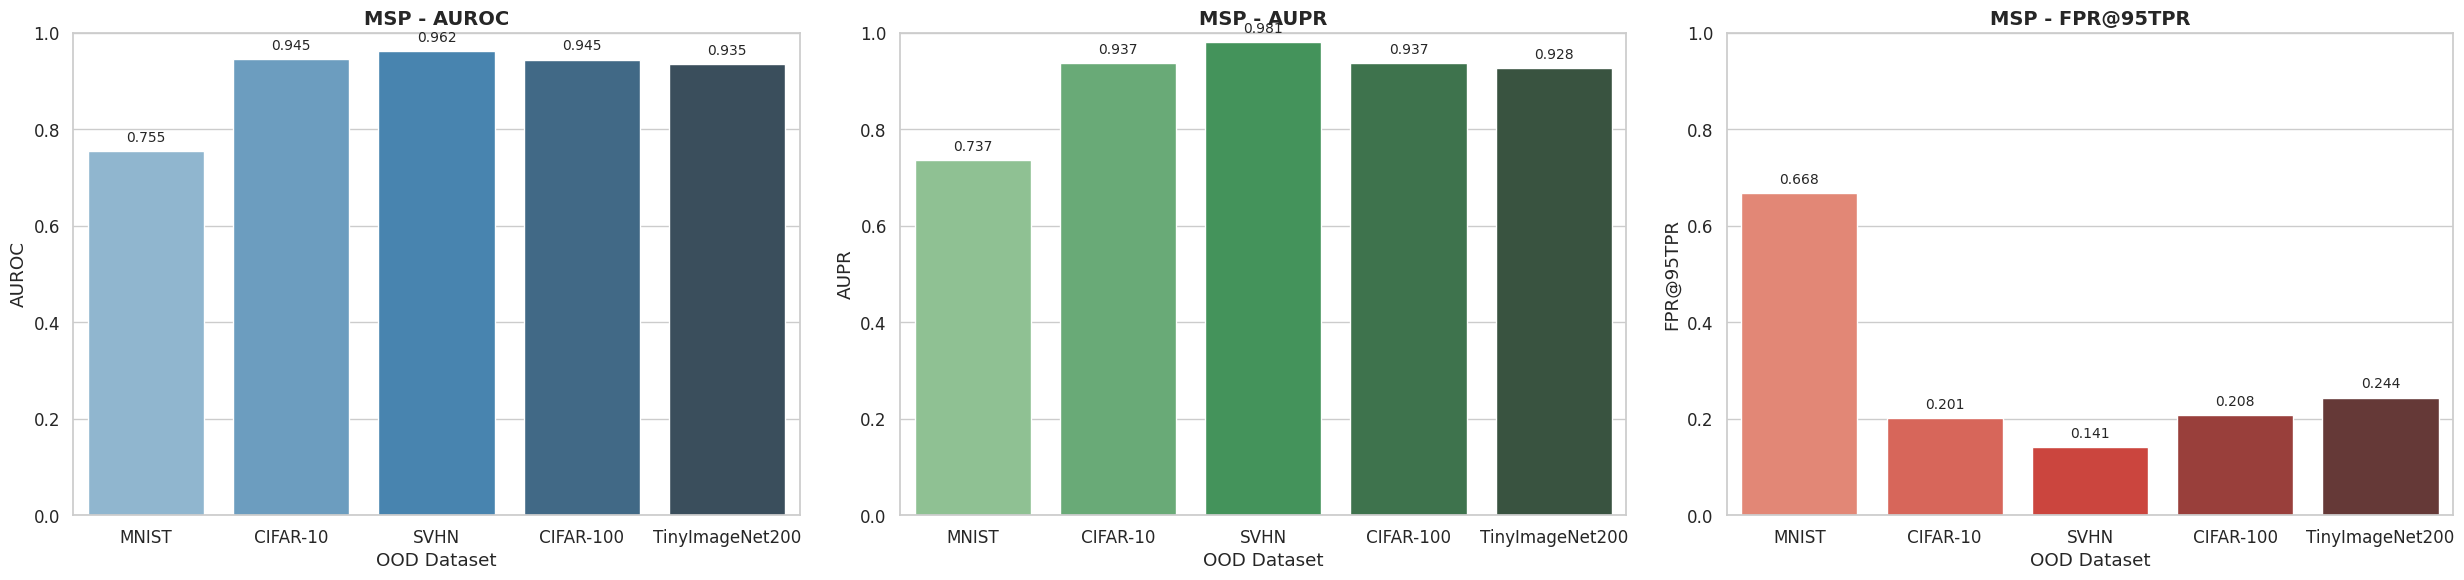

In [ ]:
plot_ood_metrics(df_msp, metric)

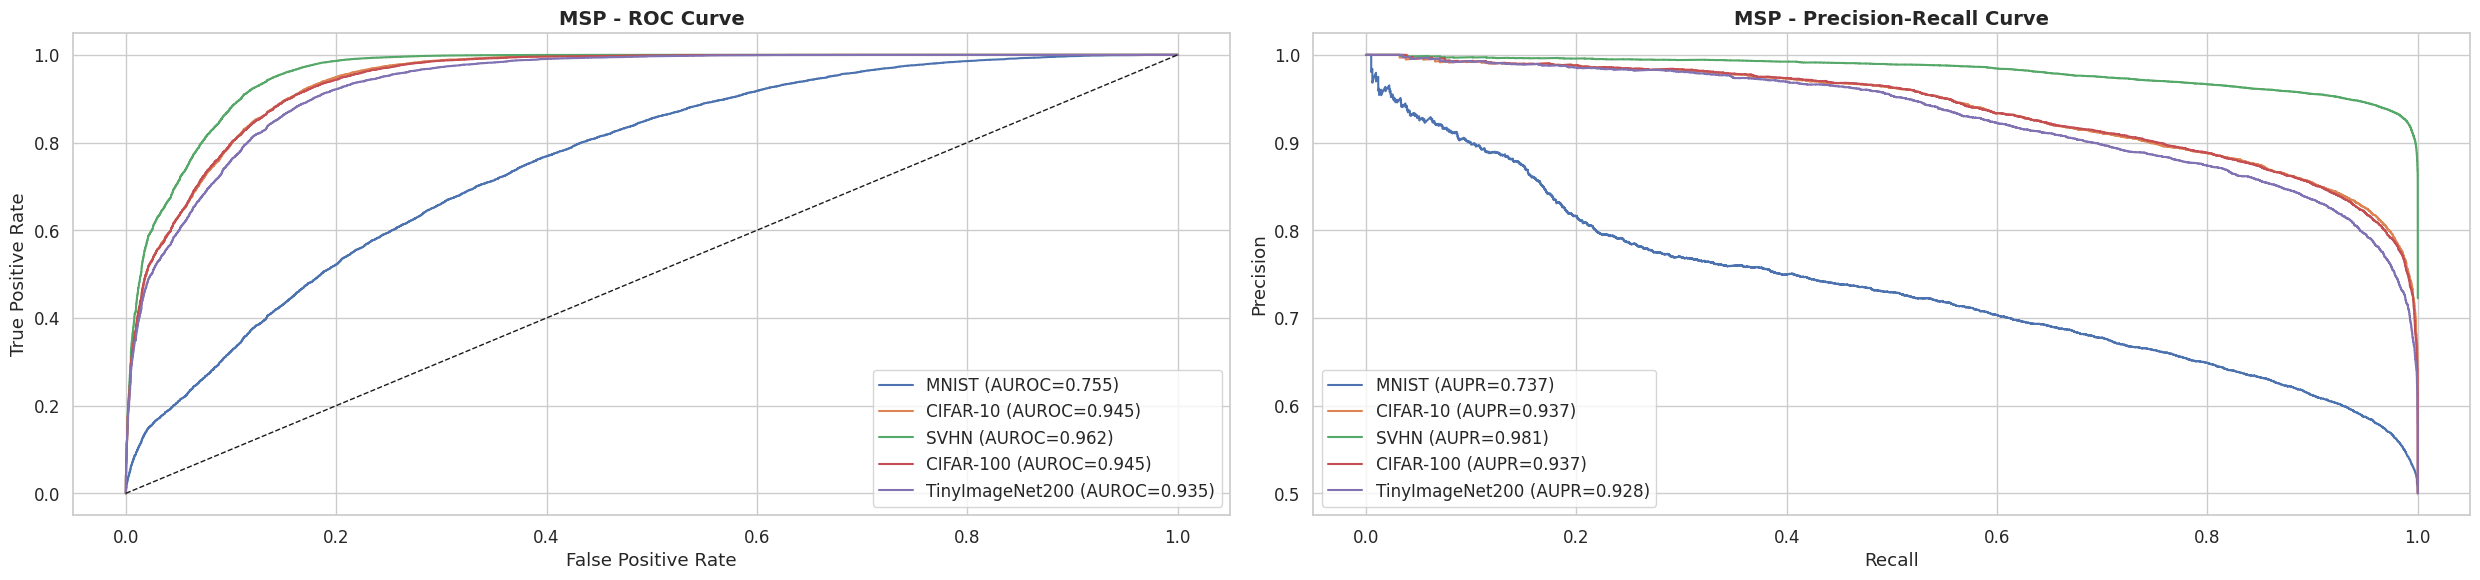

In [ ]:
plot_ood_curves(results_msp, metric)

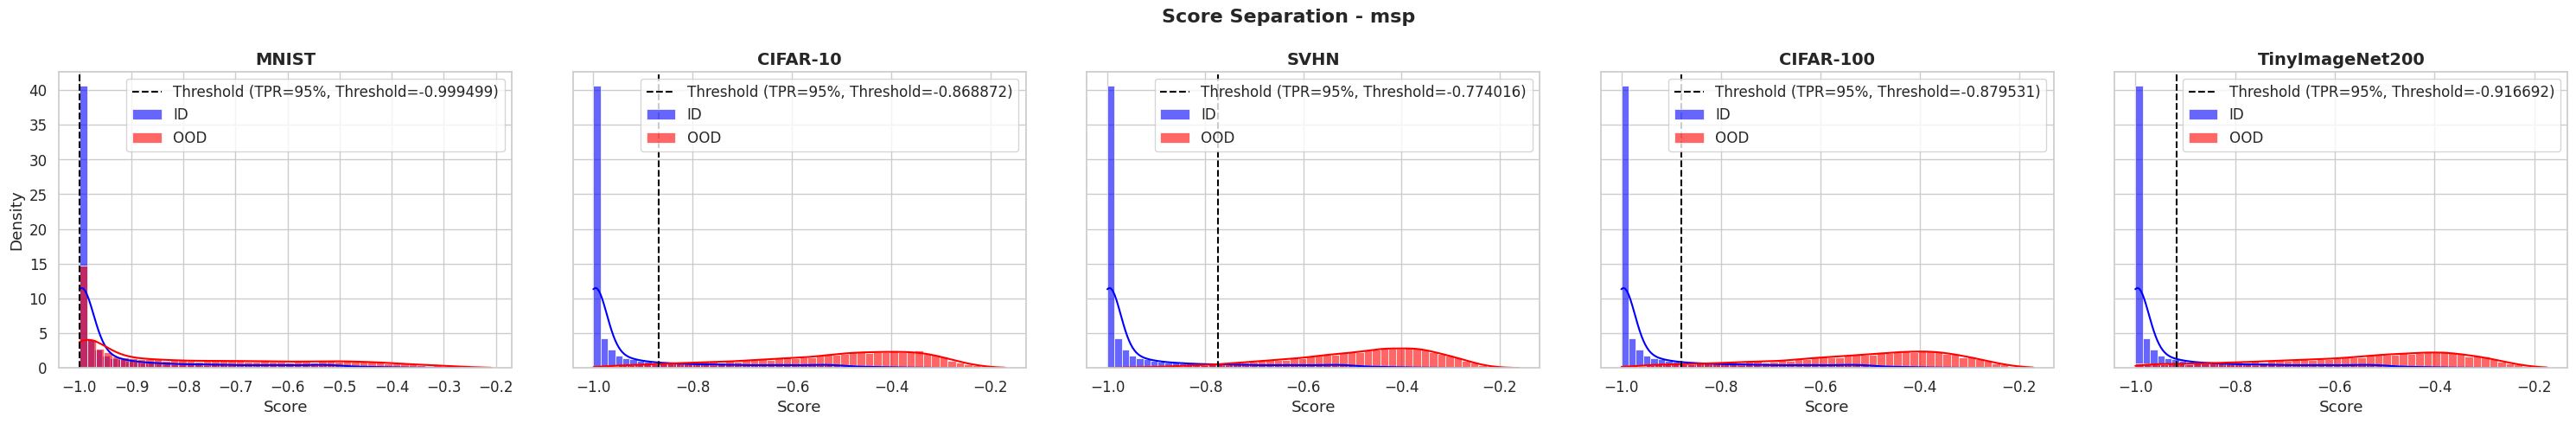

In [ ]:
plot_separation_for_method(results_msp, method_name=metric, target_tpr=0.95)

###### ODIN(Out-of-distrbution detector for Neural Networks)

In [ ]:
metric = "odin"

In [ ]:
df_odin, results_odin = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - ODIN


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID odin Mean  OOD odin Mean  \
0            MNIST  0.9039  0.9066     0.4565        0.1011         0.1006   
1         CIFAR-10  0.9880  0.9854     0.0489        0.1011         0.1004   
2             SVHN  0.9946  0.9971     0.0195        0.1011         0.1003   
3        CIFAR-100  0.9880  0.9859     0.0505        0.1011         0.1004   
4  TinyImageNet200  0.9867  0.9849     0.0574        0.1011         0.1004   

   Separation  
0      0.0006  
1      0.0008  
2      0.0008  
3      0.0008  
4      0.0008


Avg AUROC = 0.9722 | Avg AUPR = 0.9720 | Avg FPR@95TPR = 0.1266


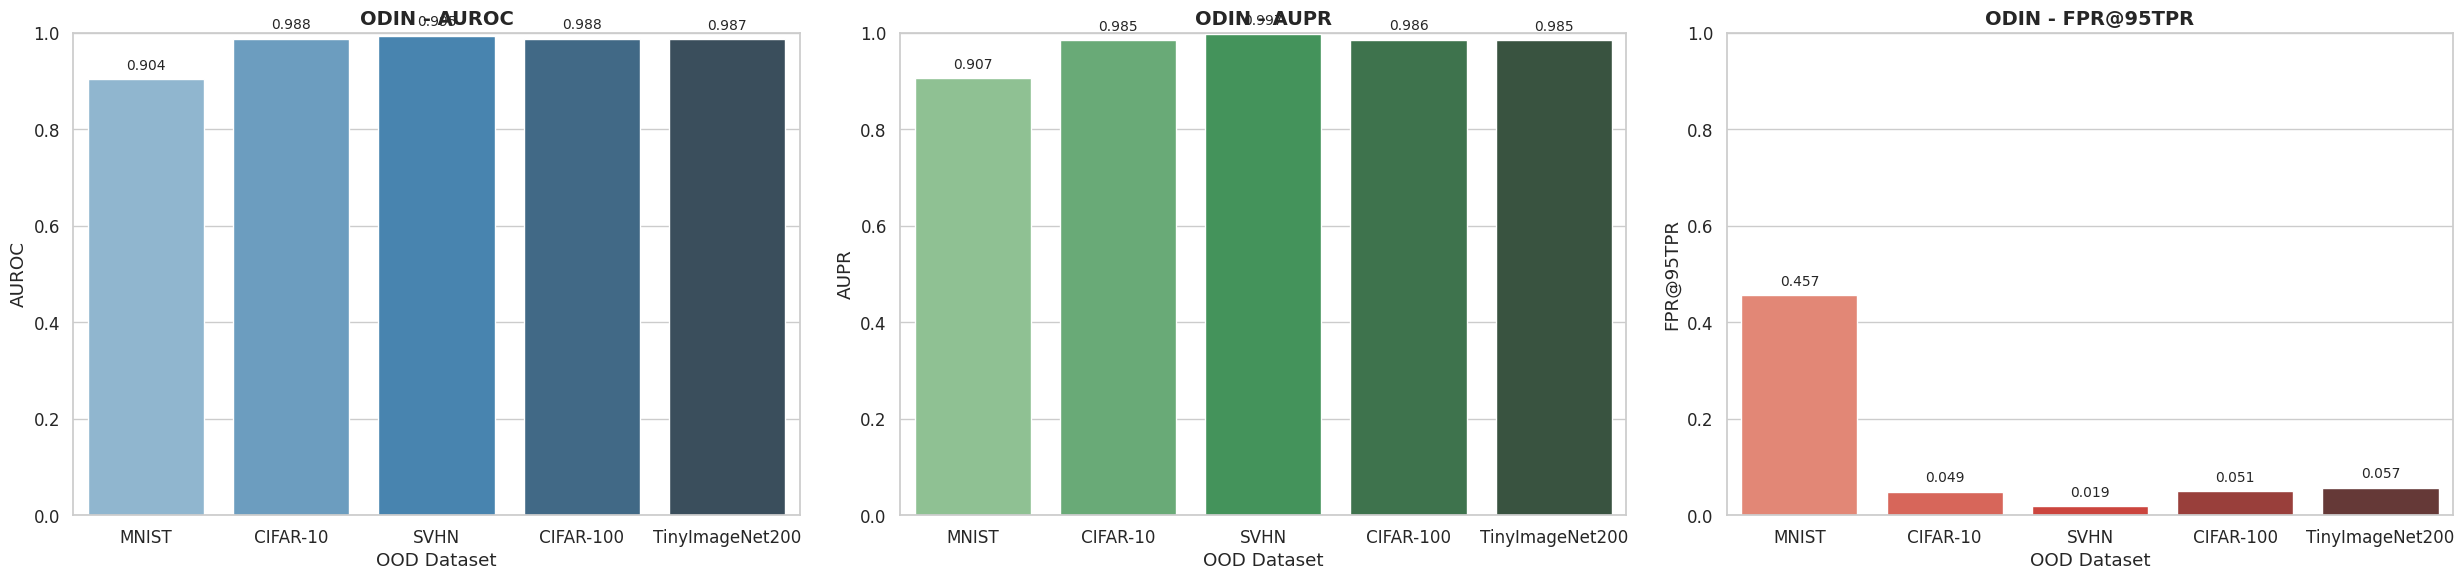

In [ ]:
plot_ood_metrics(df_odin, metric)

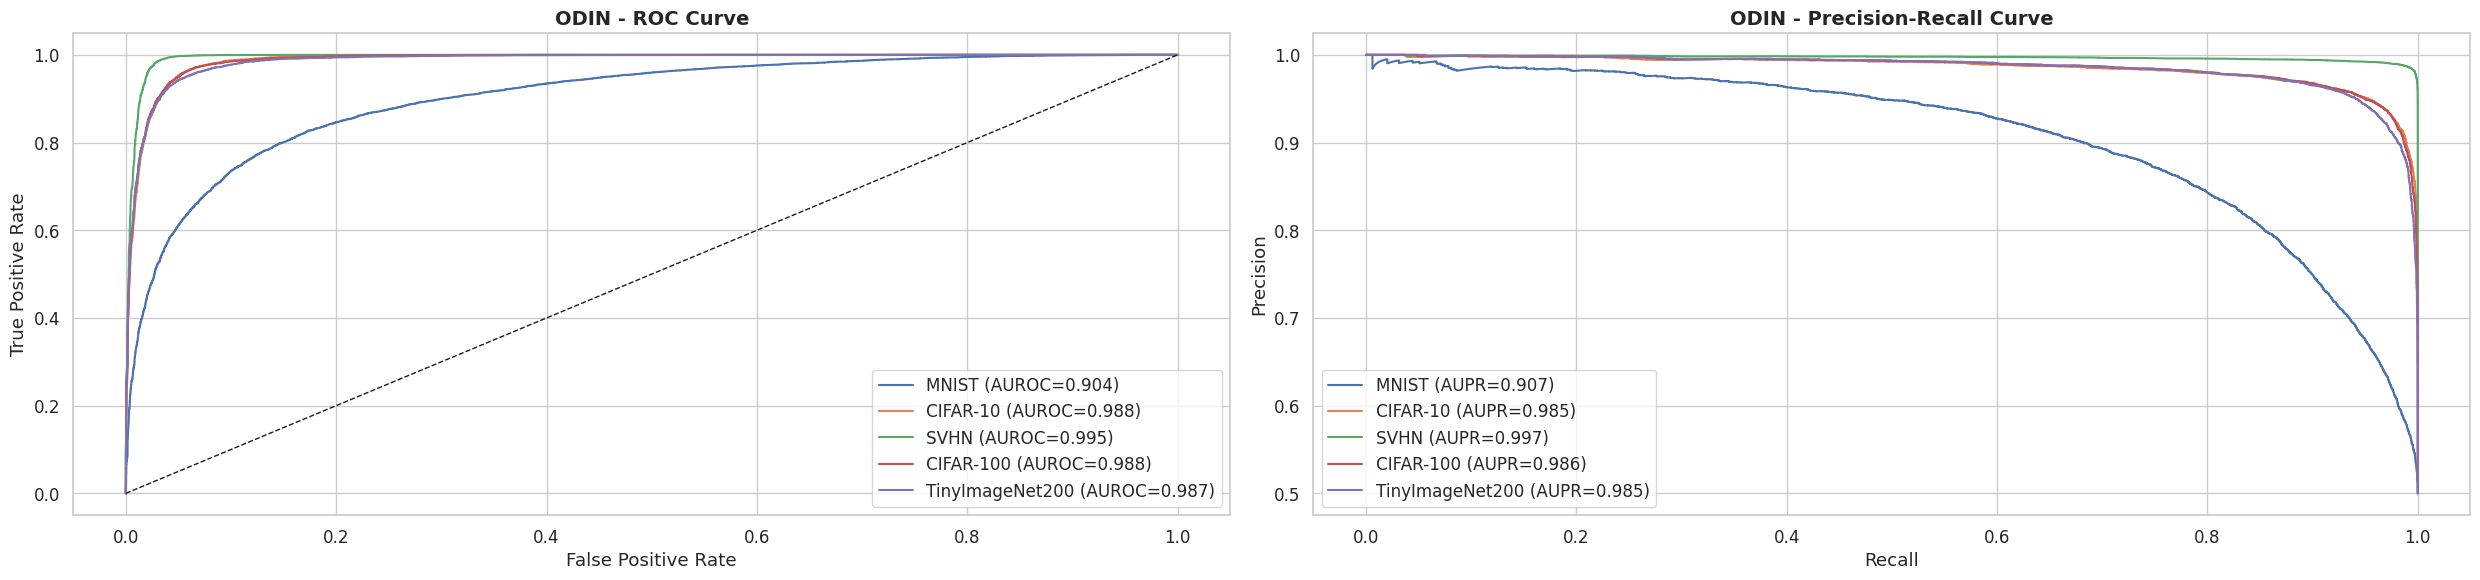

In [ ]:
plot_ood_curves(results_odin, metric)

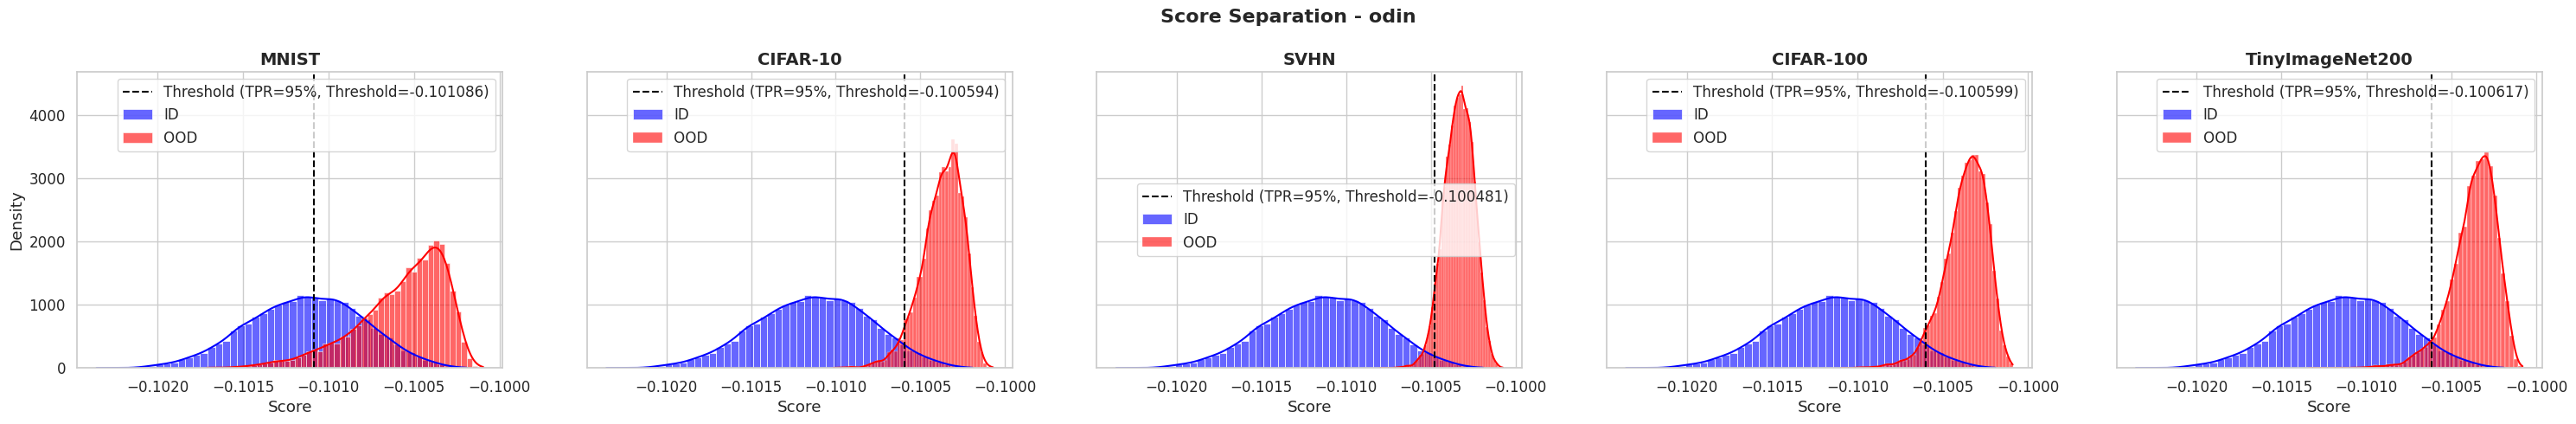

In [ ]:
plot_separation_for_method(results_odin, method_name=metric, target_tpr=0.95)

###### Energy

In [ ]:
metric = "energy"

In [ ]:
df_energy, results_energy = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - ENERGY


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID energy Mean  \
0            MNIST  0.8836  0.8876     0.5121         -8.3367   
1         CIFAR-10  0.9967  0.9968     0.0144         -8.3367   
2             SVHN  0.9983  0.9993     0.0090         -8.3367   
3        CIFAR-100  0.9963  0.9965     0.0137         -8.3367   
4  TinyImageNet200  0.9937  0.9943     0.0244         -8.3367   

   OOD energy Mean  Separation  
0          -4.1932      4.1435  
1          -1.4864      6.8504  
2          -1.5712      6.7656  
3          -1.4796      6.8571  
4          -1.5302      6.8066


Avg AUROC = 0.9737 | Avg AUPR = 0.9749 | Avg FPR@95TPR = 0.1147


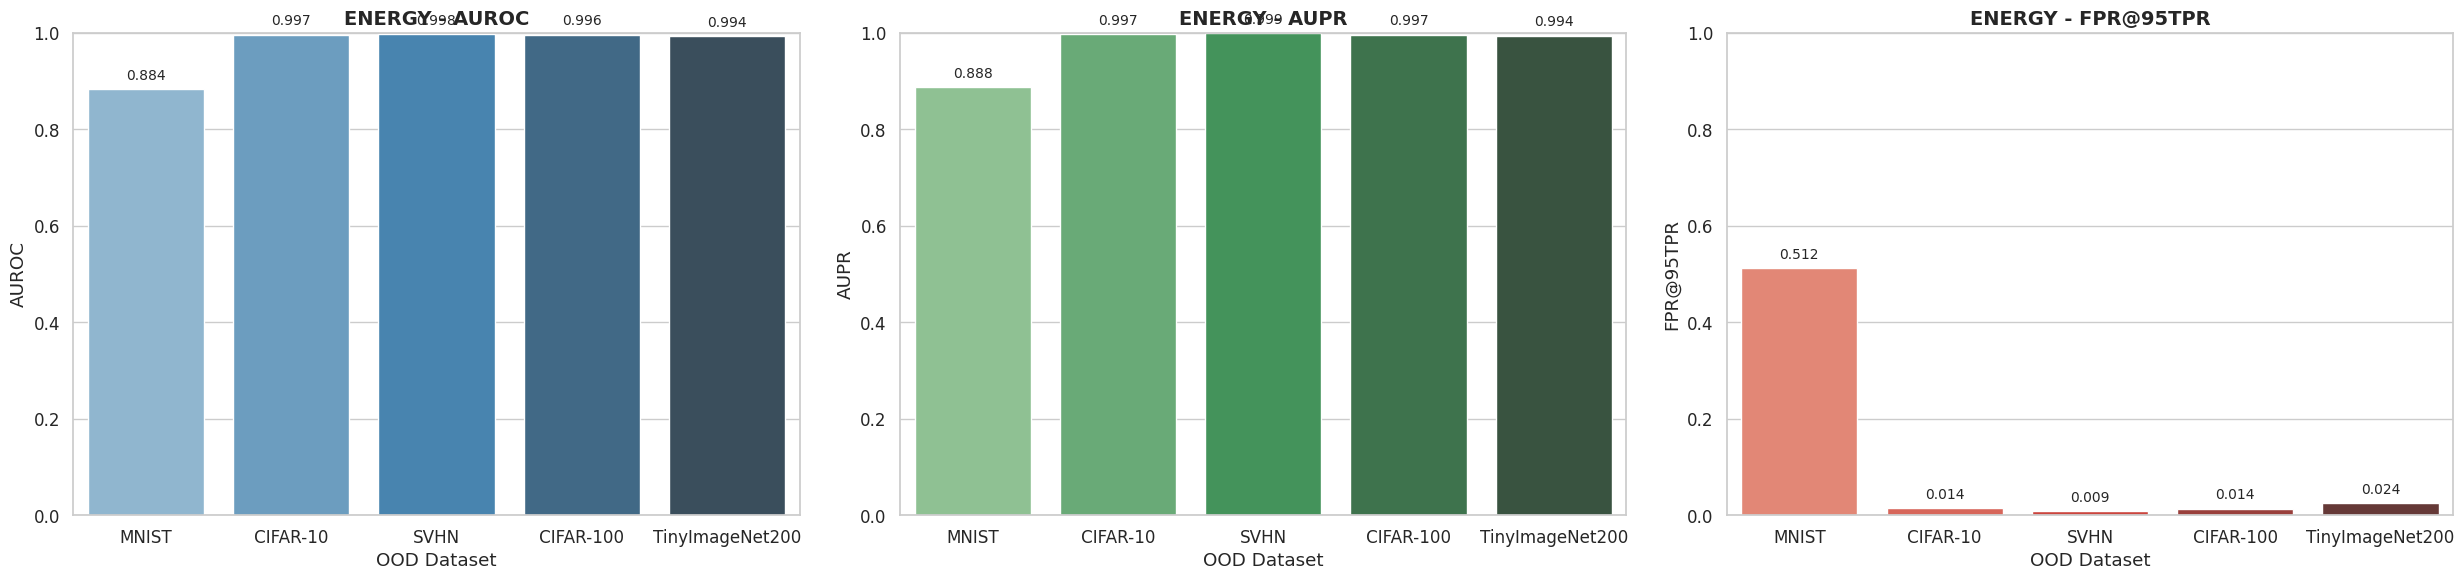

In [ ]:
plot_ood_metrics(df_energy, metric)

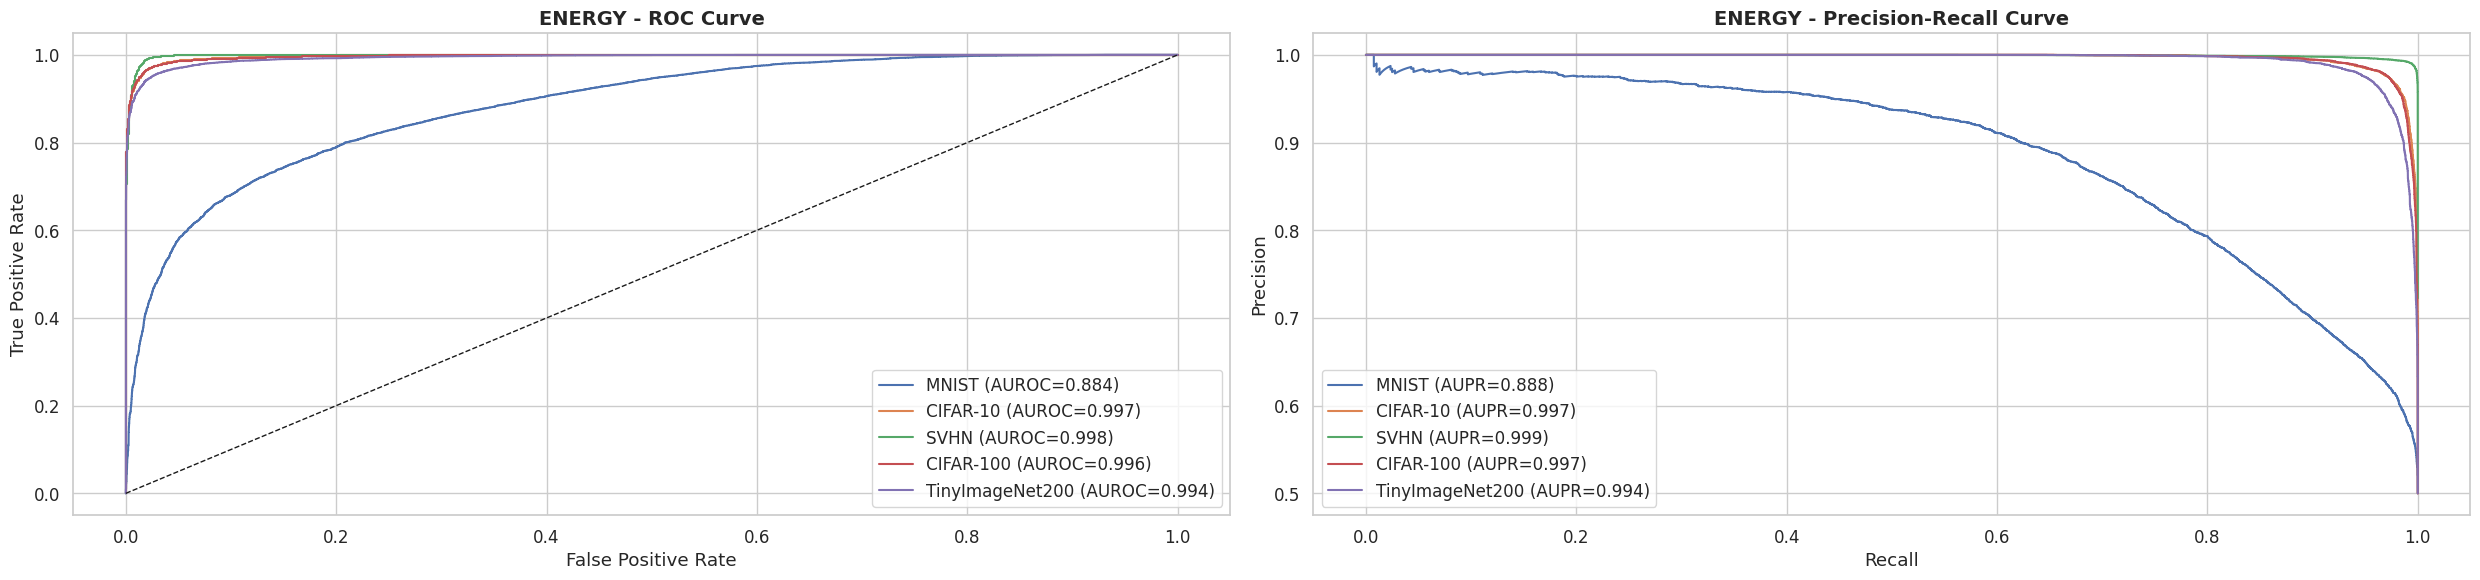

In [ ]:
plot_ood_curves(results_energy, metric)

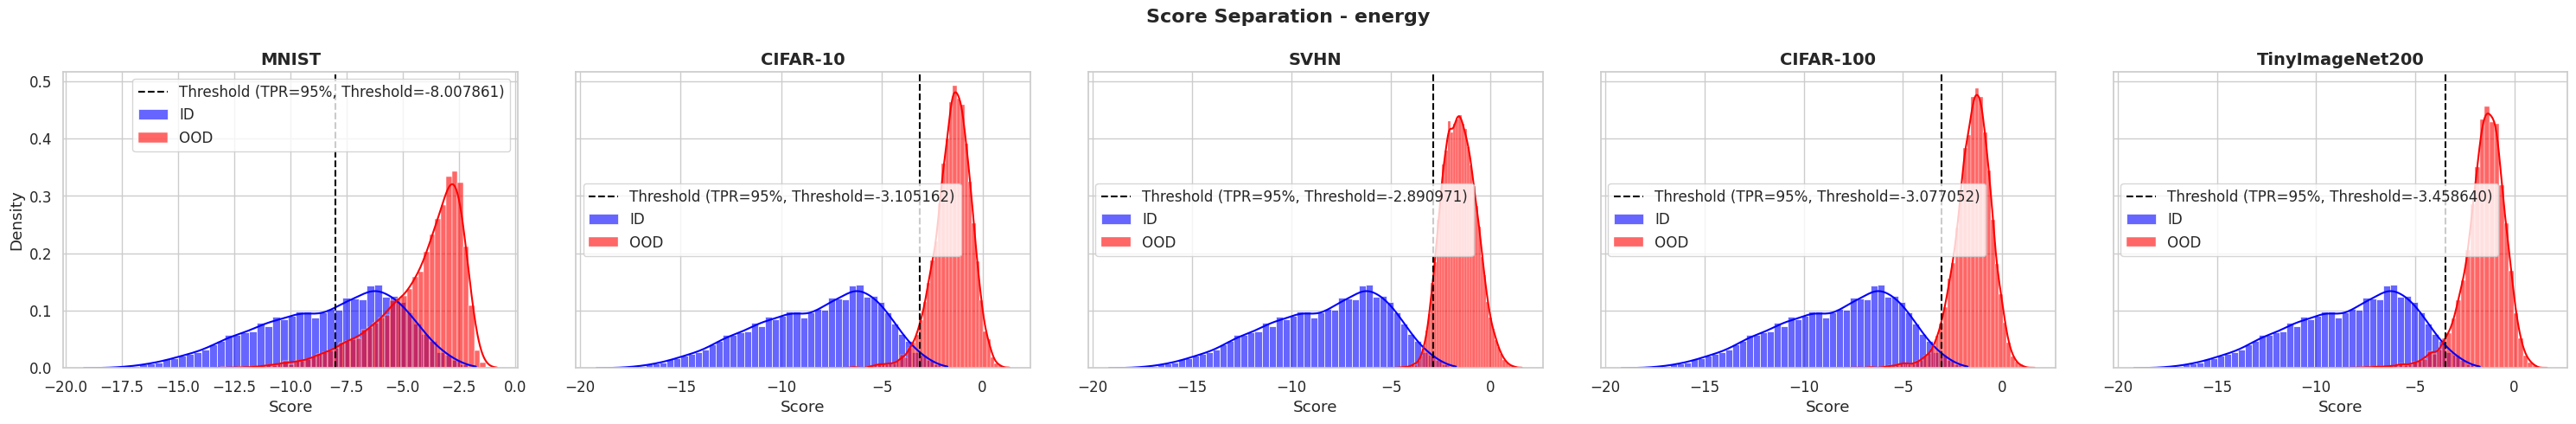

In [ ]:
plot_separation_for_method(results_energy, method_name=metric, target_tpr=0.95)

###### Mahalanobis

In [ ]:
metric = "mahalanobis"

In [ ]:
df_maha, results_maha = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - MAHALANOBIS


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID mahalanobis Mean  \
0            MNIST  0.9769  0.9713     0.0881          -120.104401   
1         CIFAR-10  0.9981  0.9983     0.0039          -120.104401   
2             SVHN  0.9901  0.9964     0.0398          -120.104401   
3        CIFAR-100  0.9963  0.9968     0.0052          -120.104401   
4  TinyImageNet200  0.9943  0.9950     0.0141          -120.104401   

   OOD mahalanobis Mean  Separation  
0           -374.015808  253.911407  
1          -1005.007812  884.903381  
2           -833.721802  713.617493  
3           -999.036499  878.932129  
4           -858.382385  738.278015


Avg AUROC = 0.9911 | Avg AUPR = 0.9916 | Avg FPR@95TPR = 0.0302


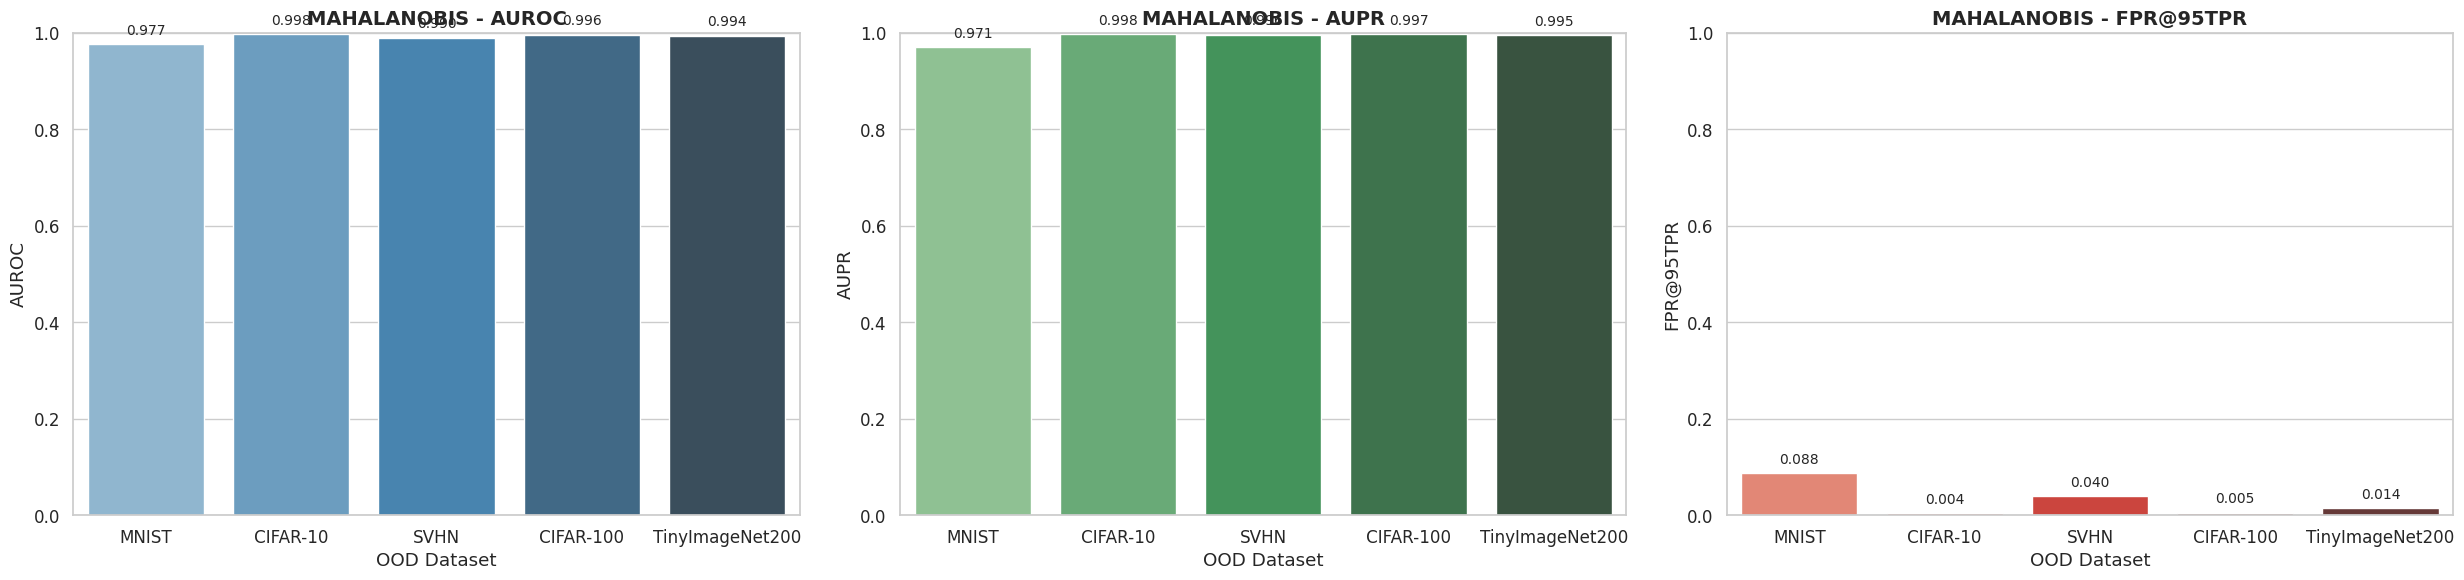

In [ ]:
plot_ood_metrics(df_maha, metric)

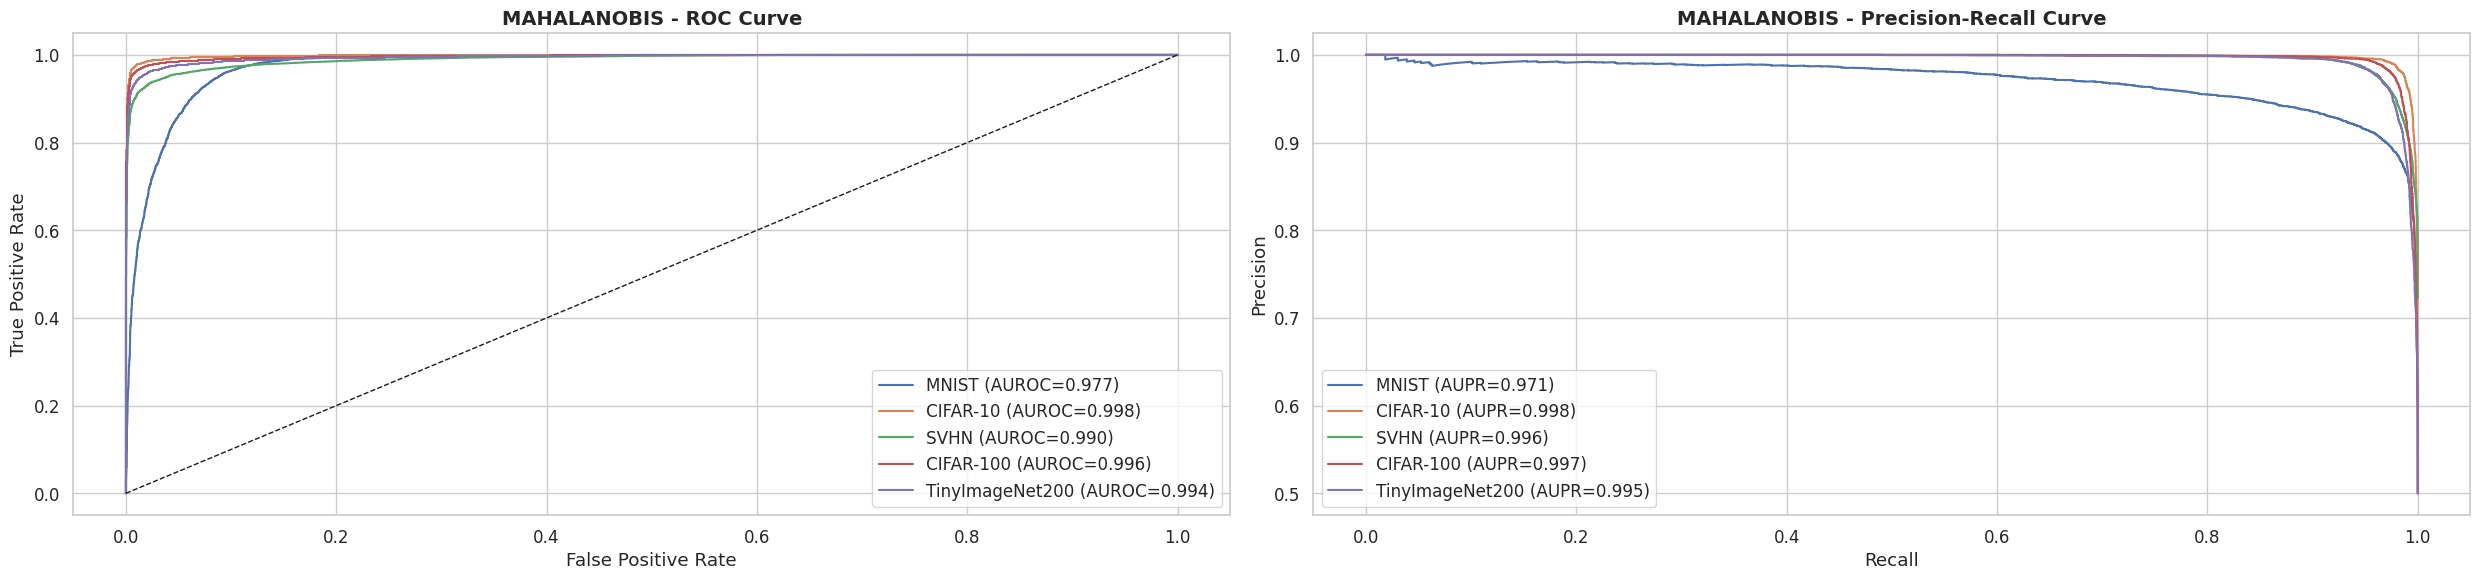

In [ ]:
plot_ood_curves(results_maha, metric)

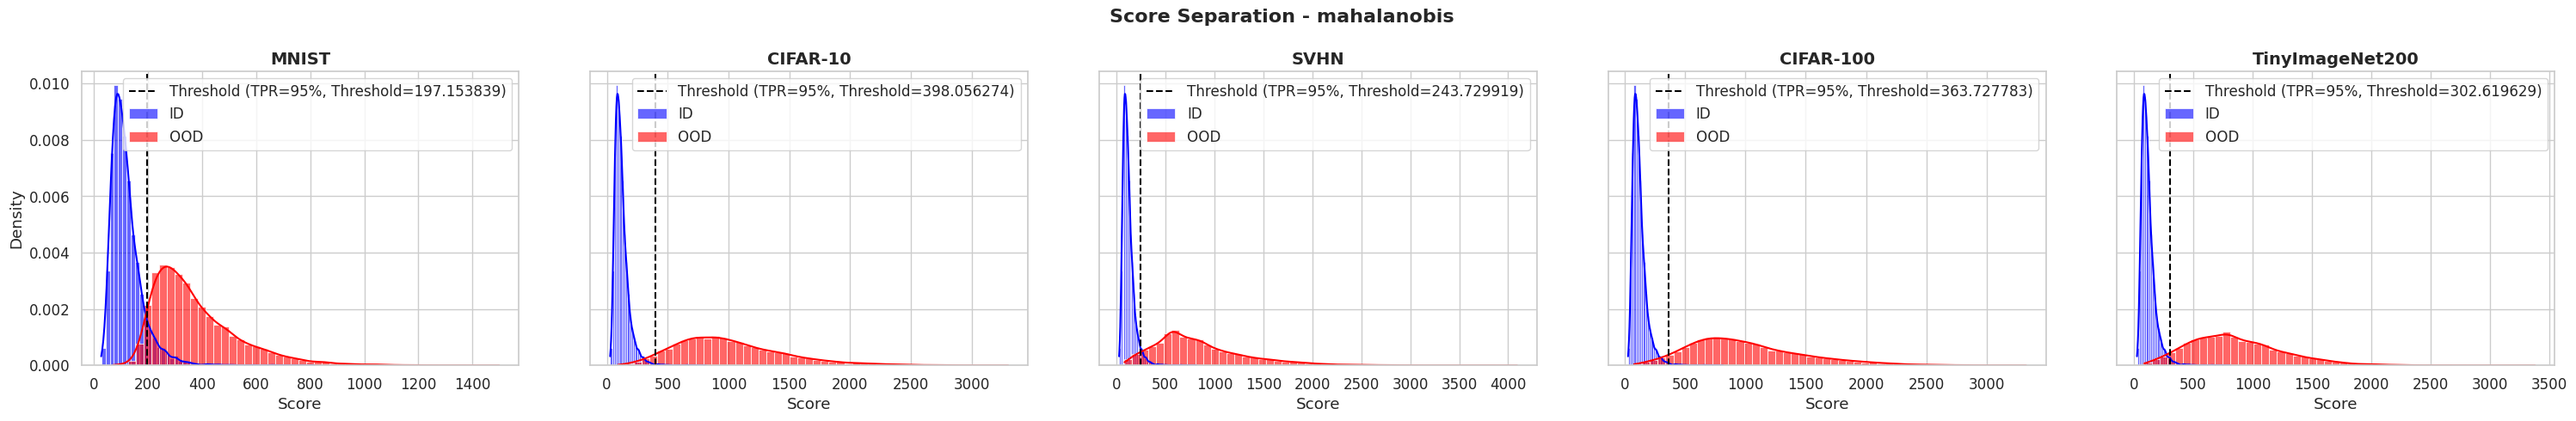

In [ ]:
plot_separation_for_method(results_maha, method_name=metric, target_tpr=0.95)

###### Comparison

In [ ]:
metric_dfs = {
    "UE": df_ue,
    "MSP": df_msp,
    "ODIN": df_odin,
    "Energy": df_energy,
    "Mahalanobis": df_maha
}

# Initialize empty dicts to store AUROC, AUPR, FPR separately
auroc_df, aupr_df, fpr95_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for metric_name, df in metric_dfs.items():
    temp_df = df.set_index("OOD Dataset")
    auroc_df[metric_name] = temp_df["AUROC"]
    aupr_df[metric_name] = temp_df["AUPR"]
    fpr95_df[metric_name] = temp_df["FPR@95TPR"]

# Reset index so OOD Dataset is a column
auroc_df = auroc_df.reset_index()
aupr_df = aupr_df.reset_index()
fpr95_df = fpr95_df.reset_index()

In [ ]:
print("=== AUROC Comparison ===")
display(auroc_df)

=== AUROC Comparison ===


OOD Dataset      UE     MSP    ODIN  Energy  Mahalanobis
0            MNIST  0.7623  0.7553  0.9039  0.8836       0.9769
1         CIFAR-10  0.9566  0.9454  0.9880  0.9967       0.9981
2             SVHN  0.9747  0.9619  0.9946  0.9983       0.9901
3        CIFAR-100  0.9562  0.9448  0.9880  0.9963       0.9963
4  TinyImageNet200  0.9465  0.9353  0.9867  0.9937       0.9943

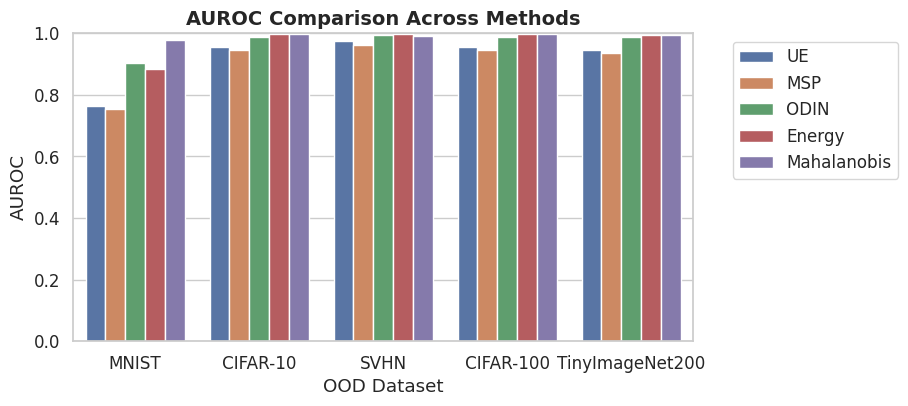

In [ ]:
plot_metric_comparison(auroc_df, "AUROC")

In [ ]:
print("=== AUPR Comparison ===")
display(aupr_df)

=== AUPR Comparison ===


OOD Dataset      UE     MSP    ODIN  Energy  Mahalanobis
0            MNIST  0.7575  0.7368  0.9066  0.8876       0.9713
1         CIFAR-10  0.9533  0.9372  0.9854  0.9968       0.9983
2             SVHN  0.9884  0.9814  0.9971  0.9993       0.9964
3        CIFAR-100  0.9535  0.9371  0.9859  0.9965       0.9968
4  TinyImageNet200  0.9444  0.9278  0.9849  0.9943       0.9950

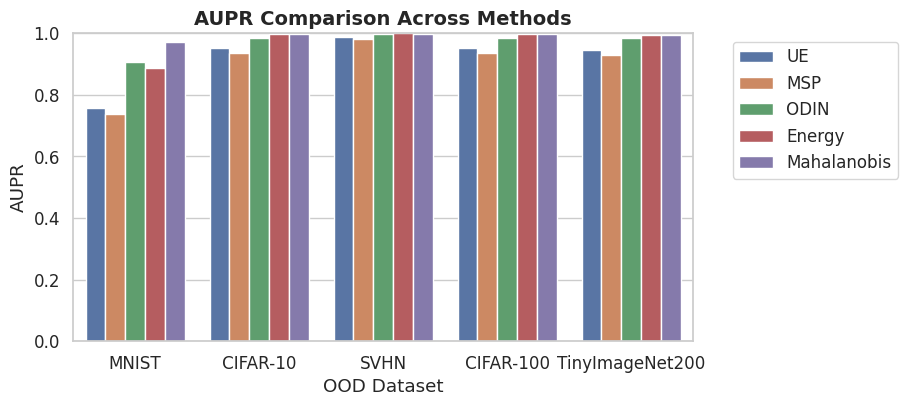

In [ ]:
plot_metric_comparison(aupr_df, "AUPR")

In [ ]:
print("=== FPR@95TPR Comparison ===")
display(fpr95_df)

=== FPR@95TPR Comparison ===


OOD Dataset      UE     MSP    ODIN  Energy  Mahalanobis
0            MNIST  0.6677  0.6677  0.4565  0.5121       0.0881
1         CIFAR-10  0.1971  0.2010  0.0489  0.0144       0.0039
2             SVHN  0.1322  0.1415  0.0195  0.0090       0.0398
3        CIFAR-100  0.2053  0.2080  0.0505  0.0137       0.0052
4  TinyImageNet200  0.2424  0.2441  0.0574  0.0244       0.0141

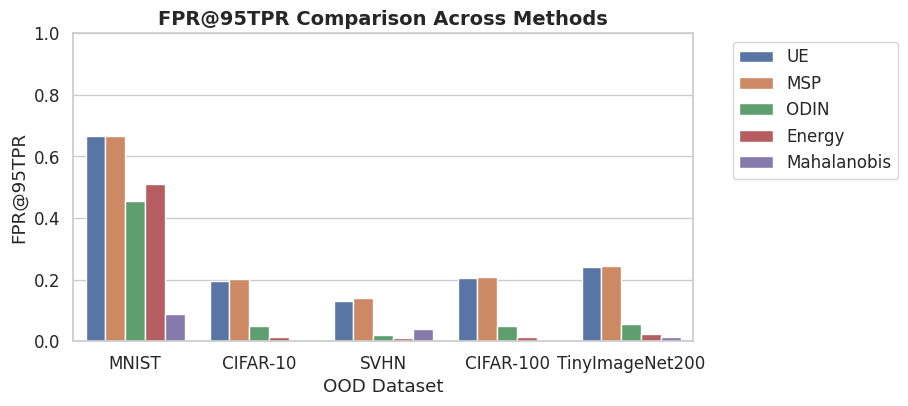

In [ ]:
plot_metric_comparison(fpr95_df, "FPR@95TPR")

##### Including Garbage class

In [ ]:
id_name = "FMNIST"

In [ ]:
# Compute class statistics from ID dataset
class_means, cov_inv = compute_mahalanobis_stats(model_after_inv, datasets[id_name], device)

In [ ]:
exclude_garbage=False

###### UE

In [ ]:
metric = "ue"

In [ ]:
df_ue, results_ue = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - UE


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID ue Mean  OOD ue Mean  \
0            MNIST  0.7749  0.7682     0.6432      0.1236       0.3532   
1         CIFAR-10  0.2311  0.3635     1.0000      0.1236       0.0339   
2             SVHN  0.4377  0.7494     1.0000      0.1236       0.1802   
3        CIFAR-100  0.2482  0.3802     1.0000      0.1236       0.0458   
4  TinyImageNet200  0.2930  0.4002     1.0000      0.1236       0.0566   

   Separation  
0      0.2296  
1      0.0896  
2      0.0566  
3      0.0778  
4      0.0670


Avg AUROC = 0.3970 | Avg AUPR = 0.5323 | Avg FPR@95TPR = 0.9286


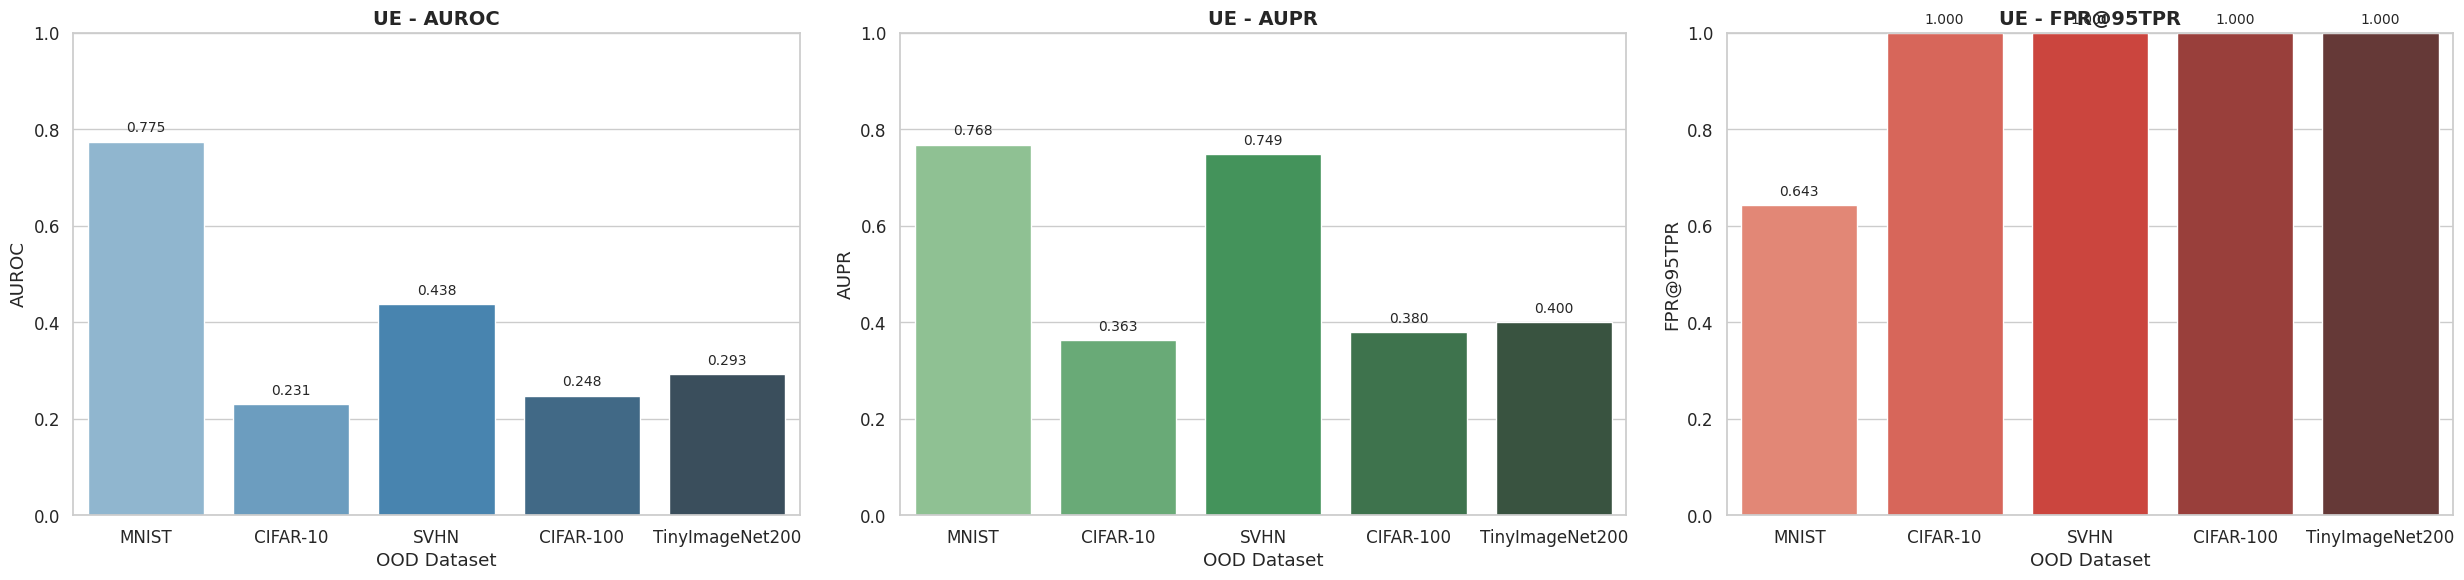

In [ ]:
plot_ood_metrics(df_ue, metric)

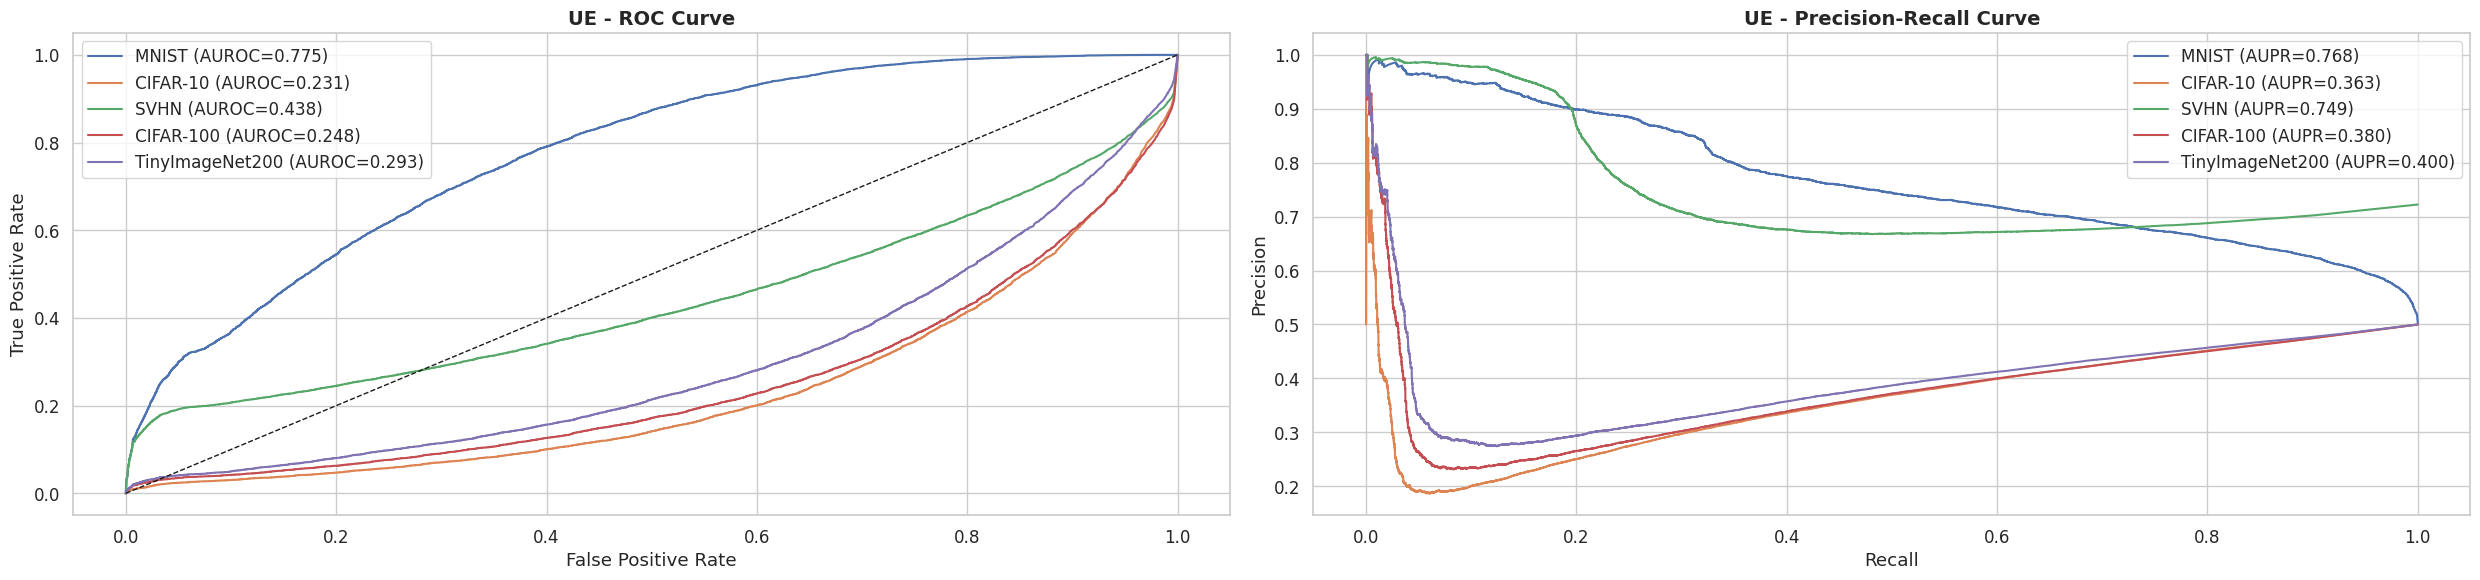

In [ ]:
plot_ood_curves(results_ue, metric)

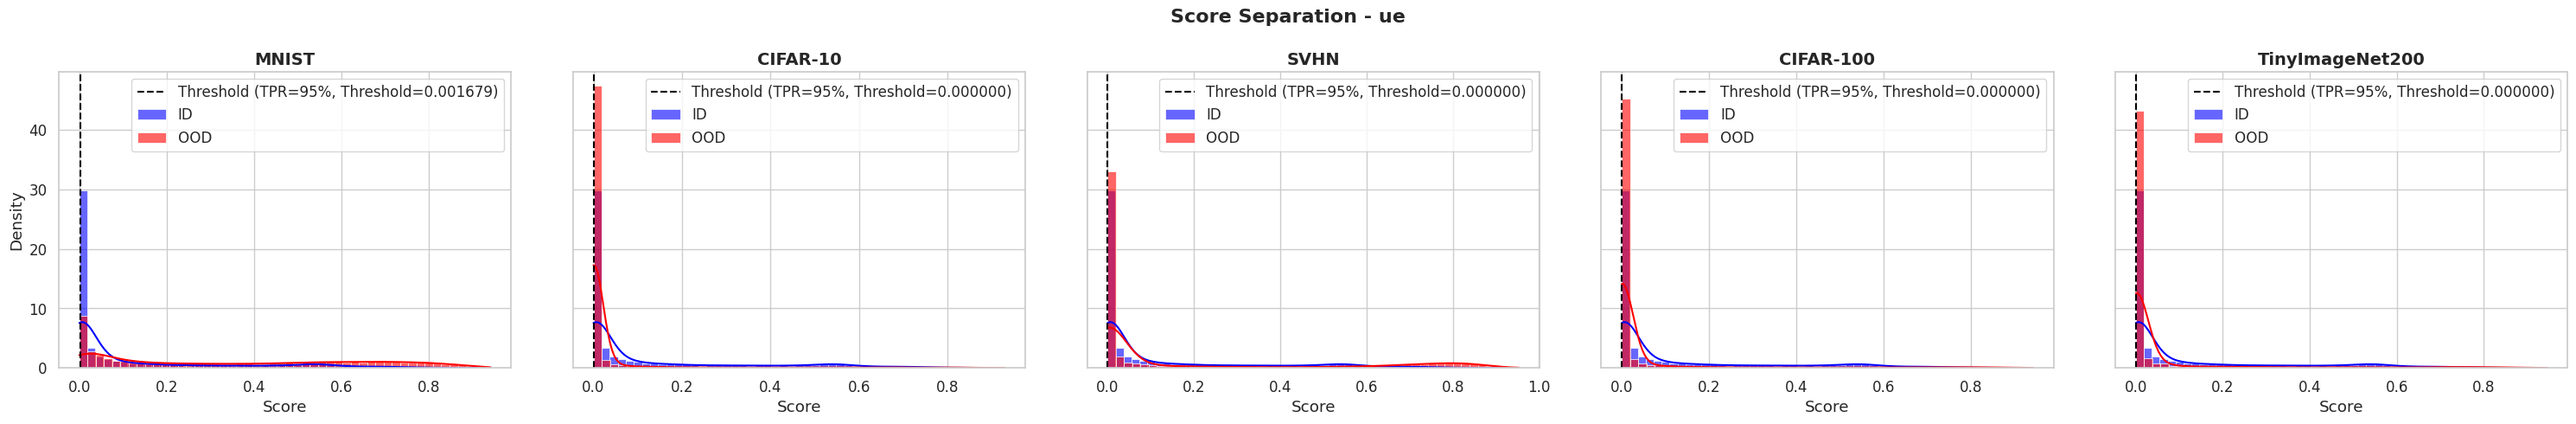

In [ ]:
plot_separation_for_method(results_ue, method_name="ue", target_tpr=0.95)

###### MSP(Max-Softmax Probability)

In [ ]:
metric = "msp"

In [ ]:
df_msp, results_msp = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name= id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - MSP


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID msp Mean  OOD msp Mean  \
0            MNIST  0.7677  0.7476     0.6432       0.9215        0.7711   
1         CIFAR-10  0.2306  0.3603     1.0000       0.9215        0.9787   
2             SVHN  0.4346  0.7428     1.0000       0.9215        0.8766   
3        CIFAR-100  0.2475  0.3753     1.0000       0.9215        0.9706   
4  TinyImageNet200  0.2922  0.3949     1.0000       0.9215        0.9638   

   Separation  
0      0.1504  
1      0.0572  
2      0.0449  
3      0.0491  
4      0.0423


Avg AUROC = 0.3945 | Avg AUPR = 0.5242 | Avg FPR@95TPR = 0.9286


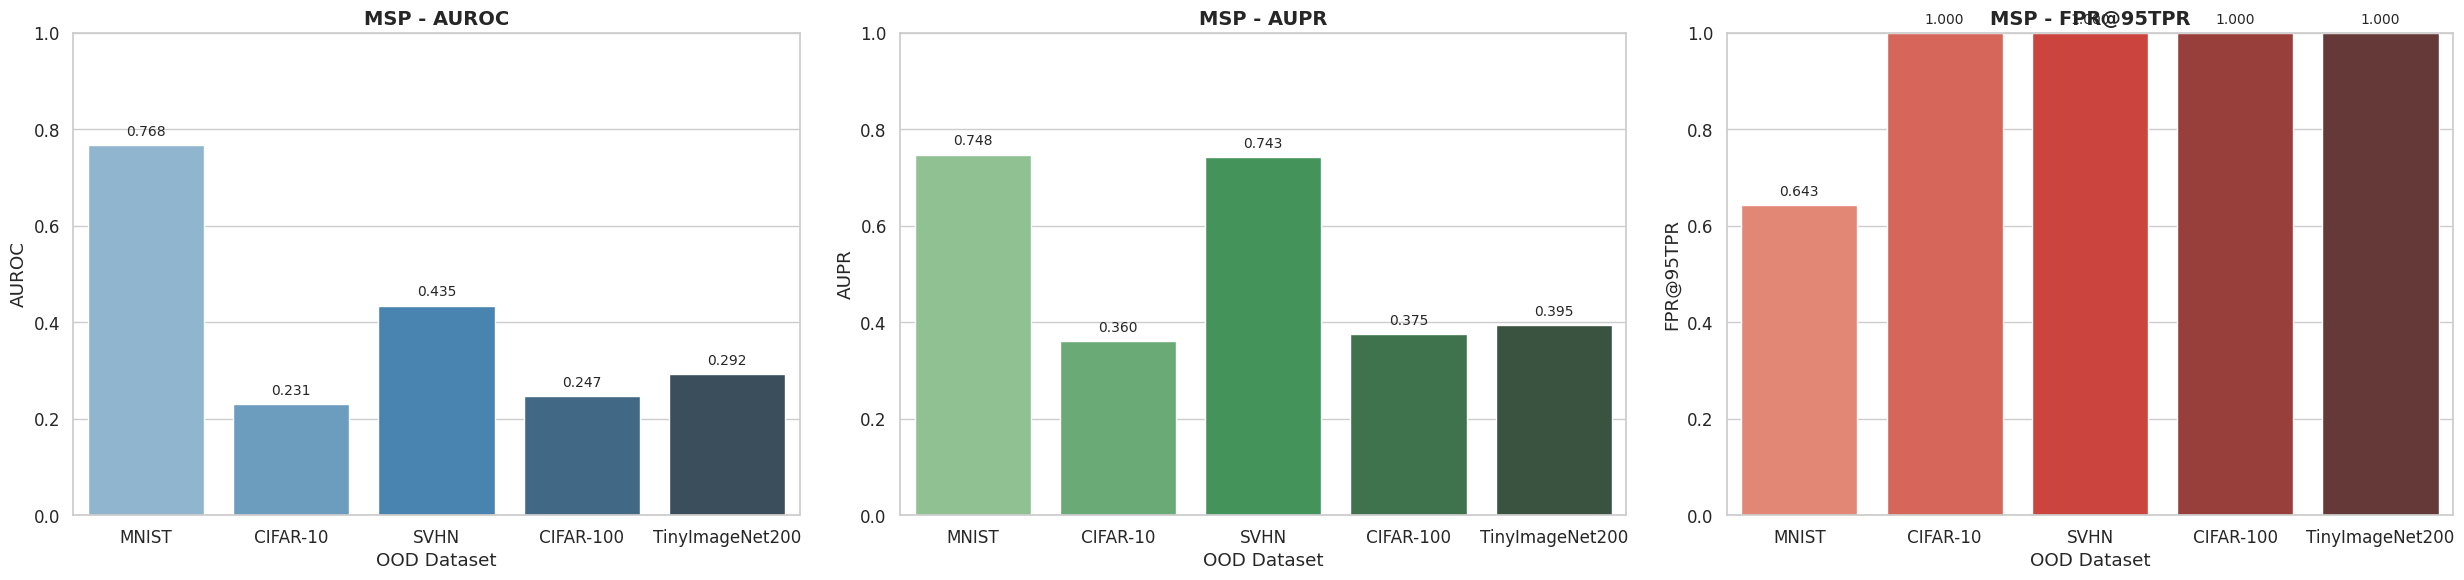

In [ ]:
plot_ood_metrics(df_msp, metric)

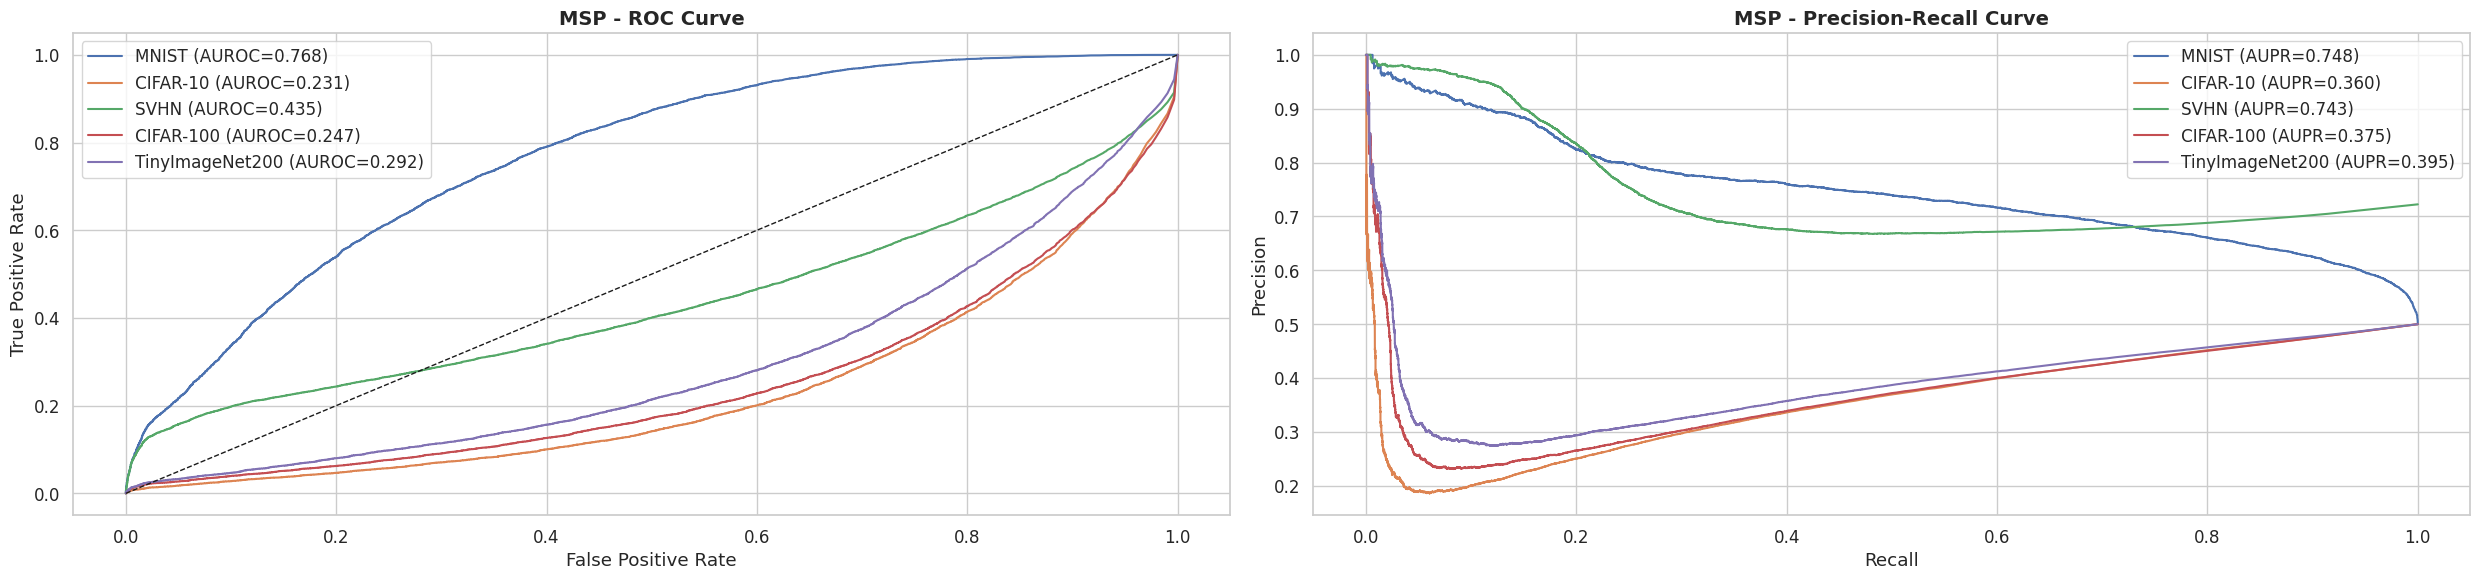

In [ ]:
plot_ood_curves(results_msp, metric)

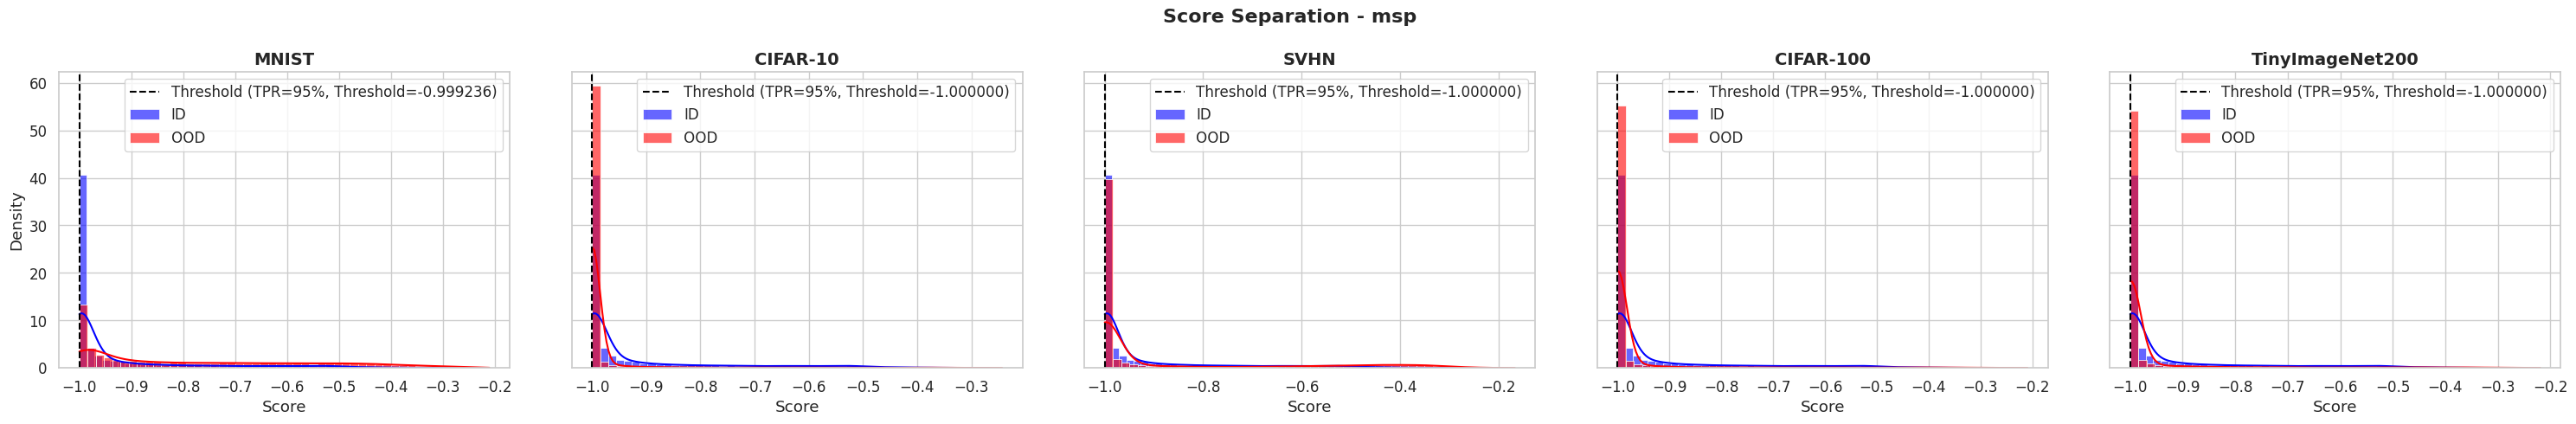

In [ ]:
plot_separation_for_method(results_msp, method_name=metric, target_tpr=0.95)

###### ODIN(Out-of-distrbution detector for Neural Networks)

In [ ]:
metric = "odin"

In [ ]:
df_odin, results_odin = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - ODIN


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID odin Mean  OOD odin Mean  \
0            MNIST  0.9151  0.9173     0.4161         0.092         0.0915   
1         CIFAR-10  0.3592  0.4451     0.9986         0.092         0.0921   
2             SVHN  0.5813  0.8267     0.9963         0.092         0.0919   
3        CIFAR-100  0.3798  0.4728     0.9992         0.092         0.0921   
4  TinyImageNet200  0.4410  0.5116     0.9911         0.092         0.0920   

   Separation  
0      0.0005  
1      0.0002  
2      0.0001  
3      0.0002  
4      0.0001


Avg AUROC = 0.5353 | Avg AUPR = 0.6347 | Avg FPR@95TPR = 0.8803


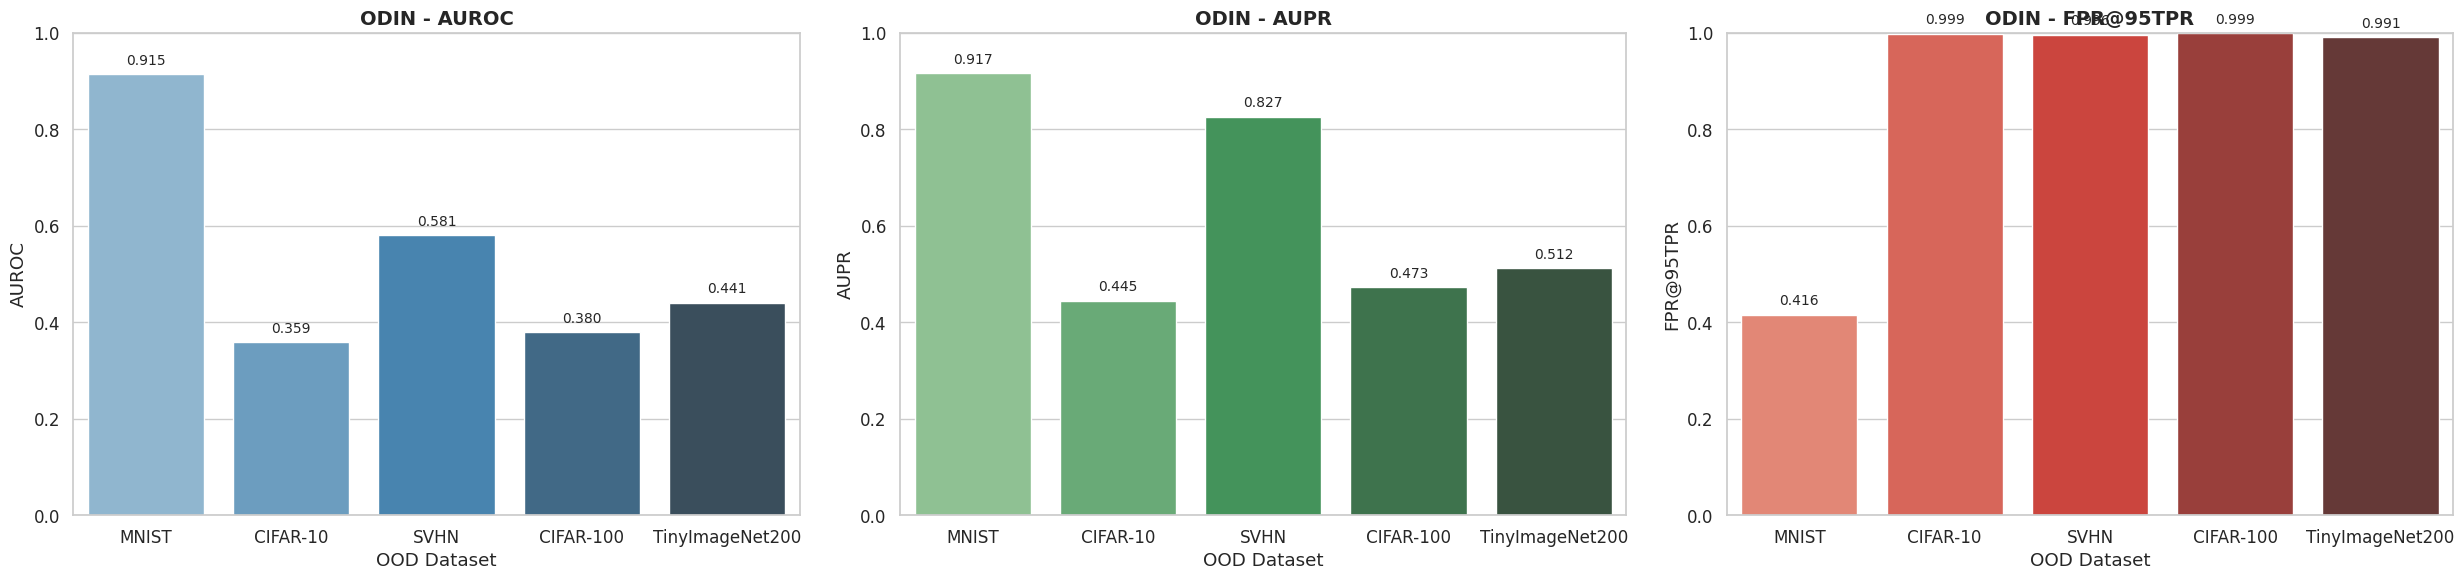

In [ ]:
plot_ood_metrics(df_odin, metric)

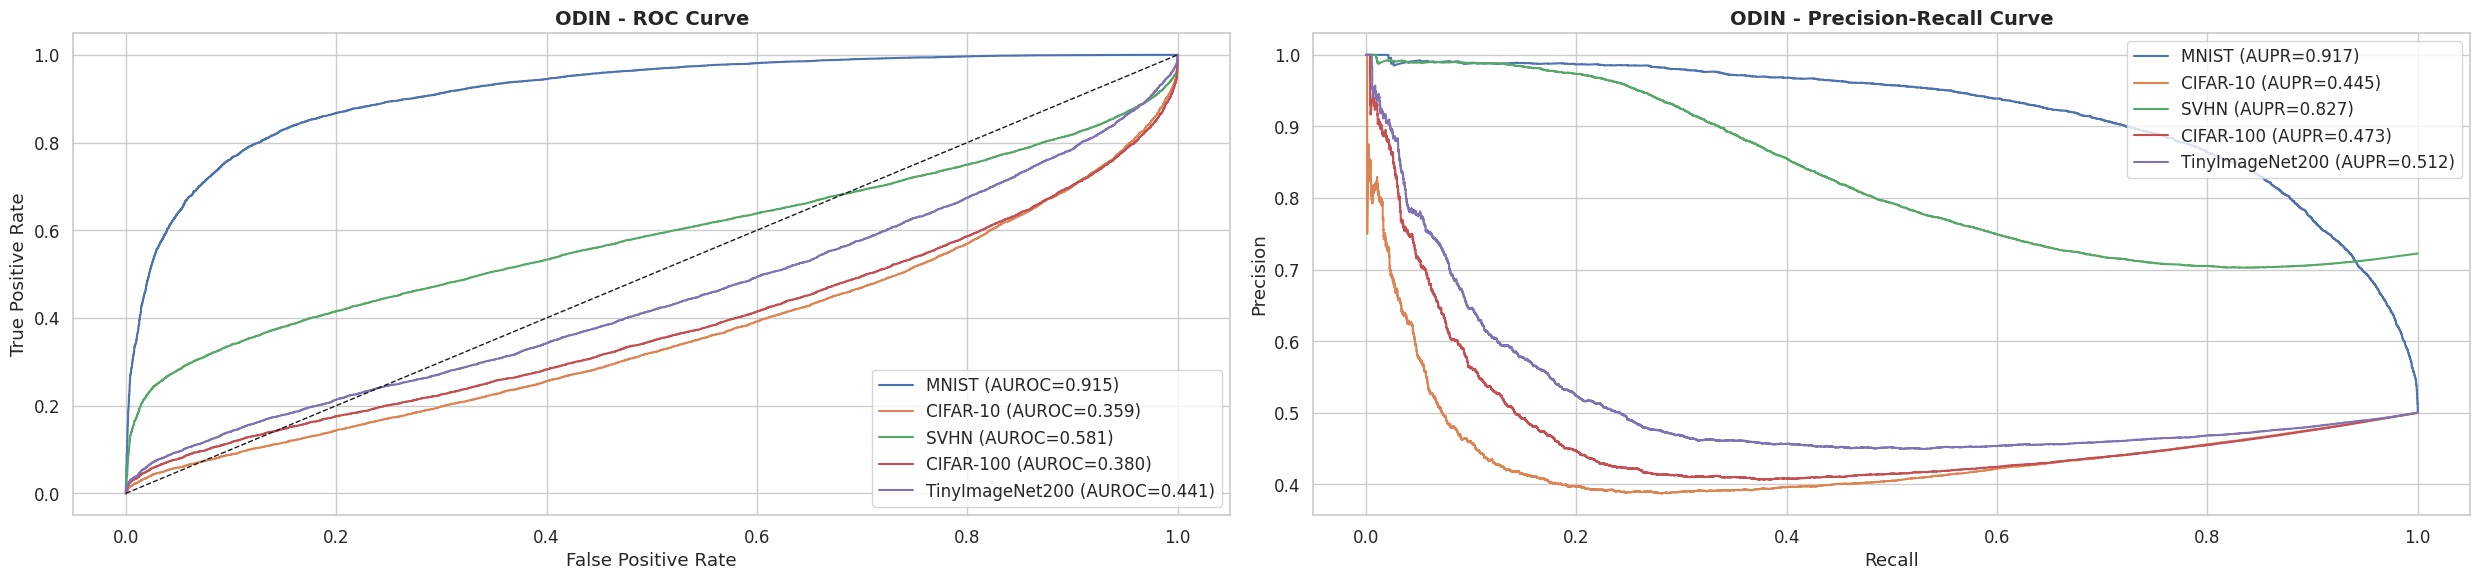

In [ ]:
plot_ood_curves(results_odin, metric)

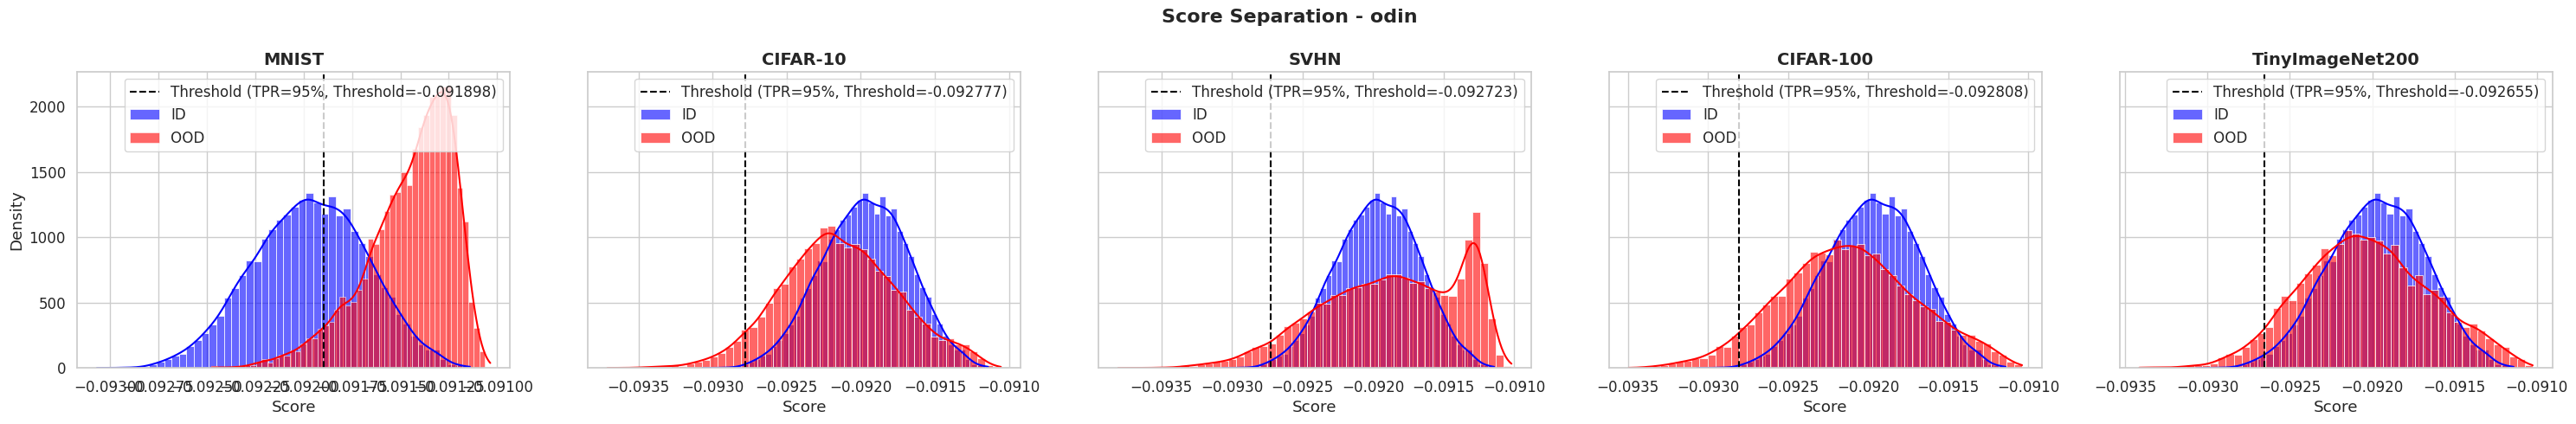

In [ ]:
plot_separation_for_method(results_odin, method_name=metric, target_tpr=0.95)

###### Energy

In [ ]:
metric = "energy"

In [ ]:
df_energy, results_energy = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - ENERGY


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID energy Mean  \
0            MNIST  0.8810  0.8839     0.5181         -8.3369   
1         CIFAR-10  0.2446  0.3757     0.9999         -8.3369   
2             SVHN  0.4749  0.7740     0.9998         -8.3369   
3        CIFAR-100  0.2664  0.3974     0.9999         -8.3369   
4  TinyImageNet200  0.3165  0.4238     0.9987         -8.3369   

   OOD energy Mean  Separation  
0          -4.2415      4.0954  
1         -11.9233      3.5865  
2          -9.1623      0.8254  
3         -11.7410      3.4041  
4         -10.7702      2.4333


Avg AUROC = 0.4367 | Avg AUPR = 0.5710 | Avg FPR@95TPR = 0.9033


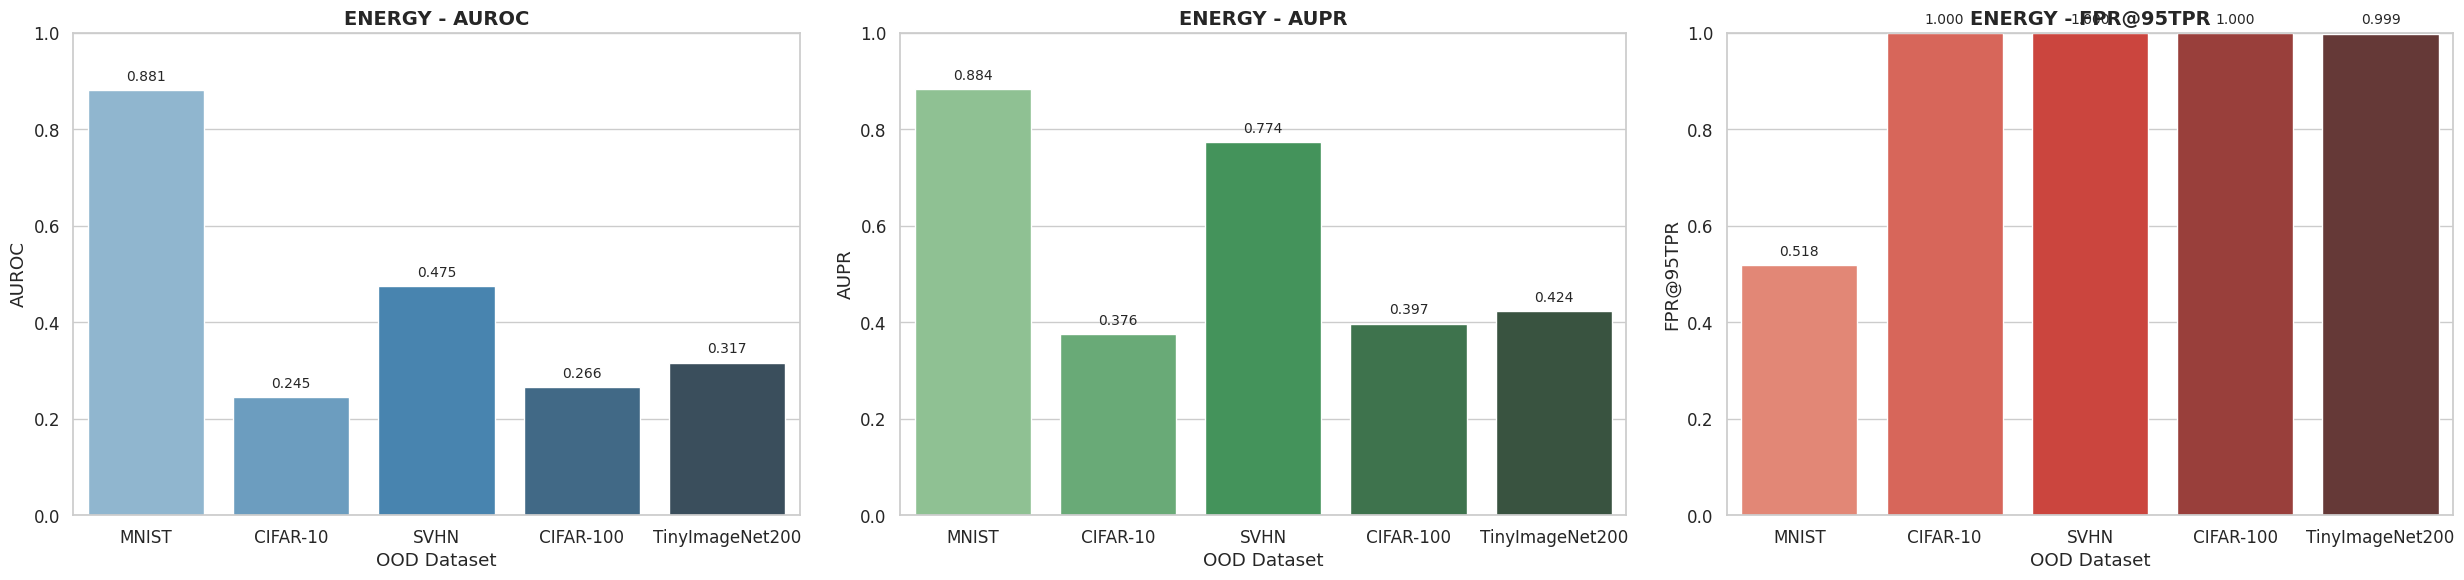

In [ ]:
plot_ood_metrics(df_energy, metric)

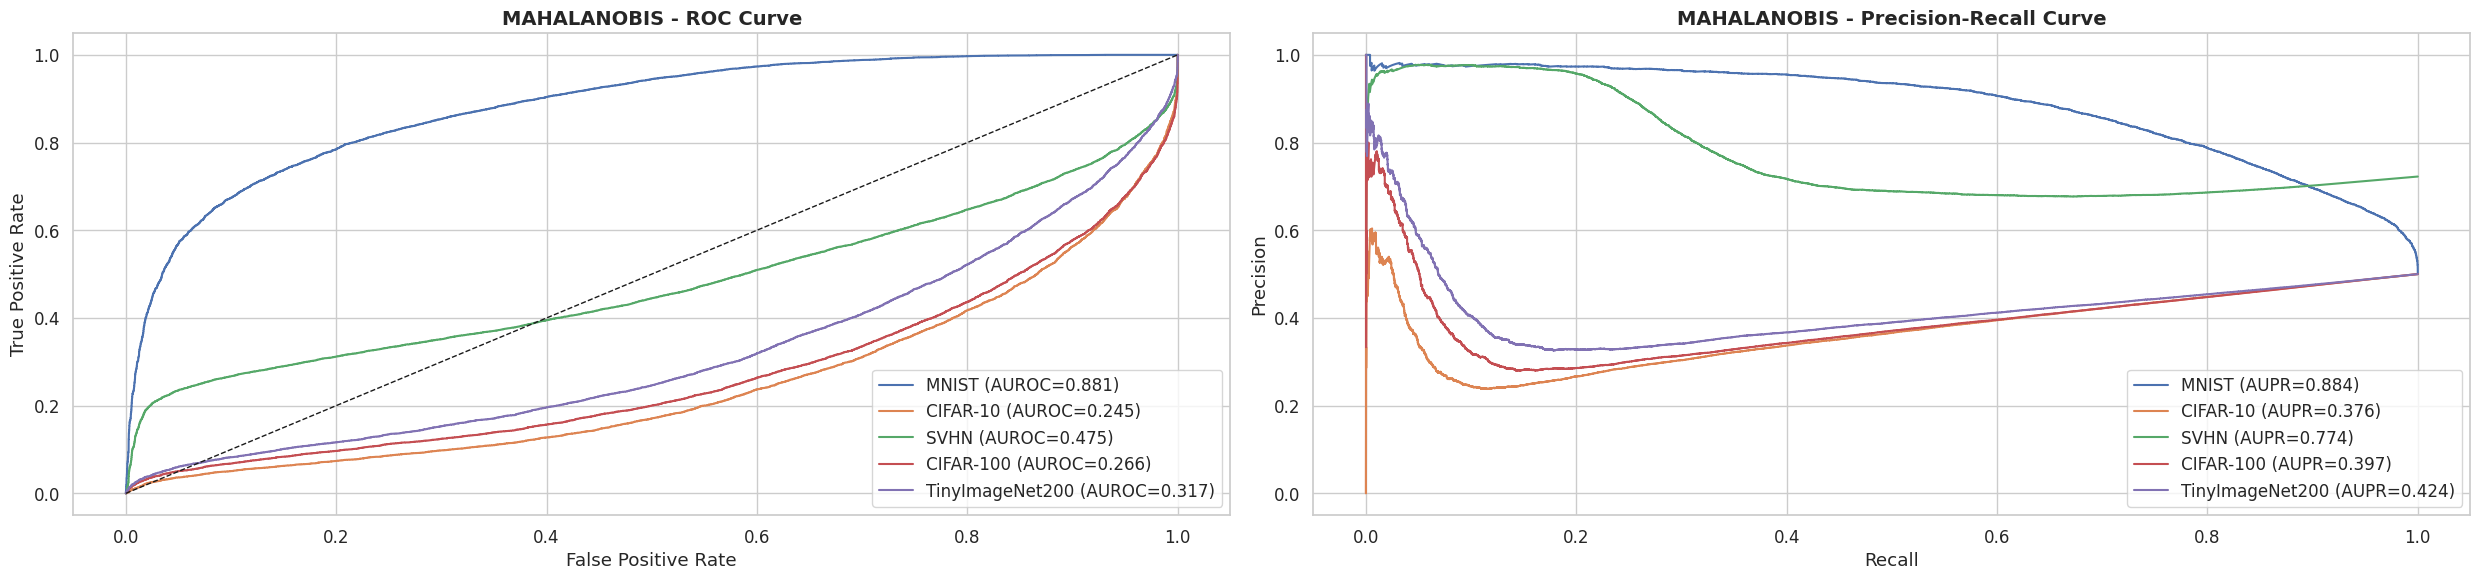

In [ ]:
plot_ood_curves(results_energy, metric)

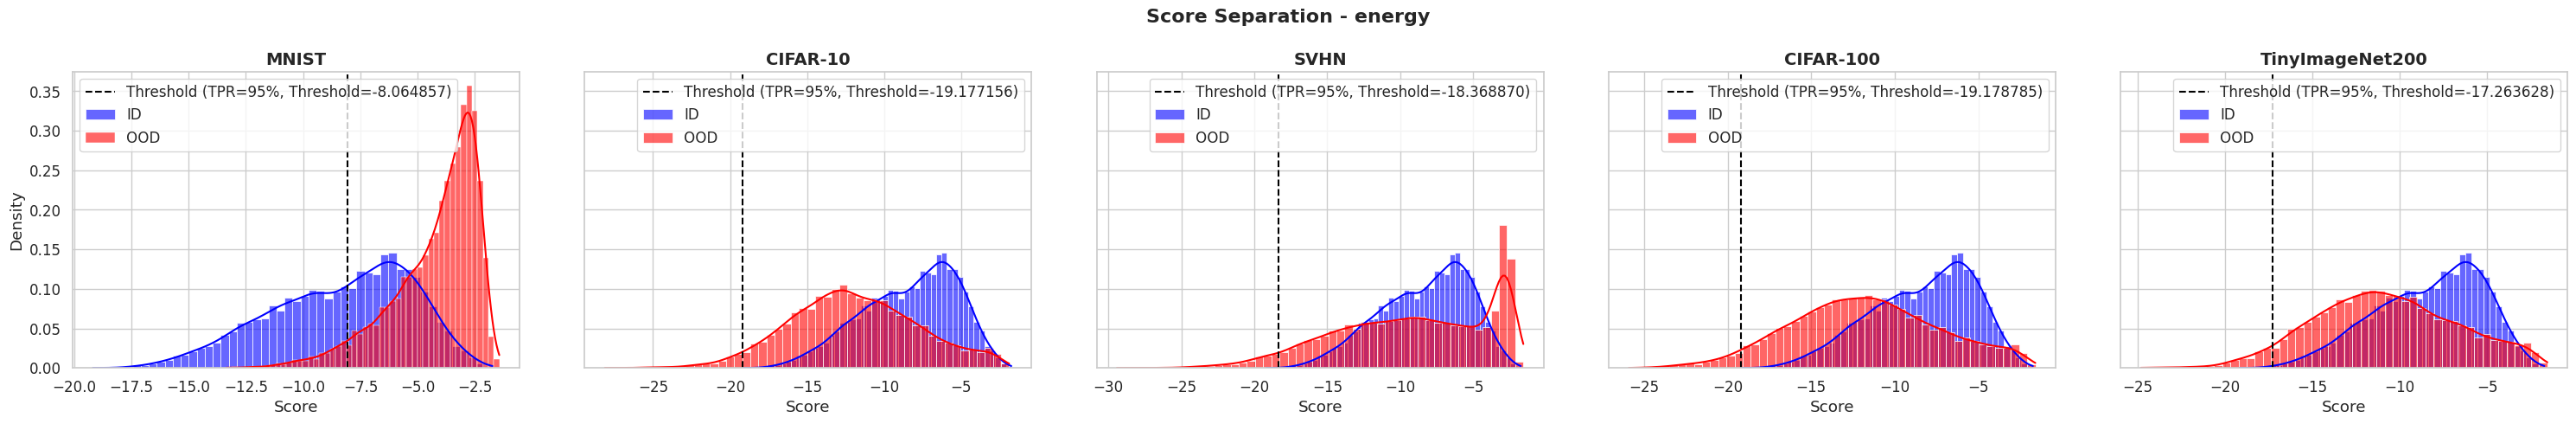

In [ ]:
plot_separation_for_method(results_energy, method_name=metric, target_tpr=0.95)

###### Mahalanobis

In [ ]:
metric = "mahalanobis"

In [ ]:
df_maha, results_maha = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - MAHALANOBIS


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID mahalanobis Mean  \
0            MNIST  0.9769  0.9713     0.0881          -120.104401   
1         CIFAR-10  0.9981  0.9983     0.0039          -120.104401   
2             SVHN  0.9901  0.9964     0.0398          -120.104401   
3        CIFAR-100  0.9963  0.9968     0.0052          -120.104401   
4  TinyImageNet200  0.9943  0.9950     0.0141          -120.104401   

   OOD mahalanobis Mean  Separation  
0           -374.015808  253.911407  
1          -1005.007812  884.903381  
2           -833.721802  713.617493  
3           -999.036499  878.932129  
4           -858.382385  738.278015


Avg AUROC = 0.9911 | Avg AUPR = 0.9916 | Avg FPR@95TPR = 0.0302


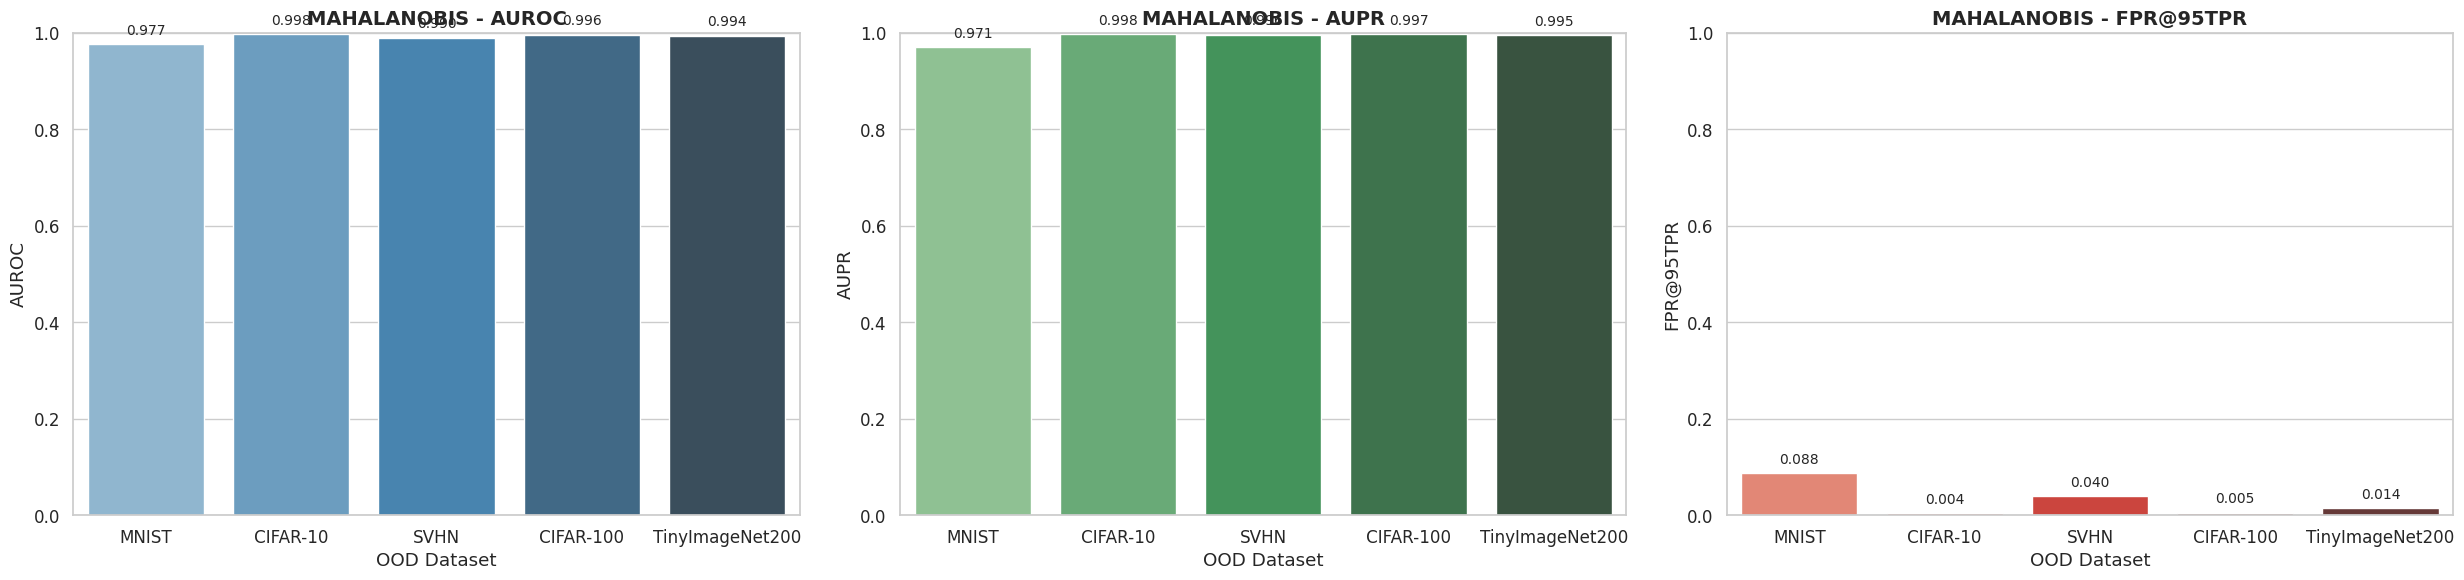

In [ ]:
plot_ood_metrics(df_maha, metric)

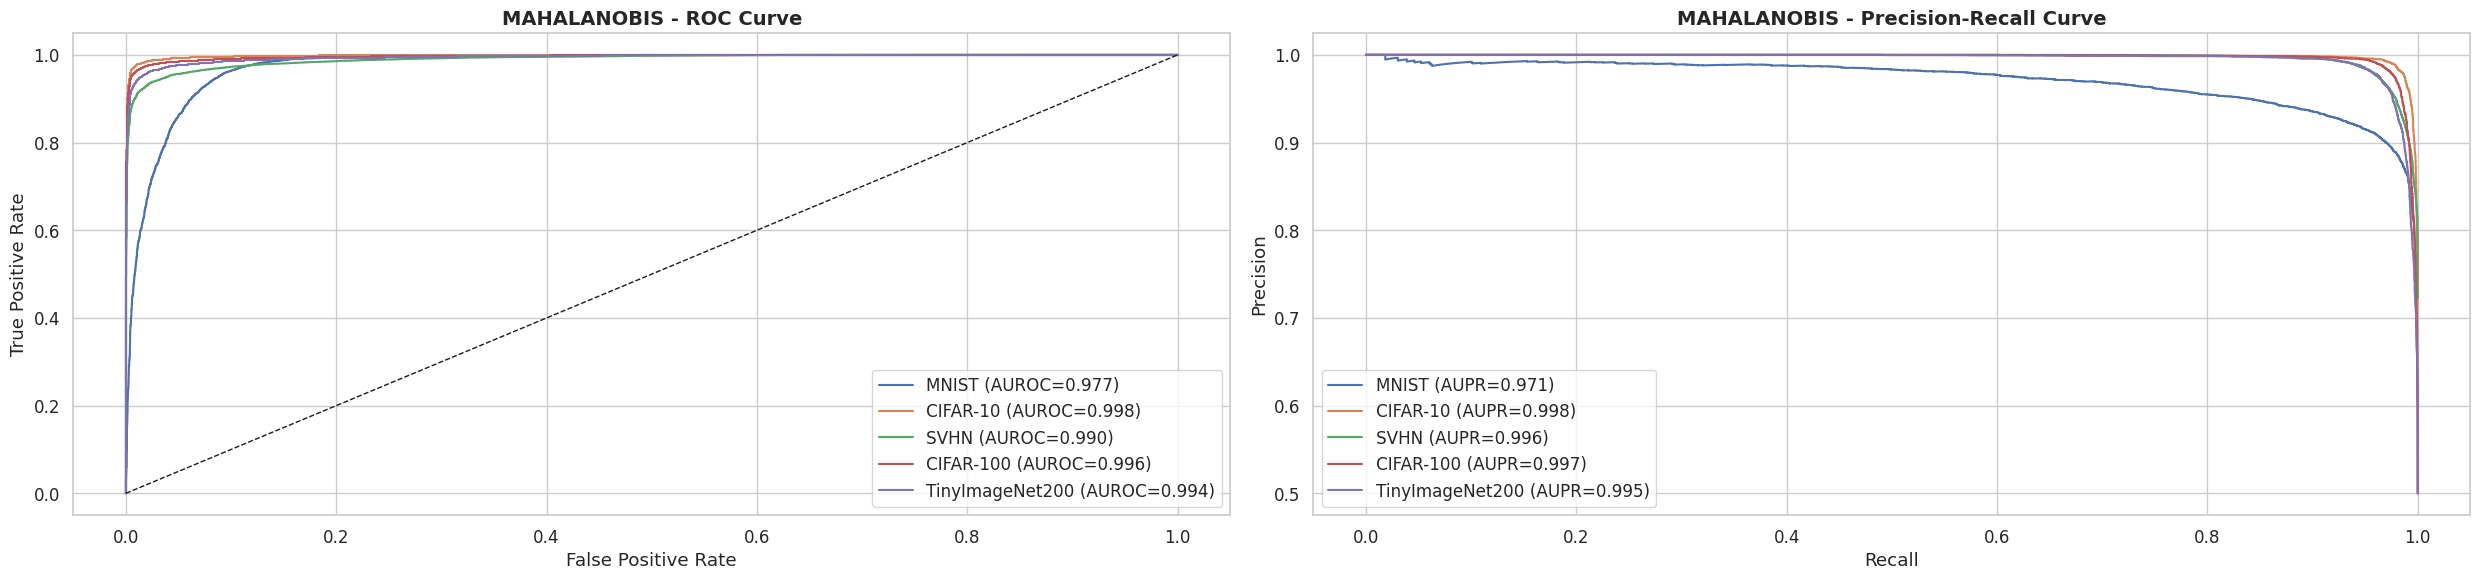

In [ ]:
plot_ood_curves(results_maha, metric)

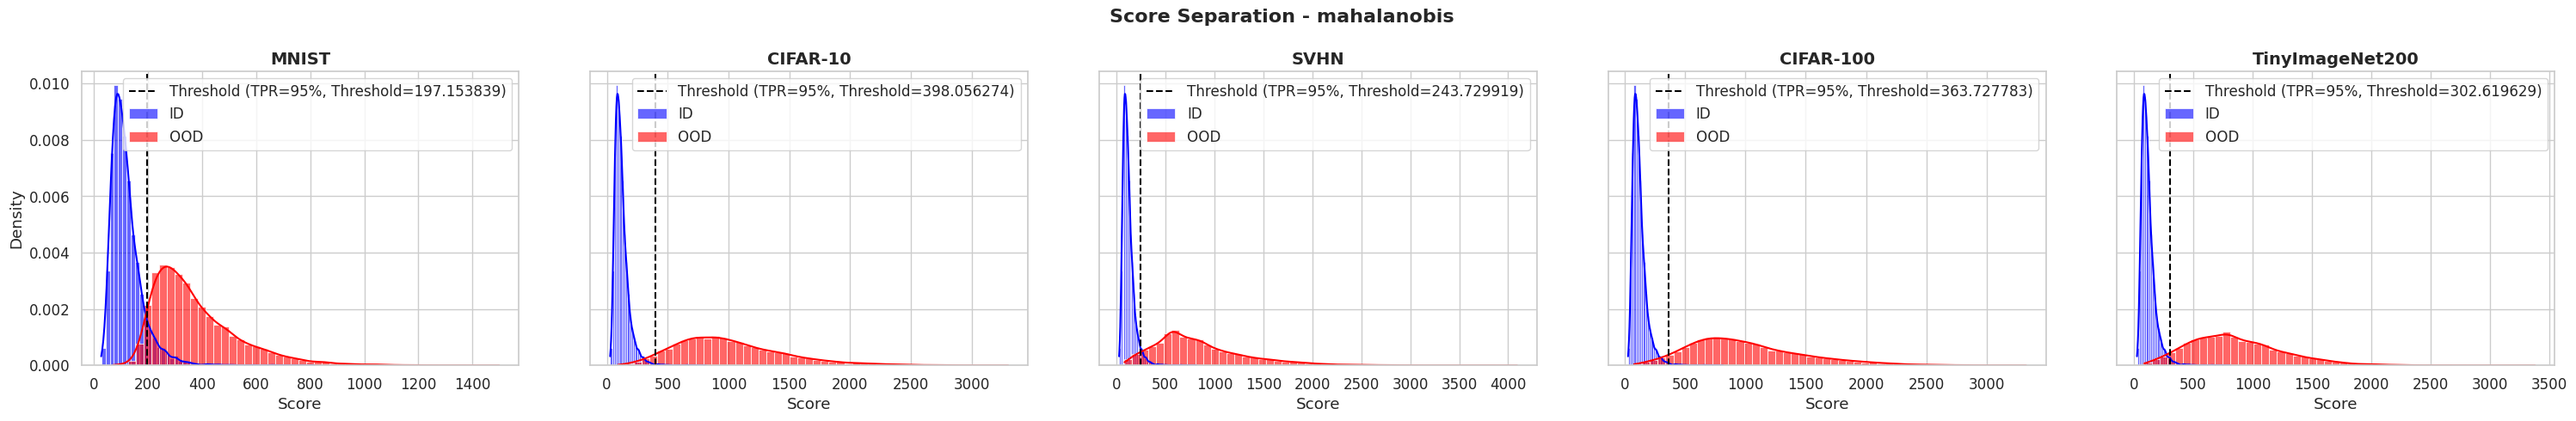

In [ ]:
plot_separation_for_method(results_maha, method_name=metric, target_tpr=0.95)